In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import csv
import numpy as np
import torch_directml
from tqdm import tqdm
import matplotlib.pyplot as plt

dml = torch_directml.device()

In [12]:
# datasets
class TitanicSurvivalDataset(Dataset):
    def __init__(self, data_tensor: torch.Tensor, target_tensor: torch.Tensor):
        self.data = data_tensor
        self.target = target_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data.data[index], self.target.data[index]

In [13]:
# open and closing files
training_file = open("train.csv", "r")

def close_files():
    training_file.close()

In [14]:
# functions for converting data
MAXLENGTH = 1000

def add_padding(list_item, max=500):
    result = list_item
    while len(result) < max:
        result.append(0)
    return result

def list_string_to_ascii(train_list):
    result = []
    for train in train_list:
        # print(train)
        temp = []
        for i, item in enumerate(train):
            current_item = []
            # print(i, item)
            if (i != 2):
                for char in item:
                    current_item.append(ord(char))
                
                current_item = add_padding(current_item, 40)
            else:
                for char in item:
                    current_item.append(ord(char))
                current_item = add_padding(current_item, 250)
            current_item.append(-1)
            temp = temp + current_item
        add_padding(temp, MAXLENGTH)
        result.append(temp)
    return result

In [15]:
# reading and converting file contents into tensor
def read_csv(csv_file):
    temp = list(csv.reader(csv_file, delimiter=","))
    del temp[0]
    return temp

train_list_initial = read_csv(training_file)

train_list = []
target_list = []

# removing the header and separating the target value into train_list and target_list
for i in range(len(train_list_initial)):
    item = train_list_initial[i]
    target_list.append(int(item[1]))
    del item[1]
    train_list.append(item)

# converting the 1D list to 2D list
target_list = [[x] for x in target_list]

# converting the string into numbers
train_ascii = list_string_to_ascii(train_list)

# splitting the data set into training and validation datasets
validation_ascii = train_ascii[-200:]
train_ascii = train_ascii[:(len(train_ascii)-200)]

validation_target_list = target_list[-200:]
target_list = target_list[:(len(target_list)-200)]

# converting the numbers into tensors
train_tensor = torch.FloatTensor(train_ascii)
target_tensor = torch.FloatTensor(target_list)
validation_tensor = torch.FloatTensor(validation_ascii)
validation_target_tensor = torch.FloatTensor(validation_target_list)

In [16]:
# initializing dataset
train_dataset = TitanicSurvivalDataset(train_tensor, target_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=60, shuffle=True)

validation_dataset = TitanicSurvivalDataset(validation_tensor, validation_target_tensor)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)


In [17]:
class SurvivedModel(nn.Module):
    def __init__(self, MAXLENGTH=1000):
        super(SurvivedModel, self).__init__()
        self.layer1 = nn.Linear(MAXLENGTH, 24)
        self.layer2 = nn.Linear(24, 12)
        self.layer3 = nn.Linear(12, 4)
        self.layer4 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
        pass

    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        x = self.layer2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.sigmoid(x)
        return x

In [18]:
# Model Training
survived_model = SurvivedModel()

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=survived_model.parameters(), lr=0.0005)

num_epochs = 10000
train_losses, val_losses = [], []

def start_training():
    for epoch in range(num_epochs):
        # training
        survived_model.train()
        running_loss = 0.0
        for person, target in tqdm(train_loader, desc = 'Training loop'):
            optimizer.zero_grad()
            person, target = person, target
            outputs = survived_model(person)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * target_tensor.size(0)
        train_loss = running_loss / len(train_dataset)
        train_losses.append(train_loss)

        # validation
        survived_model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for person, target in tqdm(validation_loader, desc = 'Validation loop'):
                person, target = person, target
                outputs = survived_model(person)
                loss = criterion(outputs, target)
                running_loss += loss.item() * target.size(0)
        val_loss = running_loss / len(validation_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

start_training()
# print(target_values)

torch.save(survived_model, "survived_model.pt")

Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 1/10000 - Train loss: 8.304568648338318, Validation loss: 0.6915341019630432


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 2/10000 - Train loss: 8.301051259040833, Validation loss: 0.6913284659385681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 3/10000 - Train loss: 8.300004065036774, Validation loss: 0.6911287605762482


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 4/10000 - Train loss: 8.296631932258606, Validation loss: 0.6909230411052704


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.55it/s]


Epoch 5/10000 - Train loss: 8.29559600353241, Validation loss: 0.6907261848449707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6/10000 - Train loss: 8.294192373752594, Validation loss: 0.690532785654068


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 7/10000 - Train loss: 8.29142302274704, Validation loss: 0.6903353631496429


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 8/10000 - Train loss: 8.289241909980774, Validation loss: 0.6901394307613373


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 9/10000 - Train loss: 8.28815072774887, Validation loss: 0.68994922041893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 10/10000 - Train loss: 8.286330103874207, Validation loss: 0.6897603631019592


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 11/10000 - Train loss: 8.28346461057663, Validation loss: 0.689568144083023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Epoch 12/10000 - Train loss: 8.282545983791351, Validation loss: 0.6893819391727447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 13/10000 - Train loss: 8.280178427696228, Validation loss: 0.6891941964626312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 14/10000 - Train loss: 8.276762247085571, Validation loss: 0.689003336429596


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 15/10000 - Train loss: 8.275926411151886, Validation loss: 0.6888182938098908


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 16/10000 - Train loss: 8.273073494434357, Validation loss: 0.6886297941207886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.36it/s]


Epoch 17/10000 - Train loss: 8.274298250675201, Validation loss: 0.6884541451931


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 18/10000 - Train loss: 8.2682985663414, Validation loss: 0.6882657110691071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 19/10000 - Train loss: 8.268526792526245, Validation loss: 0.6880853414535523


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1662.82it/s]


Epoch 20/10000 - Train loss: 8.267221748828888, Validation loss: 0.6879084289073945


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 21/10000 - Train loss: 8.265719413757324, Validation loss: 0.6877323031425476


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 22/10000 - Train loss: 8.261468768119812, Validation loss: 0.6875507473945618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 23/10000 - Train loss: 8.261189937591553, Validation loss: 0.6873748004436493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 24/10000 - Train loss: 8.258590757846832, Validation loss: 0.6871980369091034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 25/10000 - Train loss: 8.256012737751007, Validation loss: 0.6870203375816345


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 26/10000 - Train loss: 8.25419545173645, Validation loss: 0.6868436634540558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 27/10000 - Train loss: 8.25300544500351, Validation loss: 0.686670309305191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 28/10000 - Train loss: 8.252555072307587, Validation loss: 0.6865003705024719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 29/10000 - Train loss: 8.246163845062256, Validation loss: 0.6863205015659333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 30/10000 - Train loss: 8.246191143989563, Validation loss: 0.6861459016799927


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 31/10000 - Train loss: 8.246131718158722, Validation loss: 0.6859772026538848


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 32/10000 - Train loss: 8.246238946914673, Validation loss: 0.6858138263225555


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 33/10000 - Train loss: 8.238798975944519, Validation loss: 0.6856388568878173


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 34/10000 - Train loss: 8.239932358264923, Validation loss: 0.6854714512825012


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 35/10000 - Train loss: 8.237116277217865, Validation loss: 0.685303008556366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 36/10000 - Train loss: 8.235532402992249, Validation loss: 0.6851355314254761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 37/10000 - Train loss: 8.233600974082947, Validation loss: 0.684969162940979


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 38/10000 - Train loss: 8.237585663795471, Validation loss: 0.6848145127296448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 39/10000 - Train loss: 8.23045128583908, Validation loss: 0.6846504986286164


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 40/10000 - Train loss: 8.22974818944931, Validation loss: 0.6844895780086517


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 41/10000 - Train loss: 8.230494320392609, Validation loss: 0.6843340039253235


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 42/10000 - Train loss: 8.226844727993011, Validation loss: 0.6841752469539643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.46it/s]


Epoch 43/10000 - Train loss: 8.227367639541626, Validation loss: 0.6840213894844055


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 44/10000 - Train loss: 8.22447007894516, Validation loss: 0.6838665008544922


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.43it/s]


Epoch 45/10000 - Train loss: 8.225452601909637, Validation loss: 0.6837169051170349


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 46/10000 - Train loss: 8.225231051445007, Validation loss: 0.6835701584815979


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 47/10000 - Train loss: 8.221339523792267, Validation loss: 0.6834202945232392


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 48/10000 - Train loss: 8.216926753520966, Validation loss: 0.6832674086093903


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 49/10000 - Train loss: 8.21421229839325, Validation loss: 0.6831134378910064


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 50/10000 - Train loss: 8.216775000095367, Validation loss: 0.6829666316509246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 51/10000 - Train loss: 8.221004128456116, Validation loss: 0.6828285038471222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 52/10000 - Train loss: 8.205573976039886, Validation loss: 0.6826715469360352


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 53/10000 - Train loss: 8.208092212677002, Validation loss: 0.6825217306613922


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.86it/s]


Epoch 54/10000 - Train loss: 8.218152463436127, Validation loss: 0.6823889136314392


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 55/10000 - Train loss: 8.2078577876091, Validation loss: 0.682244998216629


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 56/10000 - Train loss: 8.203490972518921, Validation loss: 0.68209787607193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 57/10000 - Train loss: 8.209267437458038, Validation loss: 0.6819620132446289


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 58/10000 - Train loss: 8.202342689037323, Validation loss: 0.6818189859390259


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 59/10000 - Train loss: 8.210039854049683, Validation loss: 0.6816887378692627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 60/10000 - Train loss: 8.200977385044098, Validation loss: 0.6815494477748871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.80it/s]


Epoch 61/10000 - Train loss: 8.196195125579834, Validation loss: 0.6814073503017426


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 62/10000 - Train loss: 8.197879433631897, Validation loss: 0.6812702238559722


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 63/10000 - Train loss: 8.20011979341507, Validation loss: 0.6811378240585327


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 64/10000 - Train loss: 8.197255671024323, Validation loss: 0.6810044169425964


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.72it/s]


Epoch 65/10000 - Train loss: 8.197247505187988, Validation loss: 0.6808737814426422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 66/10000 - Train loss: 8.200926542282104, Validation loss: 0.6807501435279846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 67/10000 - Train loss: 8.187834203243256, Validation loss: 0.6806133687496185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 68/10000 - Train loss: 8.188268661499023, Validation loss: 0.6804795742034913


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 69/10000 - Train loss: 8.188587725162506, Validation loss: 0.680348539352417


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 70/10000 - Train loss: 8.174974620342255, Validation loss: 0.680205374956131


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 71/10000 - Train loss: 8.17876273393631, Validation loss: 0.6800689578056336


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 72/10000 - Train loss: 8.18454498052597, Validation loss: 0.6799410998821258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 73/10000 - Train loss: 8.18516880273819, Validation loss: 0.6798159360885621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 74/10000 - Train loss: 8.185425043106079, Validation loss: 0.6796934366226196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 75/10000 - Train loss: 8.180812537670135, Validation loss: 0.6795682609081268


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]

Epoch 76/10000 - Train loss: 8.17928671836853, Validation loss: 0.6794438302516937



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 77/10000 - Train loss: 8.18201196193695, Validation loss: 0.6793242573738099


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 78/10000 - Train loss: 8.178734123706818, Validation loss: 0.679203850030899


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 79/10000 - Train loss: 8.170120418071747, Validation loss: 0.6790766000747681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 80/10000 - Train loss: 8.172659039497375, Validation loss: 0.6789539694786072


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 81/10000 - Train loss: 8.1750448346138, Validation loss: 0.6788357138633728


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 82/10000 - Train loss: 8.156327724456787, Validation loss: 0.6787019491195678


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 83/10000 - Train loss: 8.172707796096802, Validation loss: 0.6785856425762177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 84/10000 - Train loss: 8.167386531829834, Validation loss: 0.678466546535492


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 85/10000 - Train loss: 8.160253286361694, Validation loss: 0.678342878818512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 86/10000 - Train loss: 8.169008314609528, Validation loss: 0.678229284286499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 87/10000 - Train loss: 8.165921688079834, Validation loss: 0.6781149268150329


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 88/10000 - Train loss: 8.162570416927338, Validation loss: 0.6779994666576385


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 89/10000 - Train loss: 8.172111093997955, Validation loss: 0.6778937160968781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.80it/s]


Epoch 90/10000 - Train loss: 8.164782702922821, Validation loss: 0.6777833580970765


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 91/10000 - Train loss: 8.16583126783371, Validation loss: 0.6776756465435028


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.42it/s]


Epoch 92/10000 - Train loss: 8.164620697498322, Validation loss: 0.6775688469409943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 93/10000 - Train loss: 8.15509980916977, Validation loss: 0.6774556279182434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 94/10000 - Train loss: 8.167121708393097, Validation loss: 0.677353584766388


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.91it/s]


Epoch 95/10000 - Train loss: 8.15041309595108, Validation loss: 0.677240127325058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 96/10000 - Train loss: 8.160545706748962, Validation loss: 0.6771360695362091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 97/10000 - Train loss: 8.157128930091858, Validation loss: 0.677031272649765


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 98/10000 - Train loss: 8.1517613530159, Validation loss: 0.6769237458705902


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 99/10000 - Train loss: 8.16213834285736, Validation loss: 0.6768254578113556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 100/10000 - Train loss: 8.14948558807373, Validation loss: 0.6767192840576172


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 101/10000 - Train loss: 8.150911092758179, Validation loss: 0.6766156196594239


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 102/10000 - Train loss: 8.149774134159088, Validation loss: 0.6765128970146179


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.99it/s]


Epoch 103/10000 - Train loss: 8.146641492843628, Validation loss: 0.6764089226722717


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 104/10000 - Train loss: 8.152628421783447, Validation loss: 0.6763107120990753


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 105/10000 - Train loss: 8.149060189723969, Validation loss: 0.6762117862701416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 106/10000 - Train loss: 8.155443370342255, Validation loss: 0.6761185467243195


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.41it/s]


Epoch 107/10000 - Train loss: 8.144831001758575, Validation loss: 0.6760189235210419


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 108/10000 - Train loss: 8.146301507949829, Validation loss: 0.6759217381477356


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 109/10000 - Train loss: 8.14792513847351, Validation loss: 0.6758268415927887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.28it/s]


Epoch 110/10000 - Train loss: 8.14213252067566, Validation loss: 0.675729364156723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 111/10000 - Train loss: 8.148672699928284, Validation loss: 0.6756375908851624


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 112/10000 - Train loss: 8.12530118227005, Validation loss: 0.6755314469337463


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 113/10000 - Train loss: 8.14151155948639, Validation loss: 0.6754375457763672


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 114/10000 - Train loss: 8.143354296684265, Validation loss: 0.6753461003303528


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 115/10000 - Train loss: 8.144938170909882, Validation loss: 0.6752567291259766


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 116/10000 - Train loss: 8.138993382453918, Validation loss: 0.6751647353172302


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 117/10000 - Train loss: 8.133016288280487, Validation loss: 0.6750701367855072


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 118/10000 - Train loss: 8.134582459926605, Validation loss: 0.6749778091907501


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 119/10000 - Train loss: 8.1311976313591, Validation loss: 0.6748843908309936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 120/10000 - Train loss: 8.135242700576782, Validation loss: 0.674794864654541


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 121/10000 - Train loss: 8.129400968551636, Validation loss: 0.6747027397155761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.07it/s]


Epoch 122/10000 - Train loss: 8.133680820465088, Validation loss: 0.6746143519878387


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 123/10000 - Train loss: 8.132926166057587, Validation loss: 0.6745266914367676


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 124/10000 - Train loss: 8.142710149288177, Validation loss: 0.674446189403534


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 125/10000 - Train loss: 8.13410359621048, Validation loss: 0.6743613004684448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 126/10000 - Train loss: 8.133202016353607, Validation loss: 0.6742769002914428


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 127/10000 - Train loss: 8.116127848625183, Validation loss: 0.6741833925247193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 128/10000 - Train loss: 8.104227006435394, Validation loss: 0.6740843415260315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 129/10000 - Train loss: 8.116839349269867, Validation loss: 0.6739937603473664


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 130/10000 - Train loss: 8.127300322055817, Validation loss: 0.6739100635051727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 131/10000 - Train loss: 8.126256346702576, Validation loss: 0.673827052116394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 132/10000 - Train loss: 8.125483751296997, Validation loss: 0.6737445890903473


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 133/10000 - Train loss: 8.121930241584778, Validation loss: 0.673661184310913


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1668.18it/s]


Epoch 134/10000 - Train loss: 8.121243000030518, Validation loss: 0.6735781073570252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 135/10000 - Train loss: 8.117308616638184, Validation loss: 0.6734942078590394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 136/10000 - Train loss: 8.110886752605438, Validation loss: 0.6734074473381042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 137/10000 - Train loss: 8.12463629245758, Validation loss: 0.6733293890953064


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Epoch 138/10000 - Train loss: 8.109356760978699, Validation loss: 0.6732441842556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 139/10000 - Train loss: 8.117323458194733, Validation loss: 0.6731637358665467


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.74it/s]


Epoch 140/10000 - Train loss: 8.116459906101227, Validation loss: 0.6730839490890503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 141/10000 - Train loss: 8.118382692337036, Validation loss: 0.6730063319206238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 142/10000 - Train loss: 8.118000566959381, Validation loss: 0.6729292452335358


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 143/10000 - Train loss: 8.108379065990448, Validation loss: 0.6728478848934174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.64it/s]


Epoch 144/10000 - Train loss: 8.110453605651855, Validation loss: 0.6727686941623687


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1536.15it/s]


Epoch 145/10000 - Train loss: 8.127532958984375, Validation loss: 0.6726990342140198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 146/10000 - Train loss: 8.106093943119049, Validation loss: 0.6726192235946655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 147/10000 - Train loss: 8.111293256282806, Validation loss: 0.672543054819107


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.48it/s]


Epoch 148/10000 - Train loss: 8.119760751724243, Validation loss: 0.672471821308136


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 149/10000 - Train loss: 8.112812340259552, Validation loss: 0.6723981201648712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 150/10000 - Train loss: 8.106003403663635, Validation loss: 0.672322005033493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 151/10000 - Train loss: 8.114747822284698, Validation loss: 0.6722505450248718


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 152/10000 - Train loss: 8.104817986488342, Validation loss: 0.6721752047538757


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 153/10000 - Train loss: 8.107155799865723, Validation loss: 0.6721017777919769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 154/10000 - Train loss: 8.099956035614014, Validation loss: 0.6720260858535767


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 155/10000 - Train loss: 8.099440157413483, Validation loss: 0.6719506740570068


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.62it/s]


Epoch 156/10000 - Train loss: 8.105149269104004, Validation loss: 0.6718787670135498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 157/10000 - Train loss: 8.107403814792633, Validation loss: 0.6718089044094085


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 158/10000 - Train loss: 8.116526365280151, Validation loss: 0.6717436671257019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.02it/s]


Epoch 159/10000 - Train loss: 8.103138744831085, Validation loss: 0.6716731309890747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 160/10000 - Train loss: 8.099080622196198, Validation loss: 0.6716013550758362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Epoch 161/10000 - Train loss: 8.095548927783966, Validation loss: 0.6715286612510681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 162/10000 - Train loss: 8.101180374622345, Validation loss: 0.6714593589305877


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 163/10000 - Train loss: 8.103513062000275, Validation loss: 0.6713919639587402


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 164/10000 - Train loss: 8.096697568893433, Validation loss: 0.6713220715522766


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.53it/s]


Epoch 165/10000 - Train loss: 8.108850419521332, Validation loss: 0.6712585508823394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 166/10000 - Train loss: 8.095550954341888, Validation loss: 0.6711895108222962


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 167/10000 - Train loss: 8.088035225868225, Validation loss: 0.6711180448532105


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 168/10000 - Train loss: 8.107309699058533, Validation loss: 0.6710553824901581


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 169/10000 - Train loss: 8.103664875030518, Validation loss: 0.6709920346736908


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 170/10000 - Train loss: 8.096190989017487, Validation loss: 0.670926159620285


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 171/10000 - Train loss: 8.088539361953735, Validation loss: 0.6708577036857605


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.03it/s]


Epoch 172/10000 - Train loss: 8.094829261302948, Validation loss: 0.6707925736904145


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 173/10000 - Train loss: 8.097724854946136, Validation loss: 0.6707292854785919


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 174/10000 - Train loss: 8.103904068470001, Validation loss: 0.6706692695617675


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 175/10000 - Train loss: 8.076068997383118, Validation loss: 0.6705981969833374


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 176/10000 - Train loss: 8.078900694847107, Validation loss: 0.6705291509628296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 177/10000 - Train loss: 8.0987508893013, Validation loss: 0.6704687058925629


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 178/10000 - Train loss: 8.09121584892273, Validation loss: 0.6704059541225433


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.00it/s]


Epoch 179/10000 - Train loss: 8.090853571891785, Validation loss: 0.6703436136245727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 180/10000 - Train loss: 8.093570828437805, Validation loss: 0.6702829480171204


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 181/10000 - Train loss: 8.079184412956238, Validation loss: 0.6702171504497528


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 182/10000 - Train loss: 8.081887066364288, Validation loss: 0.6701533496379852


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 183/10000 - Train loss: 8.077911138534546, Validation loss: 0.6700883626937866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 184/10000 - Train loss: 8.094953417778015, Validation loss: 0.6700306177139282


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.29it/s]


Epoch 185/10000 - Train loss: 8.087480783462524, Validation loss: 0.6699704766273499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 186/10000 - Train loss: 8.090505361557007, Validation loss: 0.6699121117591857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 187/10000 - Train loss: 8.086180329322815, Validation loss: 0.6698526859283447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 188/10000 - Train loss: 8.089351534843445, Validation loss: 0.6697950780391693


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 416.58it/s]


Epoch 189/10000 - Train loss: 8.085213661193848, Validation loss: 0.6697362899780274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 190/10000 - Train loss: 8.095482885837555, Validation loss: 0.6696821689605713


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 191/10000 - Train loss: 8.076963663101196, Validation loss: 0.6696213901042938


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 192/10000 - Train loss: 8.07994693517685, Validation loss: 0.6695625126361847


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 193/10000 - Train loss: 8.093895435333252, Validation loss: 0.6695091545581817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 194/10000 - Train loss: 8.08253014087677, Validation loss: 0.6694521009922028


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 195/10000 - Train loss: 8.096581637859344, Validation loss: 0.6694008231163024


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 196/10000 - Train loss: 8.081655740737915, Validation loss: 0.6693446278572083


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 197/10000 - Train loss: 8.07750117778778, Validation loss: 0.6692874908447266


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 198/10000 - Train loss: 8.080616235733032, Validation loss: 0.6692317306995392


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 199/10000 - Train loss: 8.07268762588501, Validation loss: 0.6691738367080688


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1952.84it/s]


Epoch 200/10000 - Train loss: 8.064740002155304, Validation loss: 0.669113564491272


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.72it/s]


Epoch 201/10000 - Train loss: 8.097711861133575, Validation loss: 0.6690655410289764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 202/10000 - Train loss: 8.08238434791565, Validation loss: 0.6690125048160553


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 203/10000 - Train loss: 8.07441931962967, Validation loss: 0.6689572155475616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 204/10000 - Train loss: 8.062519550323486, Validation loss: 0.6688981413841247


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 205/10000 - Train loss: 8.088557302951813, Validation loss: 0.6688487827777863


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 206/10000 - Train loss: 8.084184169769287, Validation loss: 0.668798154592514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.48it/s]


Epoch 207/10000 - Train loss: 8.087695956230164, Validation loss: 0.6687492191791534


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 208/10000 - Train loss: 8.052904188632965, Validation loss: 0.6686890602111817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 209/10000 - Train loss: 8.059907615184784, Validation loss: 0.6686318039894104


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 210/10000 - Train loss: 8.086148858070374, Validation loss: 0.6685838043689728


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 211/10000 - Train loss: 8.066610336303711, Validation loss: 0.6685296595096588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 212/10000 - Train loss: 8.081505954265594, Validation loss: 0.6684807240962982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 213/10000 - Train loss: 8.081137239933014, Validation loss: 0.6684322834014893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 214/10000 - Train loss: 8.068876445293427, Validation loss: 0.6683803021907806


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 215/10000 - Train loss: 8.08410656452179, Validation loss: 0.6683336436748505


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 216/10000 - Train loss: 8.060227453708649, Validation loss: 0.6682797491550445


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 217/10000 - Train loss: 8.051995396614075, Validation loss: 0.6682236611843109


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 218/10000 - Train loss: 8.075187385082245, Validation loss: 0.66817547082901


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 219/10000 - Train loss: 8.078489542007446, Validation loss: 0.6681286990642548


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 220/10000 - Train loss: 8.085950493812561, Validation loss: 0.6680846810340881


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 221/10000 - Train loss: 8.085865497589111, Validation loss: 0.6680410265922546


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 222/10000 - Train loss: 8.065561711788177, Validation loss: 0.6679913341999054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 223/10000 - Train loss: 8.084917843341827, Validation loss: 0.6679480373859406


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 224/10000 - Train loss: 8.096306920051575, Validation loss: 0.6679086446762085


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 225/10000 - Train loss: 8.084165453910828, Validation loss: 0.6678658723831177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1963.72it/s]


Epoch 226/10000 - Train loss: 8.059919953346252, Validation loss: 0.667815899848938


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 227/10000 - Train loss: 8.075665473937988, Validation loss: 0.6677711784839631


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 228/10000 - Train loss: 8.071044445037842, Validation loss: 0.6677254021167756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 229/10000 - Train loss: 8.06239902973175, Validation loss: 0.667677390575409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 230/10000 - Train loss: 8.066355288028717, Validation loss: 0.6676309108734131


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 231/10000 - Train loss: 8.073795437812805, Validation loss: 0.6675870299339295


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 232/10000 - Train loss: 8.061322927474976, Validation loss: 0.6675397276878356


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.81it/s]


Epoch 233/10000 - Train loss: 8.081418335437775, Validation loss: 0.667498791217804


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 234/10000 - Train loss: 8.060799181461334, Validation loss: 0.6674520373344421


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 235/10000 - Train loss: 8.060162007808685, Validation loss: 0.6674055993556977


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 236/10000 - Train loss: 8.068229854106903, Validation loss: 0.6673617541790009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 237/10000 - Train loss: 8.071852803230286, Validation loss: 0.667319393157959


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 238/10000 - Train loss: 8.06315678358078, Validation loss: 0.6672747373580933


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 239/10000 - Train loss: 8.075302183628082, Validation loss: 0.667234081029892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 240/10000 - Train loss: 8.037498891353607, Validation loss: 0.6671827673912049


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.29it/s]


Epoch 241/10000 - Train loss: 8.074482560157776, Validation loss: 0.6671426653861999


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 242/10000 - Train loss: 8.082293689250946, Validation loss: 0.6671048939228058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 243/10000 - Train loss: 8.073753774166107, Validation loss: 0.6670650959014892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 244/10000 - Train loss: 8.04847502708435, Validation loss: 0.6670182585716248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 245/10000 - Train loss: 8.060505509376526, Validation loss: 0.6669751763343811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 246/10000 - Train loss: 8.059997797012329, Validation loss: 0.6669322431087494


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 247/10000 - Train loss: 8.055499196052551, Validation loss: 0.6668885469436645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 248/10000 - Train loss: 8.059203088283539, Validation loss: 0.6668461859226227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 249/10000 - Train loss: 8.07567811012268, Validation loss: 0.6668086171150207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 250/10000 - Train loss: 8.067241132259369, Validation loss: 0.666769015789032


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 251/10000 - Train loss: 8.058179795742035, Validation loss: 0.6667273104190826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.96it/s]


Epoch 252/10000 - Train loss: 8.070618510246277, Validation loss: 0.6666893422603607


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 253/10000 - Train loss: 8.048950552940369, Validation loss: 0.6666456937789917


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.82it/s]

Epoch 254/10000 - Train loss: 8.044342637062073, Validation loss: 0.6666010856628418



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.05it/s]


Epoch 255/10000 - Train loss: 8.039704978466034, Validation loss: 0.6665556192398071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 256/10000 - Train loss: 8.060806930065155, Validation loss: 0.6665160238742829


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 257/10000 - Train loss: 8.08619350194931, Validation loss: 0.666483473777771


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 258/10000 - Train loss: 8.056100249290466, Validation loss: 0.6664430022239685


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 259/10000 - Train loss: 8.046657681465149, Validation loss: 0.666400420665741


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.56it/s]


Epoch 260/10000 - Train loss: 8.042201161384583, Validation loss: 0.666357034444809


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 261/10000 - Train loss: 8.072173655033112, Validation loss: 0.6663216471672058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.80it/s]


Epoch 262/10000 - Train loss: 8.050049722194672, Validation loss: 0.6662808954715729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 263/10000 - Train loss: 8.049581944942474, Validation loss: 0.6662402212619781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.39it/s]


Epoch 264/10000 - Train loss: 8.071130275726318, Validation loss: 0.6662054598331452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 265/10000 - Train loss: 8.07072651386261, Validation loss: 0.666170746088028


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 266/10000 - Train loss: 8.039841830730438, Validation loss: 0.6661285281181335


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.20it/s]


Epoch 267/10000 - Train loss: 8.030737280845642, Validation loss: 0.6660841405391693


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 268/10000 - Train loss: 8.078810334205627, Validation loss: 0.6660520672798157


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.49it/s]


Epoch 269/10000 - Train loss: 8.047799944877625, Validation loss: 0.666012442111969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 270/10000 - Train loss: 8.060675323009491, Validation loss: 0.6659763097763062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 271/10000 - Train loss: 8.055726528167725, Validation loss: 0.665939211845398


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 272/10000 - Train loss: 8.04652214050293, Validation loss: 0.665900194644928


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 273/10000 - Train loss: 8.059433043003082, Validation loss: 0.6658643960952759


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 274/10000 - Train loss: 8.046124458312988, Validation loss: 0.6658257603645324


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.53it/s]


Epoch 275/10000 - Train loss: 8.027656316757202, Validation loss: 0.6657827496528625


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 276/10000 - Train loss: 8.045305788516998, Validation loss: 0.6657442390918732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 277/10000 - Train loss: 8.053872287273407, Validation loss: 0.6657081007957458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 278/10000 - Train loss: 8.040085673332214, Validation loss: 0.6656688690185547


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 279/10000 - Train loss: 8.075619995594025, Validation loss: 0.6656384348869324


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 280/10000 - Train loss: 8.070647537708282, Validation loss: 0.6656067728996277


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.95it/s]


Epoch 281/10000 - Train loss: 8.030009269714355, Validation loss: 0.6655656337738037


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 282/10000 - Train loss: 8.052569925785065, Validation loss: 0.6655301868915557


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.99it/s]


Epoch 283/10000 - Train loss: 8.051716148853302, Validation loss: 0.6654946982860566


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 284/10000 - Train loss: 8.047201156616211, Validation loss: 0.6654583036899566


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 285/10000 - Train loss: 8.055846989154816, Validation loss: 0.6654243290424346


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.20it/s]


Epoch 286/10000 - Train loss: 8.041768670082092, Validation loss: 0.6653872728347778


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 287/10000 - Train loss: 8.036899089813232, Validation loss: 0.6653491437435151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 288/10000 - Train loss: 8.045828342437744, Validation loss: 0.6653134107589722


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 289/10000 - Train loss: 8.027282893657684, Validation loss: 0.6652735114097595


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 290/10000 - Train loss: 8.040595531463623, Validation loss: 0.6652370691299438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 291/10000 - Train loss: 8.04931390285492, Validation loss: 0.6652029395103455


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.86it/s]


Epoch 292/10000 - Train loss: 8.035230100154877, Validation loss: 0.6651655614376069


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.91it/s]


Epoch 293/10000 - Train loss: 8.039282381534576, Validation loss: 0.6651294350624084


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 294/10000 - Train loss: 8.053257644176483, Validation loss: 0.665096664428711


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 295/10000 - Train loss: 8.048109650611877, Validation loss: 0.6650628089904785


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 296/10000 - Train loss: 8.057234048843384, Validation loss: 0.6650315344333648


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 297/10000 - Train loss: 8.042890965938568, Validation loss: 0.6649970829486846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 298/10000 - Train loss: 8.038004457950592, Validation loss: 0.6649616062641144


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 299/10000 - Train loss: 8.019050240516663, Validation loss: 0.6649220407009124


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 300/10000 - Train loss: 8.042392373085022, Validation loss: 0.6648881256580352


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 301/10000 - Train loss: 8.04160076379776, Validation loss: 0.6648542225360871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 302/10000 - Train loss: 8.0321906208992, Validation loss: 0.6648184537887574


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.87it/s]


Epoch 303/10000 - Train loss: 8.041294813156128, Validation loss: 0.6647848188877106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 304/10000 - Train loss: 8.026728332042694, Validation loss: 0.6647482514381409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 305/10000 - Train loss: 8.054647028446198, Validation loss: 0.6647178590297699


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 306/10000 - Train loss: 8.059529423713684, Validation loss: 0.6646887063980103


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.13it/s]


Epoch 307/10000 - Train loss: 8.035218477249146, Validation loss: 0.6646546125411987


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 308/10000 - Train loss: 8.011474132537842, Validation loss: 0.6646155595779419


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 309/10000 - Train loss: 8.053675949573517, Validation loss: 0.6645856857299804


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 310/10000 - Train loss: 8.068065226078033, Validation loss: 0.6645591497421265


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 311/10000 - Train loss: 8.058084607124329, Validation loss: 0.6645306706428528


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 312/10000 - Train loss: 8.0197012424469, Validation loss: 0.6644940316677094


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 313/10000 - Train loss: 8.0336474776268, Validation loss: 0.6644605755805969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 314/10000 - Train loss: 8.033342897891998, Validation loss: 0.6644273042678833


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 315/10000 - Train loss: 8.047646403312683, Validation loss: 0.6643974483013153


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 316/10000 - Train loss: 8.051819145679474, Validation loss: 0.664368349313736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 317/10000 - Train loss: 8.01329219341278, Validation loss: 0.664331442117691


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 318/10000 - Train loss: 8.027579724788666, Validation loss: 0.6642978668212891


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 319/10000 - Train loss: 8.022274911403656, Validation loss: 0.6642634749412537


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 320/10000 - Train loss: 8.002442181110382, Validation loss: 0.66422518491745


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 321/10000 - Train loss: 8.050812780857086, Validation loss: 0.6641969919204712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.98it/s]


Epoch 322/10000 - Train loss: 8.040824294090271, Validation loss: 0.6641667604446411


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 323/10000 - Train loss: 8.045472264289856, Validation loss: 0.6641378998756409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 324/10000 - Train loss: 8.025756895542145, Validation loss: 0.6641053438186646


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 325/10000 - Train loss: 8.049599885940552, Validation loss: 0.664077615737915


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 326/10000 - Train loss: 8.034933745861053, Validation loss: 0.6640471518039703


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 327/10000 - Train loss: 8.039834380149841, Validation loss: 0.664017778635025


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 328/10000 - Train loss: 8.019684374332428, Validation loss: 0.6639844417572022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 329/10000 - Train loss: 8.05401736497879, Validation loss: 0.6639582395553589


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 330/10000 - Train loss: 8.048817455768585, Validation loss: 0.6639310121536255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 331/10000 - Train loss: 8.053545355796814, Validation loss: 0.6639048993587494


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 332/10000 - Train loss: 8.048504173755646, Validation loss: 0.6638781547546386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.45it/s]


Epoch 333/10000 - Train loss: 8.048510730266571, Validation loss: 0.6638511836528778


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 334/10000 - Train loss: 8.023316383361816, Validation loss: 0.6638196766376495


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 335/10000 - Train loss: 8.0281081199646, Validation loss: 0.6637894213199615


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 336/10000 - Train loss: 8.057491898536682, Validation loss: 0.6637652933597564


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 337/10000 - Train loss: 8.03248643875122, Validation loss: 0.6637364149093627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 338/10000 - Train loss: 8.02254569530487, Validation loss: 0.6637057185173034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 339/10000 - Train loss: 8.02200335264206, Validation loss: 0.6636751532554627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 340/10000 - Train loss: 8.041443824768066, Validation loss: 0.6636484146118165


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 341/10000 - Train loss: 8.036749422550201, Validation loss: 0.6636210381984711


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 342/10000 - Train loss: 8.006404459476471, Validation loss: 0.6635882318019867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 343/10000 - Train loss: 8.021289706230164, Validation loss: 0.6635583519935608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1330.09it/s]


Epoch 344/10000 - Train loss: 8.00570833683014, Validation loss: 0.6635256826877594


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 345/10000 - Train loss: 8.025472640991211, Validation loss: 0.6634970963001251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 346/10000 - Train loss: 8.040387630462646, Validation loss: 0.6634714186191559


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.06it/s]


Epoch 347/10000 - Train loss: 8.01505595445633, Validation loss: 0.6634413719177246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 348/10000 - Train loss: 8.034887313842773, Validation loss: 0.6634153306484223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 349/10000 - Train loss: 8.019569277763367, Validation loss: 0.663386482000351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 350/10000 - Train loss: 8.01954299211502, Validation loss: 0.6633578896522522


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 351/10000 - Train loss: 8.029244661331177, Validation loss: 0.6633313596248627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 352/10000 - Train loss: 8.039293766021729, Validation loss: 0.6633069276809692


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 353/10000 - Train loss: 8.04397988319397, Validation loss: 0.6632835090160369


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 354/10000 - Train loss: 8.02345496416092, Validation loss: 0.6632565379142761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.85it/s]


Epoch 355/10000 - Train loss: 8.039022266864777, Validation loss: 0.6632326602935791


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 356/10000 - Train loss: 8.01791799068451, Validation loss: 0.6632049798965454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 357/10000 - Train loss: 8.043663024902344, Validation loss: 0.6631823658943177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 358/10000 - Train loss: 8.027930855751038, Validation loss: 0.6631568968296051


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.53it/s]


Epoch 359/10000 - Train loss: 8.043063819408417, Validation loss: 0.6631342947483063


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 360/10000 - Train loss: 8.007100582122803, Validation loss: 0.6631055653095246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 361/10000 - Train loss: 8.042760789394379, Validation loss: 0.6630833983421326


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 362/10000 - Train loss: 8.006538927555084, Validation loss: 0.6630549669265747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 363/10000 - Train loss: 8.042363107204437, Validation loss: 0.6630330920219422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 364/10000 - Train loss: 8.031727254390717, Validation loss: 0.6630096018314362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 365/10000 - Train loss: 8.02122449874878, Validation loss: 0.6629844307899475


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 366/10000 - Train loss: 8.057333171367645, Validation loss: 0.6629656493663788


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 367/10000 - Train loss: 8.03116887807846, Validation loss: 0.6629425287246704


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 368/10000 - Train loss: 8.02605789899826, Validation loss: 0.6629188477993011


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 369/10000 - Train loss: 8.041499257087708, Validation loss: 0.66289803981781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 370/10000 - Train loss: 8.015207886695862, Validation loss: 0.6628726422786713


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 371/10000 - Train loss: 8.030494153499603, Validation loss: 0.6628500759601593


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 372/10000 - Train loss: 8.035711109638214, Validation loss: 0.6628287076950073


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 373/10000 - Train loss: 8.03543746471405, Validation loss: 0.6628073334693909


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 374/10000 - Train loss: 8.03015422821045, Validation loss: 0.6627854526042938


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 375/10000 - Train loss: 8.03517097234726, Validation loss: 0.6627643942832947


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 376/10000 - Train loss: 8.019259929656982, Validation loss: 0.6627408504486084


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 377/10000 - Train loss: 8.019219636917114, Validation loss: 0.662717592716217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 378/10000 - Train loss: 8.034884631633759, Validation loss: 0.6626969516277313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 379/10000 - Train loss: 8.013280808925629, Validation loss: 0.6626730382442474


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 380/10000 - Train loss: 8.034365057945251, Validation loss: 0.6626527965068817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.13it/s]


Epoch 381/10000 - Train loss: 8.039916634559631, Validation loss: 0.6626336574554443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 382/10000 - Train loss: 8.039314091205597, Validation loss: 0.6626145005226135


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 383/10000 - Train loss: 8.012628018856049, Validation loss: 0.6625911295413971


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.16it/s]


Epoch 384/10000 - Train loss: 8.023357450962067, Validation loss: 0.662569671869278


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 385/10000 - Train loss: 8.038857400417328, Validation loss: 0.6625508785247802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 386/10000 - Train loss: 8.038720488548279, Validation loss: 0.6625322878360749


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 387/10000 - Train loss: 8.012157380580902, Validation loss: 0.6625096142292023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 388/10000 - Train loss: 8.011673152446747, Validation loss: 0.6624869883060456


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 389/10000 - Train loss: 8.017181754112244, Validation loss: 0.662465387582779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 390/10000 - Train loss: 8.04875534772873, Validation loss: 0.6624489843845367


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 391/10000 - Train loss: 8.022183537483215, Validation loss: 0.6624285399913787


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 392/10000 - Train loss: 8.032492518424988, Validation loss: 0.6624098539352417


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 393/10000 - Train loss: 8.005928337574005, Validation loss: 0.6623871266841889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 394/10000 - Train loss: 8.021095037460327, Validation loss: 0.6623669266700745


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 395/10000 - Train loss: 8.032015144824982, Validation loss: 0.6623485922813416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 396/10000 - Train loss: 8.021181643009186, Validation loss: 0.662328690290451


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 397/10000 - Train loss: 8.015775918960571, Validation loss: 0.6623079359531403


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 398/10000 - Train loss: 8.015512585639954, Validation loss: 0.6622873425483704


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 399/10000 - Train loss: 7.993919789791107, Validation loss: 0.6622636079788208


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.87it/s]


Epoch 400/10000 - Train loss: 8.026054203510284, Validation loss: 0.6622450530529023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 401/10000 - Train loss: 8.014939844608307, Validation loss: 0.6622248768806458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 402/10000 - Train loss: 8.014788329601288, Validation loss: 0.6622048676013946


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 403/10000 - Train loss: 8.014464199543, Validation loss: 0.6621848821640015


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 404/10000 - Train loss: 7.987429916858673, Validation loss: 0.662160974740982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 405/10000 - Train loss: 8.014209866523743, Validation loss: 0.6621412634849548


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 406/10000 - Train loss: 8.024615228176117, Validation loss: 0.662123316526413


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 407/10000 - Train loss: 8.019659161567688, Validation loss: 0.6621046781539917


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 408/10000 - Train loss: 8.041398704051971, Validation loss: 0.6620895981788635


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 409/10000 - Train loss: 8.013641774654388, Validation loss: 0.6620702981948853


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 410/10000 - Train loss: 8.008149564266205, Validation loss: 0.6620502889156341


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 411/10000 - Train loss: 8.00819855928421, Validation loss: 0.6620304465293885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 412/10000 - Train loss: 7.986032426357269, Validation loss: 0.6620074331760406


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 413/10000 - Train loss: 8.007873594760895, Validation loss: 0.6619878530502319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 414/10000 - Train loss: 8.007861077785492, Validation loss: 0.6619683861732483


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 415/10000 - Train loss: 8.018247961997986, Validation loss: 0.6619505524635315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 416/10000 - Train loss: 8.029363691806793, Validation loss: 0.6619345903396606


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.66it/s]


Epoch 417/10000 - Train loss: 8.023843109607697, Validation loss: 0.6619179427623749


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.43it/s]


Epoch 418/10000 - Train loss: 8.001258194446564, Validation loss: 0.6618980824947357


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 419/10000 - Train loss: 7.9958659410476685, Validation loss: 0.6618774771690369


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 420/10000 - Train loss: 8.012094795703888, Validation loss: 0.6618594348430633


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 421/10000 - Train loss: 8.006607711315155, Validation loss: 0.6618407249450684


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 422/10000 - Train loss: 8.033975601196289, Validation loss: 0.6618261396884918


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 423/10000 - Train loss: 8.000575065612793, Validation loss: 0.6618067622184753


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 424/10000 - Train loss: 8.00589507818222, Validation loss: 0.6617883324623108


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 425/10000 - Train loss: 8.022508800029755, Validation loss: 0.6617724001407623


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.12it/s]


Epoch 426/10000 - Train loss: 8.033549904823303, Validation loss: 0.6617580473423004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 427/10000 - Train loss: 8.027610898017883, Validation loss: 0.6617429673671722


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 428/10000 - Train loss: 8.021972000598907, Validation loss: 0.6617272794246674


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 429/10000 - Train loss: 8.010678946971893, Validation loss: 0.6617100715637207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 430/10000 - Train loss: 8.0440394282341, Validation loss: 0.6616977572441101


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.08it/s]


Epoch 431/10000 - Train loss: 8.049484014511108, Validation loss: 0.6616860866546631


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 432/10000 - Train loss: 8.03852504491806, Validation loss: 0.6616729974746705


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 433/10000 - Train loss: 8.010484218597412, Validation loss: 0.6616560459136963


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 434/10000 - Train loss: 7.988179326057434, Validation loss: 0.6616361141204834


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 435/10000 - Train loss: 8.027036488056183, Validation loss: 0.6616217195987701


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 436/10000 - Train loss: 8.004461228847504, Validation loss: 0.6616042375564575


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 437/10000 - Train loss: 8.015688240528107, Validation loss: 0.6615884721279144


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 438/10000 - Train loss: 8.01557195186615, Validation loss: 0.661572802066803


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.10it/s]


Epoch 439/10000 - Train loss: 7.998456120491028, Validation loss: 0.6615548312664032


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 440/10000 - Train loss: 7.99845564365387, Validation loss: 0.6615370392799378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 441/10000 - Train loss: 8.014882862567902, Validation loss: 0.6615216553211212


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 442/10000 - Train loss: 8.020501554012299, Validation loss: 0.661506986618042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 443/10000 - Train loss: 8.014994204044342, Validation loss: 0.6614917635917663


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 444/10000 - Train loss: 8.014343917369843, Validation loss: 0.6614765346050262


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 445/10000 - Train loss: 8.020139157772064, Validation loss: 0.6614622116088867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 446/10000 - Train loss: 8.020066499710083, Validation loss: 0.6614478528499603


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 447/10000 - Train loss: 8.003174781799316, Validation loss: 0.6614312291145324


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 448/10000 - Train loss: 8.008823275566101, Validation loss: 0.6614154160022736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 449/10000 - Train loss: 8.019550800323486, Validation loss: 0.6614013135433197


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 450/10000 - Train loss: 8.019461929798126, Validation loss: 0.6613872706890106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 451/10000 - Train loss: 8.013739585876465, Validation loss: 0.6613725364208222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 452/10000 - Train loss: 8.008012771606445, Validation loss: 0.6613570809364319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 453/10000 - Train loss: 8.047768712043762, Validation loss: 0.6613471269607544


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 454/10000 - Train loss: 8.025048851966858, Validation loss: 0.6613341093063354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 455/10000 - Train loss: 8.018674612045288, Validation loss: 0.6613203048706054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.81it/s]


Epoch 456/10000 - Train loss: 7.990769982337952, Validation loss: 0.6613028645515442


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 457/10000 - Train loss: 8.012982308864594, Validation loss: 0.6612884640693665


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 458/10000 - Train loss: 8.02490746974945, Validation loss: 0.6612758040428162


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 459/10000 - Train loss: 8.007511258125305, Validation loss: 0.6612609446048736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 460/10000 - Train loss: 8.018322169780731, Validation loss: 0.6612475275993347


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.82it/s]


Epoch 461/10000 - Train loss: 8.047081708908081, Validation loss: 0.6612379252910614


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 462/10000 - Train loss: 7.989892780780792, Validation loss: 0.6612209439277649


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 463/10000 - Train loss: 8.007332146167755, Validation loss: 0.6612064242362976


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 464/10000 - Train loss: 8.006716668605804, Validation loss: 0.6611918687820435


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 465/10000 - Train loss: 8.012558400630951, Validation loss: 0.6611781656742096


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 466/10000 - Train loss: 7.995020508766174, Validation loss: 0.6611622750759125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 467/10000 - Train loss: 8.006400763988495, Validation loss: 0.6611478984355926


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 468/10000 - Train loss: 7.995145916938782, Validation loss: 0.6611322045326233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 469/10000 - Train loss: 8.017579674720764, Validation loss: 0.6611195385456086


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 470/10000 - Train loss: 8.01780915260315, Validation loss: 0.6611068665981292


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 471/10000 - Train loss: 8.017270684242249, Validation loss: 0.6610942721366883


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 472/10000 - Train loss: 8.00626665353775, Validation loss: 0.6610802948474884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 473/10000 - Train loss: 8.016984045505524, Validation loss: 0.6610677599906921


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 474/10000 - Train loss: 8.040472447872162, Validation loss: 0.661058247089386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 475/10000 - Train loss: 8.028696060180664, Validation loss: 0.6610473036766052


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 476/10000 - Train loss: 8.028431951999664, Validation loss: 0.6610363960266114


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 477/10000 - Train loss: 7.988170266151428, Validation loss: 0.6610204815864563


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 478/10000 - Train loss: 7.988236665725708, Validation loss: 0.661004638671875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 479/10000 - Train loss: 8.010861992835999, Validation loss: 0.6609918594360351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.21it/s]


Epoch 480/10000 - Train loss: 7.999552965164185, Validation loss: 0.6609776675701141


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 481/10000 - Train loss: 8.005077362060547, Validation loss: 0.6609642326831817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 482/10000 - Train loss: 8.016703248023987, Validation loss: 0.6609523355960846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.67it/s]


Epoch 483/10000 - Train loss: 8.016785979270935, Validation loss: 0.6609405040740967


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 484/10000 - Train loss: 8.004504919052124, Validation loss: 0.6609272360801697


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 485/10000 - Train loss: 8.016312539577484, Validation loss: 0.6609154224395752


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 486/10000 - Train loss: 8.016323029994965, Validation loss: 0.6609036386013031


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 487/10000 - Train loss: 8.004644453525543, Validation loss: 0.6608907163143158


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 488/10000 - Train loss: 7.998453855514526, Validation loss: 0.6608769059181213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 489/10000 - Train loss: 7.963796079158783, Validation loss: 0.6608590245246887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 490/10000 - Train loss: 7.97468900680542, Validation loss: 0.6608425736427307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.81it/s]


Epoch 491/10000 - Train loss: 8.02735459804535, Validation loss: 0.6608326315879822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 492/10000 - Train loss: 7.992073655128479, Validation loss: 0.6608185529708862


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 493/10000 - Train loss: 7.9980363845825195, Validation loss: 0.6608052432537079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 494/10000 - Train loss: 8.00392597913742, Validation loss: 0.6607927262783051


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 495/10000 - Train loss: 8.032967567443848, Validation loss: 0.6607837378978729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 496/10000 - Train loss: 8.009405851364136, Validation loss: 0.6607720077037811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 497/10000 - Train loss: 7.991437613964081, Validation loss: 0.6607581675052643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.02it/s]


Epoch 498/10000 - Train loss: 8.021154403686523, Validation loss: 0.660748028755188


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 499/10000 - Train loss: 8.00906252861023, Validation loss: 0.6607363998889924


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 500/10000 - Train loss: 8.009364068508148, Validation loss: 0.6607249259948731


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 501/10000 - Train loss: 8.038593888282776, Validation loss: 0.660716962814331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 502/10000 - Train loss: 7.997221410274506, Validation loss: 0.6607041776180267


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 503/10000 - Train loss: 8.003101348876953, Validation loss: 0.6606922626495362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 504/10000 - Train loss: 7.996754348278046, Validation loss: 0.6606796264648438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 505/10000 - Train loss: 7.979198515415192, Validation loss: 0.6606649935245514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 506/10000 - Train loss: 8.014431774616241, Validation loss: 0.6606544435024262


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 507/10000 - Train loss: 8.008345305919647, Validation loss: 0.6606433272361756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 508/10000 - Train loss: 8.00252902507782, Validation loss: 0.6606316089630127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 509/10000 - Train loss: 8.020319283008575, Validation loss: 0.6606220424175262


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 510/10000 - Train loss: 7.99063503742218, Validation loss: 0.660609096288681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 511/10000 - Train loss: 8.002123177051544, Validation loss: 0.6605975925922394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 512/10000 - Train loss: 8.007989883422852, Validation loss: 0.6605867803096771


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 513/10000 - Train loss: 8.00773960351944, Validation loss: 0.6605760037899018


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 514/10000 - Train loss: 8.001971900463104, Validation loss: 0.6605646312236786


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 515/10000 - Train loss: 8.013654112815857, Validation loss: 0.660554575920105


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 516/10000 - Train loss: 8.01366114616394, Validation loss: 0.6605447173118592


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 517/10000 - Train loss: 7.989655673503876, Validation loss: 0.6605321168899536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.91it/s]


Epoch 518/10000 - Train loss: 8.019778549671173, Validation loss: 0.6605229616165161


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 519/10000 - Train loss: 8.007128536701202, Validation loss: 0.6605125427246094


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 520/10000 - Train loss: 8.025185227394104, Validation loss: 0.660504150390625


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 521/10000 - Train loss: 7.977522194385529, Validation loss: 0.6604905247688293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 522/10000 - Train loss: 8.043219029903412, Validation loss: 0.6604843139648438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.04it/s]


Epoch 523/10000 - Train loss: 8.013369679450989, Validation loss: 0.6604747354984284


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 524/10000 - Train loss: 8.007356643676758, Validation loss: 0.6604645133018494


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 525/10000 - Train loss: 8.000907063484192, Validation loss: 0.6604536592960357


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 526/10000 - Train loss: 8.007175922393799, Validation loss: 0.6604435861110687


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.93it/s]


Epoch 527/10000 - Train loss: 8.007376849651337, Validation loss: 0.660433578491211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.24it/s]


Epoch 528/10000 - Train loss: 8.01256376504898, Validation loss: 0.6604241549968719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 529/10000 - Train loss: 8.013067603111267, Validation loss: 0.6604148209095001


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 530/10000 - Train loss: 7.970937132835388, Validation loss: 0.6604008913040161


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1975.18it/s]


Epoch 531/10000 - Train loss: 8.007062017917633, Validation loss: 0.660391104221344


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 532/10000 - Train loss: 7.988538026809692, Validation loss: 0.6603793561458587


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 533/10000 - Train loss: 7.99491423368454, Validation loss: 0.660368275642395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.06it/s]


Epoch 534/10000 - Train loss: 7.994360089302063, Validation loss: 0.6603573083877563


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 535/10000 - Train loss: 7.988633692264557, Validation loss: 0.6603457570075989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 536/10000 - Train loss: 7.982219696044922, Validation loss: 0.6603335857391357


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 537/10000 - Train loss: 7.982125461101532, Validation loss: 0.6603214740753174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 538/10000 - Train loss: 8.006272494792938, Validation loss: 0.660312008857727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 539/10000 - Train loss: 8.000148892402649, Validation loss: 0.6603019535541534


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 540/10000 - Train loss: 7.981857597827911, Validation loss: 0.6602900505065918


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 541/10000 - Train loss: 8.000186204910278, Validation loss: 0.6602801322937012


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 542/10000 - Train loss: 7.987587928771973, Validation loss: 0.6602690160274506


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 543/10000 - Train loss: 7.98783665895462, Validation loss: 0.6602579534053803


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 544/10000 - Train loss: 7.9999560713768005, Validation loss: 0.6602482080459595


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2493.94it/s]


Epoch 545/10000 - Train loss: 7.993632078170776, Validation loss: 0.660237729549408


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 546/10000 - Train loss: 7.999882161617279, Validation loss: 0.660228157043457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 547/10000 - Train loss: 7.975199580192566, Validation loss: 0.6602159082889557


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 548/10000 - Train loss: 7.993409633636475, Validation loss: 0.6602057039737701


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 549/10000 - Train loss: 7.999219536781311, Validation loss: 0.6601961731910706


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 550/10000 - Train loss: 8.029889464378357, Validation loss: 0.6601898670196533


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.91it/s]


Epoch 551/10000 - Train loss: 8.005428910255432, Validation loss: 0.6601809978485107


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 552/10000 - Train loss: 7.981330454349518, Validation loss: 0.6601697385311127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 553/10000 - Train loss: 8.035658299922943, Validation loss: 0.660164189338684


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 554/10000 - Train loss: 8.005022585391998, Validation loss: 0.660155576467514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 555/10000 - Train loss: 7.9990100264549255, Validation loss: 0.6601463079452514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 556/10000 - Train loss: 7.98076468706131, Validation loss: 0.6601352095603943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 557/10000 - Train loss: 7.993155419826508, Validation loss: 0.6601253509521484


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 558/10000 - Train loss: 8.03547090291977, Validation loss: 0.6601199865341186


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 559/10000 - Train loss: 8.010725021362305, Validation loss: 0.6601119756698608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1536.38it/s]


Epoch 560/10000 - Train loss: 8.005123376846313, Validation loss: 0.6601036429405213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 561/10000 - Train loss: 8.03533536195755, Validation loss: 0.6600983679294586


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 562/10000 - Train loss: 8.028869688510895, Validation loss: 0.6600924909114838


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.53it/s]


Epoch 563/10000 - Train loss: 8.004677772521973, Validation loss: 0.660084068775177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 564/10000 - Train loss: 8.02324378490448, Validation loss: 0.6600776195526123


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 565/10000 - Train loss: 8.010583341121674, Validation loss: 0.6600700139999389


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 566/10000 - Train loss: 7.9983497858047485, Validation loss: 0.6600611686706543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 567/10000 - Train loss: 7.992659151554108, Validation loss: 0.6600517570972443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 568/10000 - Train loss: 7.986057162284851, Validation loss: 0.6600416362285614


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 569/10000 - Train loss: 8.029031157493591, Validation loss: 0.6600360751152039


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 570/10000 - Train loss: 8.004574000835419, Validation loss: 0.6600279629230499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 571/10000 - Train loss: 7.991823256015778, Validation loss: 0.6600186586380005


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 572/10000 - Train loss: 8.010323286056519, Validation loss: 0.6600112318992615


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 573/10000 - Train loss: 8.004507839679718, Validation loss: 0.6600032448768616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 574/10000 - Train loss: 7.99189692735672, Validation loss: 0.6599940180778503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 575/10000 - Train loss: 7.9794899225234985, Validation loss: 0.6599837481975556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 576/10000 - Train loss: 8.003948330879211, Validation loss: 0.6599758565425873


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 577/10000 - Train loss: 7.997795760631561, Validation loss: 0.6599673688411712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 578/10000 - Train loss: 7.973058104515076, Validation loss: 0.659956556558609


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 579/10000 - Train loss: 8.003697454929352, Validation loss: 0.6599488973617553


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 580/10000 - Train loss: 8.009923338890076, Validation loss: 0.6599417507648468


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 581/10000 - Train loss: 8.00361430644989, Validation loss: 0.6599341034889221


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.86it/s]


Epoch 582/10000 - Train loss: 8.00365275144577, Validation loss: 0.6599264860153198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 583/10000 - Train loss: 7.997324585914612, Validation loss: 0.6599181950092315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 584/10000 - Train loss: 8.028506457805634, Validation loss: 0.6599130451679229


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 585/10000 - Train loss: 7.997242569923401, Validation loss: 0.659904956817627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 586/10000 - Train loss: 7.991142630577087, Validation loss: 0.6598962426185608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 587/10000 - Train loss: 7.984463036060333, Validation loss: 0.6598869502544403


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 588/10000 - Train loss: 7.9784350991249084, Validation loss: 0.6598770976066589


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.05it/s]


Epoch 589/10000 - Train loss: 7.996959209442139, Validation loss: 0.6598690927028656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 590/10000 - Train loss: 8.015357255935669, Validation loss: 0.6598628878593444


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 591/10000 - Train loss: 7.997056186199188, Validation loss: 0.6598549842834472


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 592/10000 - Train loss: 7.9908835887908936, Validation loss: 0.6598465025424958


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.64it/s]


Epoch 593/10000 - Train loss: 8.021962702274323, Validation loss: 0.6598410069942474


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 594/10000 - Train loss: 8.021797776222229, Validation loss: 0.6598356306552887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 595/10000 - Train loss: 7.996653139591217, Validation loss: 0.6598278939723968


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 596/10000 - Train loss: 8.00888192653656, Validation loss: 0.6598212122917175


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 597/10000 - Train loss: 8.003166794776917, Validation loss: 0.659814077615738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 598/10000 - Train loss: 8.021497368812561, Validation loss: 0.6598087191581726


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 599/10000 - Train loss: 7.977446377277374, Validation loss: 0.6597993314266205


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 600/10000 - Train loss: 8.009426414966583, Validation loss: 0.6597928643226624


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 601/10000 - Train loss: 7.97760796546936, Validation loss: 0.6597834229469299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 602/10000 - Train loss: 8.015131115913391, Validation loss: 0.6597775638103485


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 603/10000 - Train loss: 8.02138203382492, Validation loss: 0.6597724318504333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 604/10000 - Train loss: 7.983712673187256, Validation loss: 0.6597638010978699


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 605/10000 - Train loss: 8.008749783039093, Validation loss: 0.6597574114799499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 606/10000 - Train loss: 8.015094101428986, Validation loss: 0.6597516775131226


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 607/10000 - Train loss: 7.996216297149658, Validation loss: 0.6597442150115966


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 608/10000 - Train loss: 7.989879667758942, Validation loss: 0.6597361505031586


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 609/10000 - Train loss: 7.990123391151428, Validation loss: 0.6597283244132995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 610/10000 - Train loss: 8.0209721326828, Validation loss: 0.6597232460975647


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 611/10000 - Train loss: 8.027255475521088, Validation loss: 0.6597188651561737


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 612/10000 - Train loss: 8.008349180221558, Validation loss: 0.6597126960754395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 613/10000 - Train loss: 7.995835840702057, Validation loss: 0.6597053587436676


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 614/10000 - Train loss: 7.98336923122406, Validation loss: 0.6596969425678253


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 615/10000 - Train loss: 8.002560555934906, Validation loss: 0.6596903264522552


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 616/10000 - Train loss: 7.983205020427704, Validation loss: 0.6596819043159485


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 617/10000 - Train loss: 8.020833373069763, Validation loss: 0.6596770465373993


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 618/10000 - Train loss: 8.001851677894592, Validation loss: 0.6596704483032226


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 619/10000 - Train loss: 8.008193135261536, Validation loss: 0.6596644818782806


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 620/10000 - Train loss: 8.033436834812164, Validation loss: 0.6596608638763428


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 621/10000 - Train loss: 8.008204400539398, Validation loss: 0.6596548974514007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 622/10000 - Train loss: 8.001570284366608, Validation loss: 0.6596484184265137


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 623/10000 - Train loss: 8.046003520488739, Validation loss: 0.659646087884903


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 624/10000 - Train loss: 8.001702547073364, Validation loss: 0.6596396565437317


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 625/10000 - Train loss: 7.99566376209259, Validation loss: 0.6596327245235443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.05it/s]


Epoch 626/10000 - Train loss: 8.00803154706955, Validation loss: 0.6596270203590393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 627/10000 - Train loss: 8.014187157154083, Validation loss: 0.6596218645572662


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 628/10000 - Train loss: 7.995195150375366, Validation loss: 0.6596149265766144


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.15it/s]


Epoch 629/10000 - Train loss: 8.001534342765808, Validation loss: 0.6596086204051972


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 630/10000 - Train loss: 7.994893193244934, Validation loss: 0.6596017599105835


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 631/10000 - Train loss: 7.988713800907135, Validation loss: 0.6595943033695221


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 632/10000 - Train loss: 8.007414519786835, Validation loss: 0.6595886647701263


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.16it/s]


Epoch 633/10000 - Train loss: 7.988499283790588, Validation loss: 0.6595812439918518


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.31it/s]


Epoch 634/10000 - Train loss: 8.007642030715942, Validation loss: 0.6595755457878113


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.44it/s]


Epoch 635/10000 - Train loss: 8.007591664791107, Validation loss: 0.65956991314888


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 636/10000 - Train loss: 8.00791722536087, Validation loss: 0.6595643818378448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 637/10000 - Train loss: 8.007424414157867, Validation loss: 0.659558790922165


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 638/10000 - Train loss: 8.013767778873444, Validation loss: 0.6595538437366486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 639/10000 - Train loss: 7.988337457180023, Validation loss: 0.6595465958118438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 640/10000 - Train loss: 8.00728952884674, Validation loss: 0.6595411241054535


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.07it/s]


Epoch 641/10000 - Train loss: 7.988539099693298, Validation loss: 0.6595339775085449


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2005.88it/s]


Epoch 642/10000 - Train loss: 8.001353442668915, Validation loss: 0.6595279335975647


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 643/10000 - Train loss: 8.001188457012177, Validation loss: 0.65952188372612


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 644/10000 - Train loss: 8.013588309288025, Validation loss: 0.6595170676708222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 645/10000 - Train loss: 7.988156497478485, Validation loss: 0.6595101118087768


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 646/10000 - Train loss: 8.020205855369568, Validation loss: 0.6595059216022492


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 647/10000 - Train loss: 7.987978458404541, Validation loss: 0.6594989180564881


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 648/10000 - Train loss: 7.988606333732605, Validation loss: 0.6594920039176941


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 649/10000 - Train loss: 8.013124704360962, Validation loss: 0.659487271308899


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 650/10000 - Train loss: 8.032595574855804, Validation loss: 0.6594842612743378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 651/10000 - Train loss: 8.00717306137085, Validation loss: 0.6594789385795593


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.06it/s]


Epoch 652/10000 - Train loss: 7.987819314002991, Validation loss: 0.6594720780849457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 653/10000 - Train loss: 8.013047099113464, Validation loss: 0.659467339515686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 654/10000 - Train loss: 7.975038647651672, Validation loss: 0.6594593465328217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 655/10000 - Train loss: 7.9942615032196045, Validation loss: 0.6594530999660492


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 656/10000 - Train loss: 8.00686800479889, Validation loss: 0.6594479858875275


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 657/10000 - Train loss: 8.01330679655075, Validation loss: 0.6594434559345246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 658/10000 - Train loss: 8.006936848163605, Validation loss: 0.6594383716583252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 659/10000 - Train loss: 8.006305932998657, Validation loss: 0.6594333946704865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 660/10000 - Train loss: 8.019473135471344, Validation loss: 0.6594294250011444


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 661/10000 - Train loss: 7.993990480899811, Validation loss: 0.6594233632087707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 662/10000 - Train loss: 8.02590787410736, Validation loss: 0.6594200313091279


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 663/10000 - Train loss: 7.994125604629517, Validation loss: 0.6594139158725738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 664/10000 - Train loss: 7.993508875370026, Validation loss: 0.6594078481197357


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 665/10000 - Train loss: 7.974414110183716, Validation loss: 0.6594001710414886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 666/10000 - Train loss: 7.981093466281891, Validation loss: 0.6593930900096894


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 667/10000 - Train loss: 7.974519193172455, Validation loss: 0.659385484457016


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.62it/s]


Epoch 668/10000 - Train loss: 8.006621241569519, Validation loss: 0.6593806922435761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 669/10000 - Train loss: 8.013201355934143, Validation loss: 0.6593764424324036


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 670/10000 - Train loss: 7.980578720569611, Validation loss: 0.6593693852424621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 671/10000 - Train loss: 8.00025475025177, Validation loss: 0.6593639850616455


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 672/10000 - Train loss: 8.012706935405731, Validation loss: 0.6593597710132599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 673/10000 - Train loss: 7.9935462474823, Validation loss: 0.6593538165092468


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 674/10000 - Train loss: 8.038725197315216, Validation loss: 0.6593518674373626


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.21it/s]


Epoch 675/10000 - Train loss: 8.025728404521942, Validation loss: 0.6593488037586213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 676/10000 - Train loss: 8.019293189048767, Validation loss: 0.6593450605869293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 677/10000 - Train loss: 8.025666356086731, Validation loss: 0.6593419730663299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 678/10000 - Train loss: 7.993669867515564, Validation loss: 0.6593361496925354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 679/10000 - Train loss: 7.980226635932922, Validation loss: 0.6593293130397797


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 680/10000 - Train loss: 7.980225622653961, Validation loss: 0.6593224942684174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 681/10000 - Train loss: 7.999473452568054, Validation loss: 0.6593172371387481


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 682/10000 - Train loss: 8.006374657154083, Validation loss: 0.6593127191066742


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 683/10000 - Train loss: 8.00599467754364, Validation loss: 0.6593081176280975


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 684/10000 - Train loss: 8.018776893615723, Validation loss: 0.6593046486377716


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 685/10000 - Train loss: 8.012501657009125, Validation loss: 0.659300547838211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 686/10000 - Train loss: 8.012430608272552, Validation loss: 0.6592965483665466


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 687/10000 - Train loss: 8.012335121631622, Validation loss: 0.6592924952507019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 688/10000 - Train loss: 7.999242067337036, Validation loss: 0.6592873752117157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 689/10000 - Train loss: 8.012379169464111, Validation loss: 0.6592833995819092


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 690/10000 - Train loss: 7.999436557292938, Validation loss: 0.6592784106731415


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 691/10000 - Train loss: 8.031489431858063, Validation loss: 0.6592760562896729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 692/10000 - Train loss: 7.9671542048454285, Validation loss: 0.6592683494091034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 693/10000 - Train loss: 8.01876848936081, Validation loss: 0.6592649459838867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 694/10000 - Train loss: 8.00528085231781, Validation loss: 0.6592604637145996


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 695/10000 - Train loss: 7.992600739002228, Validation loss: 0.6592550277709961


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 696/10000 - Train loss: 8.018990337848663, Validation loss: 0.6592517495155334


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 697/10000 - Train loss: 7.992759048938751, Validation loss: 0.6592462122440338


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 698/10000 - Train loss: 8.019002974033356, Validation loss: 0.6592429578304291


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 699/10000 - Train loss: 8.018464744091034, Validation loss: 0.659239673614502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 700/10000 - Train loss: 8.011703193187714, Validation loss: 0.6592358231544495


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.61it/s]


Epoch 701/10000 - Train loss: 8.005596399307251, Validation loss: 0.6592314898967743


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 702/10000 - Train loss: 7.999753415584564, Validation loss: 0.6592265784740448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 703/10000 - Train loss: 8.005321383476257, Validation loss: 0.6592222511768341


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 704/10000 - Train loss: 7.998912274837494, Validation loss: 0.6592174947261811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 705/10000 - Train loss: 8.031234085559845, Validation loss: 0.6592153370380401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 706/10000 - Train loss: 8.018536567687988, Validation loss: 0.6592120885848999


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 707/10000 - Train loss: 7.986028850078583, Validation loss: 0.6592062771320343


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 708/10000 - Train loss: 7.9988396763801575, Validation loss: 0.6592015206813813


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1533.85it/s]


Epoch 709/10000 - Train loss: 7.9926260113716125, Validation loss: 0.6591963112354279


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 710/10000 - Train loss: 7.992048442363739, Validation loss: 0.6591909825801849


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 711/10000 - Train loss: 8.031596779823303, Validation loss: 0.6591888844966889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 712/10000 - Train loss: 7.979174494743347, Validation loss: 0.6591826140880584


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 713/10000 - Train loss: 7.998979568481445, Validation loss: 0.6591779470443726


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 714/10000 - Train loss: 8.011796474456787, Validation loss: 0.6591743409633637


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 715/10000 - Train loss: 7.9923465847969055, Validation loss: 0.6591691911220551


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1426.54it/s]


Epoch 716/10000 - Train loss: 7.992204964160919, Validation loss: 0.6591640114784241


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 717/10000 - Train loss: 7.9852558970451355, Validation loss: 0.6591583251953125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.39it/s]


Epoch 718/10000 - Train loss: 7.998465120792389, Validation loss: 0.6591536819934845


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 719/10000 - Train loss: 7.985507667064667, Validation loss: 0.6591480910778046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.64it/s]


Epoch 720/10000 - Train loss: 7.9989065527915955, Validation loss: 0.6591435134410858


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 721/10000 - Train loss: 7.998595654964447, Validation loss: 0.6591388940811157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 722/10000 - Train loss: 8.024536907672882, Validation loss: 0.6591363728046418


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 723/10000 - Train loss: 8.031091392040253, Validation loss: 0.6591343283653259


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.72it/s]


Epoch 724/10000 - Train loss: 8.03104043006897, Validation loss: 0.659132432937622


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 725/10000 - Train loss: 7.978800356388092, Validation loss: 0.6591264069080353


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 726/10000 - Train loss: 7.94654780626297, Validation loss: 0.6591177880764008


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.76it/s]


Epoch 727/10000 - Train loss: 8.011549532413483, Validation loss: 0.6591143906116486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 728/10000 - Train loss: 8.005378365516663, Validation loss: 0.6591105878353118


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 729/10000 - Train loss: 7.998190224170685, Validation loss: 0.6591061651706696


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 730/10000 - Train loss: 8.0175741314888, Validation loss: 0.6591031789779663


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.75it/s]


Epoch 731/10000 - Train loss: 8.004376828670502, Validation loss: 0.6590991914272308


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 732/10000 - Train loss: 7.985099673271179, Validation loss: 0.6590937674045563


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 733/10000 - Train loss: 7.978726804256439, Validation loss: 0.659087747335434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 734/10000 - Train loss: 8.011449992656708, Validation loss: 0.659084415435791


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 624.69it/s]


Epoch 735/10000 - Train loss: 8.017703115940094, Validation loss: 0.6590816736221313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 736/10000 - Train loss: 8.03704309463501, Validation loss: 0.6590802729129791


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 737/10000 - Train loss: 7.997400462627411, Validation loss: 0.6590758681297302


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 738/10000 - Train loss: 8.010926842689514, Validation loss: 0.659072482585907


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 739/10000 - Train loss: 7.991317868232727, Validation loss: 0.6590676426887512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 740/10000 - Train loss: 7.984827816486359, Validation loss: 0.6590623557567596


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 741/10000 - Train loss: 7.984788656234741, Validation loss: 0.6590569257736206


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.17it/s]


Epoch 742/10000 - Train loss: 8.004237830638885, Validation loss: 0.659053099155426


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 743/10000 - Train loss: 8.010625123977661, Validation loss: 0.6590497672557831


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 744/10000 - Train loss: 7.984784841537476, Validation loss: 0.6590444564819335


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 745/10000 - Train loss: 8.030493199825287, Validation loss: 0.6590427279472351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.80it/s]


Epoch 746/10000 - Train loss: 7.984270989894867, Validation loss: 0.6590375363826751


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 747/10000 - Train loss: 7.997717201709747, Validation loss: 0.659033226966858


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 748/10000 - Train loss: 8.010887086391449, Validation loss: 0.6590300083160401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 749/10000 - Train loss: 7.984977841377258, Validation loss: 0.6590248703956604


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1426.88it/s]


Epoch 750/10000 - Train loss: 8.010614156723022, Validation loss: 0.6590215802192688


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 751/10000 - Train loss: 7.99766618013382, Validation loss: 0.6590174555778503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 752/10000 - Train loss: 7.977784752845764, Validation loss: 0.6590119659900665


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 753/10000 - Train loss: 8.004137754440308, Validation loss: 0.6590083301067352


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 754/10000 - Train loss: 8.017537653446198, Validation loss: 0.6590057075023651


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 755/10000 - Train loss: 8.010960698127747, Validation loss: 0.6590026378631592


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 756/10000 - Train loss: 7.984409213066101, Validation loss: 0.658997505903244


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 757/10000 - Train loss: 8.010998368263245, Validation loss: 0.6589945197105408


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 758/10000 - Train loss: 7.990968465805054, Validation loss: 0.6589899361133575


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 759/10000 - Train loss: 8.004195213317871, Validation loss: 0.658986359834671


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 760/10000 - Train loss: 7.997721314430237, Validation loss: 0.6589823365211487


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 761/10000 - Train loss: 7.9844154715538025, Validation loss: 0.6589772701263428


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 762/10000 - Train loss: 8.010921835899353, Validation loss: 0.6589742779731751


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 763/10000 - Train loss: 8.011159777641296, Validation loss: 0.6589712083339692


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 764/10000 - Train loss: 7.990589380264282, Validation loss: 0.6589666843414307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 765/10000 - Train loss: 8.011001348495483, Validation loss: 0.6589636206626892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 766/10000 - Train loss: 7.990239202976227, Validation loss: 0.6589591085910798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 767/10000 - Train loss: 8.010383665561676, Validation loss: 0.658956128358841


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 768/10000 - Train loss: 8.036775648593903, Validation loss: 0.6589550495147705


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.79it/s]


Epoch 769/10000 - Train loss: 7.963987946510315, Validation loss: 0.6589487135410309


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 770/10000 - Train loss: 8.00377768278122, Validation loss: 0.6589451849460601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 771/10000 - Train loss: 8.003859996795654, Validation loss: 0.6589417278766632


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 772/10000 - Train loss: 7.990408301353455, Validation loss: 0.6589372217655182


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 773/10000 - Train loss: 7.983599603176117, Validation loss: 0.6589323043823242


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 774/10000 - Train loss: 8.003906428813934, Validation loss: 0.6589288592338562


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 775/10000 - Train loss: 7.9772831201553345, Validation loss: 0.6589234948158265


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 776/10000 - Train loss: 8.00399798154831, Validation loss: 0.6589200913906097


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 777/10000 - Train loss: 8.030059456825256, Validation loss: 0.6589185655117035


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 778/10000 - Train loss: 7.9773165583610535, Validation loss: 0.6589132726192475


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 779/10000 - Train loss: 8.010351598262787, Validation loss: 0.6589103519916535


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 780/10000 - Train loss: 7.983746826648712, Validation loss: 0.6589056253433228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 781/10000 - Train loss: 7.9639363288879395, Validation loss: 0.6588994324207306


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 782/10000 - Train loss: 7.977014124393463, Validation loss: 0.6588942348957062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 783/10000 - Train loss: 7.990085601806641, Validation loss: 0.6588899672031403


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1961.51it/s]


Epoch 784/10000 - Train loss: 8.003406822681427, Validation loss: 0.6588866412639618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Epoch 785/10000 - Train loss: 7.976990699768066, Validation loss: 0.6588814675807952


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.96it/s]


Epoch 786/10000 - Train loss: 7.990077555179596, Validation loss: 0.6588772475719452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 787/10000 - Train loss: 8.009878754615784, Validation loss: 0.6588745057582855


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 788/10000 - Train loss: 8.03039413690567, Validation loss: 0.6588731646537781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 789/10000 - Train loss: 7.976648032665253, Validation loss: 0.6588681161403656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 790/10000 - Train loss: 8.01688402891159, Validation loss: 0.6588659107685089


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 791/10000 - Train loss: 8.043439388275146, Validation loss: 0.6588656365871429


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 792/10000 - Train loss: 7.976546347141266, Validation loss: 0.6588604629039765


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 793/10000 - Train loss: 8.009886264801025, Validation loss: 0.658857673406601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 794/10000 - Train loss: 8.02340853214264, Validation loss: 0.6588560700416565


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2366.05it/s]


Epoch 795/10000 - Train loss: 7.977176249027252, Validation loss: 0.6588510394096374


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 796/10000 - Train loss: 7.976847231388092, Validation loss: 0.6588459074497223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 797/10000 - Train loss: 8.009368777275085, Validation loss: 0.658843207359314


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.65it/s]


Epoch 798/10000 - Train loss: 7.983635127544403, Validation loss: 0.6588386118412017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 799/10000 - Train loss: 8.02321982383728, Validation loss: 0.6588370501995087


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 800/10000 - Train loss: 7.989403069019318, Validation loss: 0.658832985162735


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 801/10000 - Train loss: 8.003084421157837, Validation loss: 0.6588298082351685


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 802/10000 - Train loss: 8.00343519449234, Validation loss: 0.6588267028331757


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 803/10000 - Train loss: 7.989980697631836, Validation loss: 0.6588227331638337


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 804/10000 - Train loss: 7.996472060680389, Validation loss: 0.6588192701339721


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 805/10000 - Train loss: 7.982646107673645, Validation loss: 0.6588146984577179


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.64it/s]


Epoch 806/10000 - Train loss: 7.996129155158997, Validation loss: 0.6588111221790314


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.25it/s]


Epoch 807/10000 - Train loss: 7.995962202548981, Validation loss: 0.6588075995445252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 808/10000 - Train loss: 7.969694554805756, Validation loss: 0.6588022530078887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 809/10000 - Train loss: 7.989270269870758, Validation loss: 0.6587982535362243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 810/10000 - Train loss: 8.022977888584137, Validation loss: 0.658796638250351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 811/10000 - Train loss: 7.982935786247253, Validation loss: 0.6587921261787415


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 812/10000 - Train loss: 8.00276917219162, Validation loss: 0.6587891101837158


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.48it/s]


Epoch 813/10000 - Train loss: 7.982430815696716, Validation loss: 0.6587846398353576


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 814/10000 - Train loss: 8.009591698646545, Validation loss: 0.6587821483612061


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 815/10000 - Train loss: 8.009336948394775, Validation loss: 0.6587795436382293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 816/10000 - Train loss: 7.9894667863845825, Validation loss: 0.6587756335735321


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 817/10000 - Train loss: 8.016238152980804, Validation loss: 0.6587735950946808


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 818/10000 - Train loss: 7.98927116394043, Validation loss: 0.6587697505950928


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 819/10000 - Train loss: 8.002935409545898, Validation loss: 0.6587668359279633


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 820/10000 - Train loss: 7.989491820335388, Validation loss: 0.6587630212306976


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 821/10000 - Train loss: 7.989643573760986, Validation loss: 0.6587592124938965


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 822/10000 - Train loss: 7.9826549887657166, Validation loss: 0.6587548971176147


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 823/10000 - Train loss: 8.029417991638184, Validation loss: 0.6587537586688995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1635.78it/s]


Epoch 824/10000 - Train loss: 8.022258400917053, Validation loss: 0.658752191066742


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 825/10000 - Train loss: 7.9758524894714355, Validation loss: 0.6587473928928376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 826/10000 - Train loss: 7.988908886909485, Validation loss: 0.6587435603141785


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 827/10000 - Train loss: 7.982566833496094, Validation loss: 0.6587393105030059


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 828/10000 - Train loss: 7.982281506061554, Validation loss: 0.6587349951267243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 829/10000 - Train loss: 7.982456266880035, Validation loss: 0.6587307155132294


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 830/10000 - Train loss: 7.975940942764282, Validation loss: 0.6587260365486145


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 831/10000 - Train loss: 7.975713849067688, Validation loss: 0.6587213814258576


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 832/10000 - Train loss: 7.968770325183868, Validation loss: 0.658716207742691


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 833/10000 - Train loss: 8.029285252094269, Validation loss: 0.6587152421474457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 834/10000 - Train loss: 7.981815218925476, Validation loss: 0.6587110042572022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 835/10000 - Train loss: 8.015722155570984, Validation loss: 0.6587090730667114


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 836/10000 - Train loss: 7.9823155999183655, Validation loss: 0.6587049722671509


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 837/10000 - Train loss: 8.009248077869415, Validation loss: 0.6587026476860046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.42it/s]


Epoch 838/10000 - Train loss: 8.015454888343811, Validation loss: 0.6587007343769073


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.00it/s]


Epoch 839/10000 - Train loss: 7.975408375263214, Validation loss: 0.658696174621582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.42it/s]


Epoch 840/10000 - Train loss: 8.015267848968506, Validation loss: 0.6586942613124848


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 841/10000 - Train loss: 8.002733707427979, Validation loss: 0.6586915552616119


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 842/10000 - Train loss: 7.975309610366821, Validation loss: 0.6586869239807129


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 843/10000 - Train loss: 8.001918375492096, Validation loss: 0.6586841642856598


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 844/10000 - Train loss: 7.96867161989212, Validation loss: 0.6586792528629303


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 845/10000 - Train loss: 7.988518297672272, Validation loss: 0.658675616979599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 846/10000 - Train loss: 7.995008409023285, Validation loss: 0.6586724162101746


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 847/10000 - Train loss: 7.981899440288544, Validation loss: 0.6586683750152588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 848/10000 - Train loss: 8.042520701885223, Validation loss: 0.6586684048175812


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.34it/s]


Epoch 849/10000 - Train loss: 7.995016932487488, Validation loss: 0.658665144443512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 850/10000 - Train loss: 7.995201766490936, Validation loss: 0.6586620390415192


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 851/10000 - Train loss: 7.948615491390228, Validation loss: 0.6586557626724243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 852/10000 - Train loss: 7.995026886463165, Validation loss: 0.6586525559425354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 853/10000 - Train loss: 7.98868054151535, Validation loss: 0.6586489260196686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 854/10000 - Train loss: 8.022096514701843, Validation loss: 0.6586475372314453


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 855/10000 - Train loss: 8.015528738498688, Validation loss: 0.6586458265781403


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 856/10000 - Train loss: 7.9818115234375, Validation loss: 0.658641803264618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 857/10000 - Train loss: 8.015734851360321, Validation loss: 0.6586400032043457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 858/10000 - Train loss: 8.015872657299042, Validation loss: 0.6586383402347564


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 859/10000 - Train loss: 8.015344738960266, Validation loss: 0.6586365401744843


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1945.14it/s]


Epoch 860/10000 - Train loss: 8.015249967575073, Validation loss: 0.6586348176002502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 861/10000 - Train loss: 7.9882789850234985, Validation loss: 0.6586312890052796


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 862/10000 - Train loss: 7.994839906692505, Validation loss: 0.658628237247467


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 863/10000 - Train loss: 8.008942544460297, Validation loss: 0.6586261212825775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 864/10000 - Train loss: 8.008770167827606, Validation loss: 0.6586239576339722


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 865/10000 - Train loss: 8.014766871929169, Validation loss: 0.6586222112178802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 866/10000 - Train loss: 7.988185107707977, Validation loss: 0.6586186707019805


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 867/10000 - Train loss: 7.961333453655243, Validation loss: 0.6586133956909179


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 868/10000 - Train loss: 8.008686900138855, Validation loss: 0.6586112380027771


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 869/10000 - Train loss: 8.008545219898224, Validation loss: 0.658609127998352


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 870/10000 - Train loss: 7.96811318397522, Validation loss: 0.6586043238639832


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 871/10000 - Train loss: 7.995096862316132, Validation loss: 0.6586012303829193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 872/10000 - Train loss: 7.987760126590729, Validation loss: 0.6585977077484131


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 873/10000 - Train loss: 8.00182557106018, Validation loss: 0.6585952460765838


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 874/10000 - Train loss: 8.001372039318085, Validation loss: 0.6585926592350007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 875/10000 - Train loss: 8.008119642734528, Validation loss: 0.6585904717445373


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 876/10000 - Train loss: 7.967792212963104, Validation loss: 0.658585649728775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 877/10000 - Train loss: 8.001268446445465, Validation loss: 0.6585829854011536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 878/10000 - Train loss: 7.988049626350403, Validation loss: 0.6585795640945434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 879/10000 - Train loss: 7.994654595851898, Validation loss: 0.6585765421390534


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 880/10000 - Train loss: 7.9811171889305115, Validation loss: 0.6585727035999298


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 881/10000 - Train loss: 8.001201391220093, Validation loss: 0.65857013463974


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.69it/s]


Epoch 882/10000 - Train loss: 7.980781733989716, Validation loss: 0.6585662066936493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 883/10000 - Train loss: 7.967466950416565, Validation loss: 0.6585613846778869


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 884/10000 - Train loss: 7.974495053291321, Validation loss: 0.6585571587085723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 885/10000 - Train loss: 8.008227348327637, Validation loss: 0.6585551500320435


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 886/10000 - Train loss: 7.9804664850234985, Validation loss: 0.6585513591766358


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 887/10000 - Train loss: 8.001227378845215, Validation loss: 0.6585488855838776


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 888/10000 - Train loss: 8.00784182548523, Validation loss: 0.6585468292236328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 889/10000 - Train loss: 7.974335134029388, Validation loss: 0.6585425138473511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 890/10000 - Train loss: 7.98774516582489, Validation loss: 0.6585392475128173


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 891/10000 - Train loss: 8.014960944652557, Validation loss: 0.6585376739501954


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 892/10000 - Train loss: 7.9740405678749084, Validation loss: 0.6585335075855255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 893/10000 - Train loss: 7.9946712255477905, Validation loss: 0.6585306346416473


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 894/10000 - Train loss: 7.980718672275543, Validation loss: 0.658526873588562


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 895/10000 - Train loss: 8.001302897930145, Validation loss: 0.6585245072841645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 896/10000 - Train loss: 8.008034825325012, Validation loss: 0.6585225582122802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 897/10000 - Train loss: 8.001091480255127, Validation loss: 0.6585200965404511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 898/10000 - Train loss: 8.001020669937134, Validation loss: 0.6585177421569824


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 899/10000 - Train loss: 7.98771071434021, Validation loss: 0.6585144996643066


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 900/10000 - Train loss: 8.001361548900604, Validation loss: 0.6585120677947998


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 901/10000 - Train loss: 8.007648587226868, Validation loss: 0.6585100531578064


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 902/10000 - Train loss: 7.967207729816437, Validation loss: 0.6585053920745849


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 903/10000 - Train loss: 7.96699845790863, Validation loss: 0.6585008859634399


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 904/10000 - Train loss: 8.014897108078003, Validation loss: 0.6584994494915009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 905/10000 - Train loss: 8.008281886577606, Validation loss: 0.658497565984726


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 906/10000 - Train loss: 7.987800121307373, Validation loss: 0.658494359254837


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2221.21it/s]


Epoch 907/10000 - Train loss: 8.000552356243134, Validation loss: 0.6584918975830079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 908/10000 - Train loss: 8.00056380033493, Validation loss: 0.6584894716739654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 909/10000 - Train loss: 7.987602531909943, Validation loss: 0.6584863066673279


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 910/10000 - Train loss: 8.001177191734314, Validation loss: 0.6584840714931488


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 911/10000 - Train loss: 8.00074052810669, Validation loss: 0.658481651544571


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 912/10000 - Train loss: 8.007534682750702, Validation loss: 0.6584796965122223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 913/10000 - Train loss: 7.9737332463264465, Validation loss: 0.6584756195545196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 914/10000 - Train loss: 7.987291157245636, Validation loss: 0.658472353219986


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 915/10000 - Train loss: 8.000474274158478, Validation loss: 0.6584699153900146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 916/10000 - Train loss: 8.007634103298187, Validation loss: 0.6584680914878845


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 917/10000 - Train loss: 8.000836312770844, Validation loss: 0.658465713262558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.81it/s]


Epoch 918/10000 - Train loss: 7.994375705718994, Validation loss: 0.6584629356861115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 919/10000 - Train loss: 7.98676198720932, Validation loss: 0.6584597587585449


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 920/10000 - Train loss: 7.987377464771271, Validation loss: 0.6584565103054046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 921/10000 - Train loss: 8.007622420787811, Validation loss: 0.658454543352127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 922/10000 - Train loss: 8.021296083927155, Validation loss: 0.6584534883499146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 923/10000 - Train loss: 7.980023562908173, Validation loss: 0.6584498405456543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 924/10000 - Train loss: 7.980250895023346, Validation loss: 0.6584462881088257


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 925/10000 - Train loss: 8.000286936759949, Validation loss: 0.6584438920021057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.85it/s]


Epoch 926/10000 - Train loss: 8.007355213165283, Validation loss: 0.6584419846534729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 927/10000 - Train loss: 7.9935272336006165, Validation loss: 0.6584391713142395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 928/10000 - Train loss: 7.99376916885376, Validation loss: 0.6584363758563996


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 929/10000 - Train loss: 7.973762154579163, Validation loss: 0.6584324181079865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 930/10000 - Train loss: 8.007811784744263, Validation loss: 0.6584306180477142


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 931/10000 - Train loss: 7.966381072998047, Validation loss: 0.6584262430667878


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 932/10000 - Train loss: 7.966623604297638, Validation loss: 0.6584218323230744


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.93it/s]


Epoch 933/10000 - Train loss: 7.973190784454346, Validation loss: 0.6584178626537323


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 934/10000 - Train loss: 7.980288147926331, Validation loss: 0.6584143817424775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 935/10000 - Train loss: 7.97310209274292, Validation loss: 0.6584104180335999


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 936/10000 - Train loss: 8.000641584396362, Validation loss: 0.6584081172943115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 937/10000 - Train loss: 8.00011819601059, Validation loss: 0.658405864238739


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 938/10000 - Train loss: 7.952611684799194, Validation loss: 0.6584006726741791


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 939/10000 - Train loss: 8.020503401756287, Validation loss: 0.6583997189998627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 940/10000 - Train loss: 8.027864158153534, Validation loss: 0.6583992540836334


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 941/10000 - Train loss: 8.007345855236053, Validation loss: 0.6583974778652191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 942/10000 - Train loss: 7.9732213616371155, Validation loss: 0.6583935558795929


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 943/10000 - Train loss: 7.973007082939148, Validation loss: 0.6583896338939667


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 944/10000 - Train loss: 8.006865084171295, Validation loss: 0.6583877742290497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 945/10000 - Train loss: 7.9941065311431885, Validation loss: 0.6583852052688599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 946/10000 - Train loss: 8.020842552185059, Validation loss: 0.6583842217922211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 947/10000 - Train loss: 8.007213532924652, Validation loss: 0.6583824515342712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 948/10000 - Train loss: 7.986368119716644, Validation loss: 0.6583793938159943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 949/10000 - Train loss: 7.972630441188812, Validation loss: 0.6583754122257233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 950/10000 - Train loss: 7.979836523532867, Validation loss: 0.6583720028400422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 951/10000 - Train loss: 7.993296325206757, Validation loss: 0.6583694458007813


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 952/10000 - Train loss: 8.0139878988266, Validation loss: 0.6583679974079132


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 953/10000 - Train loss: 7.979379832744598, Validation loss: 0.6583644986152649


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 954/10000 - Train loss: 7.993604779243469, Validation loss: 0.658361941576004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 955/10000 - Train loss: 8.006831467151642, Validation loss: 0.6583601355552673


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 956/10000 - Train loss: 8.006541013717651, Validation loss: 0.6583582699298859


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 957/10000 - Train loss: 8.027527630329132, Validation loss: 0.6583577156066894


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2504.06it/s]


Epoch 958/10000 - Train loss: 7.985992193222046, Validation loss: 0.6583546698093414


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 959/10000 - Train loss: 7.993026673793793, Validation loss: 0.6583520233631134


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 960/10000 - Train loss: 7.972580254077911, Validation loss: 0.658348149061203


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]

Epoch 961/10000 - Train loss: 7.979250550270081, Validation loss: 0.6583446204662323



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 962/10000 - Train loss: 7.999941766262054, Validation loss: 0.6583423316478729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 963/10000 - Train loss: 7.979597270488739, Validation loss: 0.6583389937877655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 964/10000 - Train loss: 7.958838701248169, Validation loss: 0.658334368467331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 965/10000 - Train loss: 7.9931846261024475, Validation loss: 0.6583317875862121


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 966/10000 - Train loss: 7.99311637878418, Validation loss: 0.6583292067050934


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.42it/s]


Epoch 967/10000 - Train loss: 7.97949081659317, Validation loss: 0.6583257913589478


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 968/10000 - Train loss: 7.959016561508179, Validation loss: 0.6583211541175842


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 969/10000 - Train loss: 8.02732914686203, Validation loss: 0.6583206355571747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 970/10000 - Train loss: 8.01318246126175, Validation loss: 0.6583192825317383


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 971/10000 - Train loss: 7.972942888736725, Validation loss: 0.6583156108856201


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 972/10000 - Train loss: 8.006901144981384, Validation loss: 0.6583139479160309


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.91it/s]


Epoch 973/10000 - Train loss: 7.999321520328522, Validation loss: 0.6583117127418519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.50it/s]


Epoch 974/10000 - Train loss: 7.951519668102264, Validation loss: 0.6583066642284393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 975/10000 - Train loss: 7.993204474449158, Validation loss: 0.6583041310310364


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 976/10000 - Train loss: 8.00639659166336, Validation loss: 0.6583024740219117


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 977/10000 - Train loss: 7.993249952793121, Validation loss: 0.6582999467849732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 978/10000 - Train loss: 7.965498685836792, Validation loss: 0.658295726776123


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 979/10000 - Train loss: 7.985920190811157, Validation loss: 0.6582927823066711


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 980/10000 - Train loss: 7.992720425128937, Validation loss: 0.6582902193069458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.88it/s]


Epoch 981/10000 - Train loss: 7.965366423130035, Validation loss: 0.6582861721515656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 982/10000 - Train loss: 8.006423830986023, Validation loss: 0.6582844316959381


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 983/10000 - Train loss: 7.999756753444672, Validation loss: 0.6582823574543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 984/10000 - Train loss: 7.98564600944519, Validation loss: 0.6582792580127717


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.06it/s]


Epoch 985/10000 - Train loss: 8.013084352016449, Validation loss: 0.658277952671051


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 986/10000 - Train loss: 7.972041845321655, Validation loss: 0.6582741677761078


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 987/10000 - Train loss: 7.999375343322754, Validation loss: 0.6582720458507538


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 988/10000 - Train loss: 7.978988349437714, Validation loss: 0.6582687139511109


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 989/10000 - Train loss: 7.951531291007996, Validation loss: 0.6582637429237366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 990/10000 - Train loss: 7.992974877357483, Validation loss: 0.6582613110542297


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.65it/s]


Epoch 991/10000 - Train loss: 7.993034243583679, Validation loss: 0.6582587718963623


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 992/10000 - Train loss: 7.999609410762787, Validation loss: 0.6582567274570466


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 993/10000 - Train loss: 7.972122132778168, Validation loss: 0.6582530975341797


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 994/10000 - Train loss: 7.9924861788749695, Validation loss: 0.6582505762577057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 995/10000 - Train loss: 7.992489218711853, Validation loss: 0.6582481026649475


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 996/10000 - Train loss: 7.979133129119873, Validation loss: 0.6582447767257691


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 997/10000 - Train loss: 7.971610367298126, Validation loss: 0.6582410752773284


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 998/10000 - Train loss: 7.971913397312164, Validation loss: 0.6582374155521393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 999/10000 - Train loss: 7.9991127252578735, Validation loss: 0.6582354009151459


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1000/10000 - Train loss: 8.019831717014313, Validation loss: 0.6582344174385071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.52it/s]


Epoch 1001/10000 - Train loss: 7.971581041812897, Validation loss: 0.6582307338714599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1002/10000 - Train loss: 7.999118387699127, Validation loss: 0.6582285523414612


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1003/10000 - Train loss: 8.006422102451324, Validation loss: 0.6582269251346589


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1004/10000 - Train loss: 8.020219564437866, Validation loss: 0.6582261025905609


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1005/10000 - Train loss: 7.951286315917969, Validation loss: 0.658221298456192


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 1006/10000 - Train loss: 7.9787198305130005, Validation loss: 0.6582180738449097


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1007/10000 - Train loss: 7.992363274097443, Validation loss: 0.6582156717777252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1008/10000 - Train loss: 7.985555112361908, Validation loss: 0.6582128345966339


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1009/10000 - Train loss: 7.991848826408386, Validation loss: 0.6582103252410889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1010/10000 - Train loss: 8.01336681842804, Validation loss: 0.6582091391086579


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1011/10000 - Train loss: 7.971339464187622, Validation loss: 0.6582055151462555


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1012/10000 - Train loss: 7.992015719413757, Validation loss: 0.6582029819488525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 1013/10000 - Train loss: 7.96487957239151, Validation loss: 0.6581989526748657


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 1014/10000 - Train loss: 7.97810161113739, Validation loss: 0.6581955909729004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 1015/10000 - Train loss: 8.005991339683533, Validation loss: 0.6581939637660981


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 1016/10000 - Train loss: 7.9924774169921875, Validation loss: 0.658191442489624


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1017/10000 - Train loss: 7.985241651535034, Validation loss: 0.6581884682178497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1018/10000 - Train loss: 7.957594573497772, Validation loss: 0.6581840932369232


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1019/10000 - Train loss: 7.978250622749329, Validation loss: 0.6581808805465699


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1020/10000 - Train loss: 8.005905389785767, Validation loss: 0.6581792175769806


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 1021/10000 - Train loss: 7.9713345766067505, Validation loss: 0.6581756949424744


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1022/10000 - Train loss: 7.992001235485077, Validation loss: 0.6581731081008911


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.07it/s]


Epoch 1023/10000 - Train loss: 8.012606680393219, Validation loss: 0.6581718325614929


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 1024/10000 - Train loss: 7.95757520198822, Validation loss: 0.658167427778244


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1025/10000 - Train loss: 8.019916415214539, Validation loss: 0.6581666111946106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 1026/10000 - Train loss: 8.005525827407837, Validation loss: 0.6581649065017701


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1027/10000 - Train loss: 7.97846257686615, Validation loss: 0.6581616938114166


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 1028/10000 - Train loss: 7.957170486450195, Validation loss: 0.6581571996212006


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1029/10000 - Train loss: 7.984907567501068, Validation loss: 0.6581544280052185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.31it/s]


Epoch 1030/10000 - Train loss: 8.005506336688995, Validation loss: 0.6581527113914489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 1031/10000 - Train loss: 7.978420317173004, Validation loss: 0.6581494450569153


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1032/10000 - Train loss: 7.984707355499268, Validation loss: 0.6581466019153595


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1033/10000 - Train loss: 7.971183776855469, Validation loss: 0.658143037557602


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1034/10000 - Train loss: 7.971265375614166, Validation loss: 0.6581395089626312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 1035/10000 - Train loss: 7.984853148460388, Validation loss: 0.6581366777420044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 1036/10000 - Train loss: 8.00555044412613, Validation loss: 0.6581349492073059


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1037/10000 - Train loss: 7.970660865306854, Validation loss: 0.6581313490867615


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.24it/s]


Epoch 1038/10000 - Train loss: 8.019829869270325, Validation loss: 0.6581304013729096


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1039/10000 - Train loss: 8.0130575299263, Validation loss: 0.6581292092800141


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 1040/10000 - Train loss: 7.977757573127747, Validation loss: 0.6581258356571198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 1041/10000 - Train loss: 7.971583664417267, Validation loss: 0.6581223130226135


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1042/10000 - Train loss: 7.957092523574829, Validation loss: 0.6581178903579712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1043/10000 - Train loss: 7.963625252246857, Validation loss: 0.6581138789653778


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1044/10000 - Train loss: 8.018922865390778, Validation loss: 0.6581126868724823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.46it/s]


Epoch 1045/10000 - Train loss: 8.011805534362793, Validation loss: 0.6581113159656524


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1046/10000 - Train loss: 7.984445214271545, Validation loss: 0.6581083118915558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1047/10000 - Train loss: 7.977985262870789, Validation loss: 0.6581051409244537


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1048/10000 - Train loss: 7.99149888753891, Validation loss: 0.6581026375293731


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1049/10000 - Train loss: 8.005642652511597, Validation loss: 0.6581008791923523


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1050/10000 - Train loss: 7.99155730009079, Validation loss: 0.658098304271698


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1051/10000 - Train loss: 7.956549286842346, Validation loss: 0.6580937564373016


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1052/10000 - Train loss: 8.005589127540588, Validation loss: 0.6580920934677124


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1053/10000 - Train loss: 7.984469294548035, Validation loss: 0.6580892145633698


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.92it/s]


Epoch 1054/10000 - Train loss: 7.998472630977631, Validation loss: 0.6580870807170868


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1055/10000 - Train loss: 8.005153715610504, Validation loss: 0.6580852746963501


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 1056/10000 - Train loss: 7.998348116874695, Validation loss: 0.6580831289291382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.29it/s]


Epoch 1057/10000 - Train loss: 7.991387605667114, Validation loss: 0.6580806732177734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 1058/10000 - Train loss: 7.998128116130829, Validation loss: 0.6580784320831299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1059/10000 - Train loss: 7.991931319236755, Validation loss: 0.658076012134552


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1060/10000 - Train loss: 7.992148578166962, Validation loss: 0.6580734729766846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 1061/10000 - Train loss: 7.991227507591248, Validation loss: 0.6580709338188171


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 1062/10000 - Train loss: 7.998201549053192, Validation loss: 0.6580688834190369


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 1063/10000 - Train loss: 8.012043952941895, Validation loss: 0.6580675482749939


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.21it/s]


Epoch 1064/10000 - Train loss: 7.977334380149841, Validation loss: 0.6580641210079193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1065/10000 - Train loss: 7.984530806541443, Validation loss: 0.6580612361431122


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 1066/10000 - Train loss: 8.011743545532227, Validation loss: 0.6580597460269928


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.91it/s]


Epoch 1067/10000 - Train loss: 7.977400839328766, Validation loss: 0.6580564379692078


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1068/10000 - Train loss: 8.005048513412476, Validation loss: 0.6580545544624329


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Epoch 1069/10000 - Train loss: 8.012000322341919, Validation loss: 0.6580531179904938


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 1070/10000 - Train loss: 7.991297483444214, Validation loss: 0.658050662279129


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2212.77it/s]


Epoch 1071/10000 - Train loss: 7.949752449989319, Validation loss: 0.6580457866191864


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 1072/10000 - Train loss: 7.97061562538147, Validation loss: 0.6580422401428223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1073/10000 - Train loss: 7.976934909820557, Validation loss: 0.6580388307571411


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Epoch 1074/10000 - Train loss: 7.977037727832794, Validation loss: 0.6580353736877441


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 1075/10000 - Train loss: 8.004472374916077, Validation loss: 0.6580335259437561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 1076/10000 - Train loss: 8.01162713766098, Validation loss: 0.6580320179462433


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1077/10000 - Train loss: 7.984273433685303, Validation loss: 0.6580291867256165


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.42it/s]


Epoch 1078/10000 - Train loss: 7.956311941146851, Validation loss: 0.6580246746540069


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1079/10000 - Train loss: 7.969769835472107, Validation loss: 0.6580208599567413


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1080/10000 - Train loss: 7.991152048110962, Validation loss: 0.6580184459686279


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 1081/10000 - Train loss: 8.025450944900513, Validation loss: 0.6580177962779998


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 1082/10000 - Train loss: 7.977183163166046, Validation loss: 0.6580144703388214


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 1083/10000 - Train loss: 7.976635992527008, Validation loss: 0.6580110132694245


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1084/10000 - Train loss: 7.997603058815002, Validation loss: 0.6580087900161743


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 1085/10000 - Train loss: 7.984015464782715, Validation loss: 0.6580057978630066


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 1086/10000 - Train loss: 7.9905030727386475, Validation loss: 0.6580033600330353


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 1087/10000 - Train loss: 7.956387758255005, Validation loss: 0.6579990267753602


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1088/10000 - Train loss: 7.969725251197815, Validation loss: 0.6579951524734498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 1089/10000 - Train loss: 8.004301726818085, Validation loss: 0.6579932570457458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 1090/10000 - Train loss: 7.98382294178009, Validation loss: 0.6579903900623322


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1091/10000 - Train loss: 8.011909365653992, Validation loss: 0.6579890608787536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 1092/10000 - Train loss: 7.962627708911896, Validation loss: 0.6579848825931549


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1093/10000 - Train loss: 7.969361066818237, Validation loss: 0.6579810559749604


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 1094/10000 - Train loss: 7.990723371505737, Validation loss: 0.6579783260822296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 1095/10000 - Train loss: 7.977051675319672, Validation loss: 0.6579750001430511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1096/10000 - Train loss: 7.983954071998596, Validation loss: 0.6579721391201019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 1097/10000 - Train loss: 7.949214041233063, Validation loss: 0.6579673290252686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1098/10000 - Train loss: 7.956216752529144, Validation loss: 0.6579628646373749


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1099/10000 - Train loss: 8.038934171199799, Validation loss: 0.6579627811908721


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1817.45it/s]

Epoch 1100/10000 - Train loss: 7.997340977191925, Validation loss: 0.6579605102539062



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1101/10000 - Train loss: 8.004712522029877, Validation loss: 0.6579586029052734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1102/10000 - Train loss: 7.9623730182647705, Validation loss: 0.6579543948173523


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1103/10000 - Train loss: 7.9972639083862305, Validation loss: 0.6579519927501678


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1104/10000 - Train loss: 7.983484268188477, Validation loss: 0.6579488515853882


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1105/10000 - Train loss: 7.976731240749359, Validation loss: 0.6579454839229584


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1106/10000 - Train loss: 7.99781209230423, Validation loss: 0.6579434096813201


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1107/10000 - Train loss: 7.99750018119812, Validation loss: 0.6579412579536438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1108/10000 - Train loss: 7.962404549121857, Validation loss: 0.657936942577362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1109/10000 - Train loss: 7.983381867408752, Validation loss: 0.6579338788986206


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 1110/10000 - Train loss: 8.0039421916008, Validation loss: 0.6579320073127747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.26it/s]


Epoch 1111/10000 - Train loss: 7.962615549564362, Validation loss: 0.6579278886318207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1112/10000 - Train loss: 7.9974045753479, Validation loss: 0.6579256951808929


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1113/10000 - Train loss: 7.976266503334045, Validation loss: 0.6579220235347748


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1114/10000 - Train loss: 8.011258840560913, Validation loss: 0.6579203724861145


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 1115/10000 - Train loss: 8.004071116447449, Validation loss: 0.6579183161258697


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1116/10000 - Train loss: 7.9971835017204285, Validation loss: 0.6579161643981933


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1117/10000 - Train loss: 7.969461500644684, Validation loss: 0.6579124093055725


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1425.95it/s]


Epoch 1118/10000 - Train loss: 7.9832428097724915, Validation loss: 0.657909345626831


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1119/10000 - Train loss: 7.969042360782623, Validation loss: 0.657905501127243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.46it/s]


Epoch 1120/10000 - Train loss: 7.969732761383057, Validation loss: 0.6579017996788025


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1121/10000 - Train loss: 8.003680765628815, Validation loss: 0.6578998386859893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1122/10000 - Train loss: 7.9971922636032104, Validation loss: 0.6578973829746246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 1123/10000 - Train loss: 7.996930956840515, Validation loss: 0.6578949868679047


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1124/10000 - Train loss: 7.969631195068359, Validation loss: 0.657891309261322


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1125/10000 - Train loss: 7.98960679769516, Validation loss: 0.6578885674476623


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.46it/s]


Epoch 1126/10000 - Train loss: 7.996728956699371, Validation loss: 0.6578860461711884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 1127/10000 - Train loss: 7.989824831485748, Validation loss: 0.6578832864761353


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 1128/10000 - Train loss: 8.024831652641296, Validation loss: 0.6578823328018188


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 1129/10000 - Train loss: 8.010849595069885, Validation loss: 0.6578807890415191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1130/10000 - Train loss: 7.9761252999305725, Validation loss: 0.6578773736953736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1131/10000 - Train loss: 7.983199119567871, Validation loss: 0.6578742027282715


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 1132/10000 - Train loss: 7.962552607059479, Validation loss: 0.6578701794147491


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1133/10000 - Train loss: 7.990633606910706, Validation loss: 0.6578676521778106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 1134/10000 - Train loss: 7.996647119522095, Validation loss: 0.6578653454780579


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1135/10000 - Train loss: 7.975854158401489, Validation loss: 0.6578617751598358


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1136/10000 - Train loss: 8.010413825511932, Validation loss: 0.657860267162323


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1811.87it/s]


Epoch 1137/10000 - Train loss: 8.017989814281464, Validation loss: 0.6578590095043182


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1138/10000 - Train loss: 7.968890368938446, Validation loss: 0.6578552007675171


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 1139/10000 - Train loss: 7.968695938587189, Validation loss: 0.6578515052795411


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 1140/10000 - Train loss: 7.996933162212372, Validation loss: 0.6578491389751434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 1141/10000 - Train loss: 7.97565233707428, Validation loss: 0.6578456938266755


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1142/10000 - Train loss: 8.010246098041534, Validation loss: 0.6578440248966217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1143/10000 - Train loss: 7.9406720995903015, Validation loss: 0.6578387558460236


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1144/10000 - Train loss: 7.9826027154922485, Validation loss: 0.6578357875347137


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 1145/10000 - Train loss: 8.017242670059204, Validation loss: 0.6578343689441681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1146/10000 - Train loss: 8.031354308128357, Validation loss: 0.6578338503837585


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1147/10000 - Train loss: 7.99629008769989, Validation loss: 0.6578315675258637


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.68it/s]


Epoch 1148/10000 - Train loss: 7.982795715332031, Validation loss: 0.6578287005424499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1149/10000 - Train loss: 7.996106863021851, Validation loss: 0.6578261911869049


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1150/10000 - Train loss: 8.030706584453583, Validation loss: 0.6578255236148834


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1151/10000 - Train loss: 7.98933207988739, Validation loss: 0.6578227579593658


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 1152/10000 - Train loss: 7.982084035873413, Validation loss: 0.6578195452690124


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1153/10000 - Train loss: 7.989371180534363, Validation loss: 0.657816743850708


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1154/10000 - Train loss: 7.98897522687912, Validation loss: 0.6578138709068299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.86it/s]


Epoch 1155/10000 - Train loss: 7.989797472953796, Validation loss: 0.657811164855957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1156/10000 - Train loss: 8.017099142074585, Validation loss: 0.6578098475933075


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 1157/10000 - Train loss: 8.009969711303711, Validation loss: 0.6578080892562866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1158/10000 - Train loss: 7.9964393973350525, Validation loss: 0.6578056573867798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.19it/s]


Epoch 1159/10000 - Train loss: 8.00332123041153, Validation loss: 0.6578037440776825


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 1160/10000 - Train loss: 7.98218697309494, Validation loss: 0.6578006148338318


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1161/10000 - Train loss: 7.975193381309509, Validation loss: 0.6577970683574677


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 1162/10000 - Train loss: 7.9823508858680725, Validation loss: 0.6577938914299011


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1163/10000 - Train loss: 7.996121942996979, Validation loss: 0.6577914595603943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 1164/10000 - Train loss: 8.010331213474274, Validation loss: 0.6577899813652038


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1165/10000 - Train loss: 7.996266961097717, Validation loss: 0.6577876210212708


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.27it/s]


Epoch 1166/10000 - Train loss: 7.99578857421875, Validation loss: 0.6577852606773377


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1167/10000 - Train loss: 8.010527849197388, Validation loss: 0.6577836394309997


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 1168/10000 - Train loss: 7.988944113254547, Validation loss: 0.6577810049057007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1169/10000 - Train loss: 8.003127992153168, Validation loss: 0.6577790915966034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1170/10000 - Train loss: 7.975572884082794, Validation loss: 0.6577758312225341


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1171/10000 - Train loss: 8.002846240997314, Validation loss: 0.6577738761901856


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 1172/10000 - Train loss: 7.9674089550971985, Validation loss: 0.657769912481308


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.02it/s]


Epoch 1173/10000 - Train loss: 7.988856792449951, Validation loss: 0.6577672600746155


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.25it/s]


Epoch 1174/10000 - Train loss: 8.017141819000244, Validation loss: 0.6577660799026489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1175/10000 - Train loss: 8.002881467342377, Validation loss: 0.6577640235424042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1176/10000 - Train loss: 7.967878699302673, Validation loss: 0.6577601671218872


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.32it/s]


Epoch 1177/10000 - Train loss: 8.003103733062744, Validation loss: 0.6577583074569702


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1178/10000 - Train loss: 8.016841769218445, Validation loss: 0.6577569901943207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 1179/10000 - Train loss: 8.00254487991333, Validation loss: 0.6577550232410431


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 1180/10000 - Train loss: 8.016904413700104, Validation loss: 0.6577537715435028


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.91it/s]


Epoch 1181/10000 - Train loss: 7.974870324134827, Validation loss: 0.6577502608299255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 1182/10000 - Train loss: 7.9609255194664, Validation loss: 0.6577460527420044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1183/10000 - Train loss: 8.002339005470276, Validation loss: 0.6577440917491912


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1184/10000 - Train loss: 7.988488733768463, Validation loss: 0.657741379737854


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1185/10000 - Train loss: 7.953617811203003, Validation loss: 0.6577367663383484


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1186/10000 - Train loss: 7.9810932874679565, Validation loss: 0.6577336907386779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1187/10000 - Train loss: 8.00253289937973, Validation loss: 0.6577317774295807


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.62it/s]

Epoch 1188/10000 - Train loss: 8.009344935417175, Validation loss: 0.657730221748352



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1189/10000 - Train loss: 7.981449902057648, Validation loss: 0.6577272593975068


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1190/10000 - Train loss: 7.995559453964233, Validation loss: 0.6577249228954315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1191/10000 - Train loss: 7.974542498588562, Validation loss: 0.6577214956283569


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.89it/s]


Epoch 1192/10000 - Train loss: 7.99568784236908, Validation loss: 0.6577192962169647


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1193/10000 - Train loss: 7.995356857776642, Validation loss: 0.6577170670032502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 1194/10000 - Train loss: 7.988741159439087, Validation loss: 0.6577143609523773


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 1195/10000 - Train loss: 7.98787385225296, Validation loss: 0.6577117085456848


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1196/10000 - Train loss: 7.988132059574127, Validation loss: 0.6577090561389923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1197/10000 - Train loss: 8.009018063545227, Validation loss: 0.6577074706554413


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1198/10000 - Train loss: 7.995804965496063, Validation loss: 0.6577053785324096


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1199/10000 - Train loss: 8.002420425415039, Validation loss: 0.6577034831047058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1200/10000 - Train loss: 7.9953213930130005, Validation loss: 0.6577012658119201


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1201/10000 - Train loss: 7.988342761993408, Validation loss: 0.6576986491680146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1202/10000 - Train loss: 7.988346636295319, Validation loss: 0.6576960325241089


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.21it/s]


Epoch 1203/10000 - Train loss: 8.0025554895401, Validation loss: 0.6576943099498749


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1204/10000 - Train loss: 7.981130361557007, Validation loss: 0.6576912939548493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 1205/10000 - Train loss: 7.959739923477173, Validation loss: 0.6576871395111084


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1206/10000 - Train loss: 7.966718554496765, Validation loss: 0.6576833605766297


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 1207/10000 - Train loss: 7.973543226718903, Validation loss: 0.6576799809932709


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 1208/10000 - Train loss: 8.015806794166565, Validation loss: 0.657678872346878


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1209/10000 - Train loss: 7.9806854128837585, Validation loss: 0.657675814628601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1210/10000 - Train loss: 8.002287745475769, Validation loss: 0.657674103975296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1211/10000 - Train loss: 7.988563656806946, Validation loss: 0.6576715111732483


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1212/10000 - Train loss: 7.980906426906586, Validation loss: 0.6576684892177582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 1213/10000 - Train loss: 8.001720070838928, Validation loss: 0.6576665639877319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1214/10000 - Train loss: 7.980234742164612, Validation loss: 0.6576634764671325


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 1215/10000 - Train loss: 8.001393675804138, Validation loss: 0.6576615810394287


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 1216/10000 - Train loss: 7.966754794120789, Validation loss: 0.6576578736305236


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1217/10000 - Train loss: 7.980713486671448, Validation loss: 0.6576548516750336


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.57it/s]


Epoch 1218/10000 - Train loss: 7.994806885719299, Validation loss: 0.6576525926589966


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1219/10000 - Train loss: 7.987881898880005, Validation loss: 0.6576500177383423


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 1220/10000 - Train loss: 7.994616627693176, Validation loss: 0.657647842168808


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1221/10000 - Train loss: 7.9944868087768555, Validation loss: 0.6576455891132355


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.39it/s]


Epoch 1222/10000 - Train loss: 8.008302092552185, Validation loss: 0.65764399766922


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1223/10000 - Train loss: 8.022218883037567, Validation loss: 0.6576431453227997


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 1224/10000 - Train loss: 7.973017990589142, Validation loss: 0.6576396584510803


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 1225/10000 - Train loss: 7.980331242084503, Validation loss: 0.6576366364955902


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.52it/s]


Epoch 1226/10000 - Train loss: 7.980373203754425, Validation loss: 0.6576336085796356


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 1227/10000 - Train loss: 7.9945948123931885, Validation loss: 0.6576313197612762


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1228/10000 - Train loss: 7.98751562833786, Validation loss: 0.65762859582901


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1229/10000 - Train loss: 8.008612990379333, Validation loss: 0.6576270639896393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1230/10000 - Train loss: 7.986893475055695, Validation loss: 0.6576243758201599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 1231/10000 - Train loss: 7.965938746929169, Validation loss: 0.6576205968856812


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1232/10000 - Train loss: 7.973512291908264, Validation loss: 0.6576170861721039


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1233/10000 - Train loss: 7.951890408992767, Validation loss: 0.6576124966144562


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1234/10000 - Train loss: 8.000029921531677, Validation loss: 0.6576104462146759


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1235/10000 - Train loss: 7.987729430198669, Validation loss: 0.6576078236103058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 1236/10000 - Train loss: 7.937924265861511, Validation loss: 0.6576025426387787


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.93it/s]


Epoch 1237/10000 - Train loss: 7.987143576145172, Validation loss: 0.6575999021530151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1238/10000 - Train loss: 7.986887812614441, Validation loss: 0.6575972437858582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1239/10000 - Train loss: 8.000835001468658, Validation loss: 0.6575952708721161


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1240/10000 - Train loss: 7.958947420120239, Validation loss: 0.6575909852981567


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1241/10000 - Train loss: 8.007784962654114, Validation loss: 0.657589441537857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 1242/10000 - Train loss: 8.000904142856598, Validation loss: 0.6575874865055085


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1243/10000 - Train loss: 7.980041682720184, Validation loss: 0.6575843632221222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.00it/s]


Epoch 1244/10000 - Train loss: 7.972907304763794, Validation loss: 0.6575808644294738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1245/10000 - Train loss: 7.958236515522003, Validation loss: 0.65757657289505


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1246/10000 - Train loss: 8.014298021793365, Validation loss: 0.6575752377510071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.13it/s]


Epoch 1247/10000 - Train loss: 8.008009791374207, Validation loss: 0.657573652267456


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.51it/s]


Epoch 1248/10000 - Train loss: 7.965713798999786, Validation loss: 0.657569694519043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1249/10000 - Train loss: 8.015011012554169, Validation loss: 0.657568383216858


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1250/10000 - Train loss: 7.972558498382568, Validation loss: 0.6575648486614227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.58it/s]


Epoch 1251/10000 - Train loss: 8.014528930187225, Validation loss: 0.6575635194778442


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1252/10000 - Train loss: 7.972954094409943, Validation loss: 0.6575600981712342


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1253/10000 - Train loss: 8.00036907196045, Validation loss: 0.6575579881668091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1254/10000 - Train loss: 7.965357542037964, Validation loss: 0.6575540482997895


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1255/10000 - Train loss: 7.986257314682007, Validation loss: 0.6575512528419495


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 1256/10000 - Train loss: 7.972262740135193, Validation loss: 0.6575476825237274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1257/10000 - Train loss: 7.944939315319061, Validation loss: 0.6575428009033203


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 1258/10000 - Train loss: 7.96553498506546, Validation loss: 0.6575389444828034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1259/10000 - Train loss: 7.95102459192276, Validation loss: 0.6575343132019043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1260/10000 - Train loss: 8.014293670654297, Validation loss: 0.6575330257415771


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1261/10000 - Train loss: 7.992970287799835, Validation loss: 0.6575306057929993


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1262/10000 - Train loss: 7.986231625080109, Validation loss: 0.6575277745723724


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.90it/s]


Epoch 1263/10000 - Train loss: 7.9650920033454895, Validation loss: 0.6575237572193146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1264/10000 - Train loss: 7.999809443950653, Validation loss: 0.6575217306613922


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1265/10000 - Train loss: 8.007200181484222, Validation loss: 0.6575201034545899


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 1266/10000 - Train loss: 7.95079630613327, Validation loss: 0.6575154840946198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1267/10000 - Train loss: 7.999811112880707, Validation loss: 0.6575134038925171


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1268/10000 - Train loss: 8.014229118824005, Validation loss: 0.6575120747089386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 1269/10000 - Train loss: 7.9786460399627686, Validation loss: 0.6575088322162628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1270/10000 - Train loss: 7.957733869552612, Validation loss: 0.6575045645236969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1271/10000 - Train loss: 7.986779510974884, Validation loss: 0.6575017809867859


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1272/10000 - Train loss: 7.999509572982788, Validation loss: 0.6574997186660767


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1273/10000 - Train loss: 7.999894618988037, Validation loss: 0.6574975848197937


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 1274/10000 - Train loss: 7.964808404445648, Validation loss: 0.6574936985969544


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1275/10000 - Train loss: 7.9715664982795715, Validation loss: 0.657490199804306


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1276/10000 - Train loss: 7.979081749916077, Validation loss: 0.6574870586395264


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]

Epoch 1277/10000 - Train loss: 7.992473065853119, Validation loss: 0.6574845433235168



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1278/10000 - Train loss: 7.964262366294861, Validation loss: 0.6574805915355683


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 1279/10000 - Train loss: 7.978783309459686, Validation loss: 0.6574774265289307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 1280/10000 - Train loss: 7.99266916513443, Validation loss: 0.6574749946594238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1281/10000 - Train loss: 8.013726472854614, Validation loss: 0.6574735820293427


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1282/10000 - Train loss: 7.971280872821808, Validation loss: 0.6574700176715851


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.09it/s]


Epoch 1283/10000 - Train loss: 7.986028432846069, Validation loss: 0.6574673533439637


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1284/10000 - Train loss: 8.013643085956573, Validation loss: 0.6574659407138824


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.87it/s]


Epoch 1285/10000 - Train loss: 7.985697150230408, Validation loss: 0.6574632048606872


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 1286/10000 - Train loss: 7.999339997768402, Validation loss: 0.6574610948562623


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 1287/10000 - Train loss: 7.9780866503715515, Validation loss: 0.6574579000473022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.85it/s]


Epoch 1288/10000 - Train loss: 7.971201777458191, Validation loss: 0.6574544489383698


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.14it/s]


Epoch 1289/10000 - Train loss: 7.992420196533203, Validation loss: 0.657451993227005


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1290/10000 - Train loss: 7.957600176334381, Validation loss: 0.6574478864669799


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1291/10000 - Train loss: 7.970667362213135, Validation loss: 0.6574442744255066


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1292/10000 - Train loss: 7.9646084904670715, Validation loss: 0.6574404180049896


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1293/10000 - Train loss: 7.977884232997894, Validation loss: 0.6574373126029969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 1294/10000 - Train loss: 7.97818249464035, Validation loss: 0.6574342310428619


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1295/10000 - Train loss: 7.977882742881775, Validation loss: 0.6574310779571533


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 1296/10000 - Train loss: 7.984597325325012, Validation loss: 0.657428252696991


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 1297/10000 - Train loss: 7.991842091083527, Validation loss: 0.6574257671833038


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1298/10000 - Train loss: 7.991617679595947, Validation loss: 0.6574233174324036


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1299/10000 - Train loss: 8.006089568138123, Validation loss: 0.657421737909317


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1300/10000 - Train loss: 7.985119462013245, Validation loss: 0.6574190020561218


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1301/10000 - Train loss: 8.019919395446777, Validation loss: 0.6574180126190186


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1302/10000 - Train loss: 8.026659905910492, Validation loss: 0.6574173629283905


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.74it/s]


Epoch 1303/10000 - Train loss: 7.970554232597351, Validation loss: 0.6574138283729554


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1304/10000 - Train loss: 7.991355001926422, Validation loss: 0.6574114084243774


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.20it/s]


Epoch 1305/10000 - Train loss: 7.964184820652008, Validation loss: 0.6574076235294342


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1306/10000 - Train loss: 8.019681096076965, Validation loss: 0.6574066460132599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.16it/s]


Epoch 1307/10000 - Train loss: 7.9924997091293335, Validation loss: 0.6574043273925781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1308/10000 - Train loss: 7.963739275932312, Validation loss: 0.6574005424976349


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1309/10000 - Train loss: 8.00528746843338, Validation loss: 0.6573987543582916


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 1310/10000 - Train loss: 8.005447566509247, Validation loss: 0.65739706158638


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1311/10000 - Train loss: 7.977460622787476, Validation loss: 0.6573938608169556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 1312/10000 - Train loss: 7.971272110939026, Validation loss: 0.6573904752731323


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1313/10000 - Train loss: 7.970390141010284, Validation loss: 0.6573869287967682


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 1314/10000 - Train loss: 7.9634810090065, Validation loss: 0.6573830962181091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1315/10000 - Train loss: 8.005252182483673, Validation loss: 0.6573813199996948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1316/10000 - Train loss: 7.99179470539093, Validation loss: 0.6573789238929748


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 1317/10000 - Train loss: 7.977337896823883, Validation loss: 0.6573757886886596


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1318/10000 - Train loss: 7.991400837898254, Validation loss: 0.6573733925819397


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1319/10000 - Train loss: 7.949606478214264, Validation loss: 0.6573688387870789


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1320/10000 - Train loss: 7.983721435070038, Validation loss: 0.6573660016059876


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1321/10000 - Train loss: 7.976844072341919, Validation loss: 0.6573628604412078


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1322/10000 - Train loss: 7.984293282032013, Validation loss: 0.6573601067066193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2466.95it/s]


Epoch 1323/10000 - Train loss: 7.956164300441742, Validation loss: 0.6573559284210205


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1324/10000 - Train loss: 8.03264993429184, Validation loss: 0.6573555946350098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1325/10000 - Train loss: 7.977852880954742, Validation loss: 0.6573526501655579


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1326/10000 - Train loss: 7.9424251317977905, Validation loss: 0.6573477447032928


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 1327/10000 - Train loss: 7.97082257270813, Validation loss: 0.6573444128036499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 1328/10000 - Train loss: 7.990871846675873, Validation loss: 0.6573420643806458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1329/10000 - Train loss: 7.956026256084442, Validation loss: 0.6573380649089813


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.62it/s]


Epoch 1330/10000 - Train loss: 8.005503952503204, Validation loss: 0.6573365867137909


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 1331/10000 - Train loss: 7.984365224838257, Validation loss: 0.6573339223861694


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1332/10000 - Train loss: 8.005012094974518, Validation loss: 0.6573324024677276


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1333/10000 - Train loss: 7.9770089983940125, Validation loss: 0.6573293507099152


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1334/10000 - Train loss: 7.976807236671448, Validation loss: 0.6573263227939605


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1335/10000 - Train loss: 7.983739912509918, Validation loss: 0.657323569059372


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.10it/s]


Epoch 1336/10000 - Train loss: 7.969836473464966, Validation loss: 0.6573201894760132


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1337/10000 - Train loss: 7.9773359298706055, Validation loss: 0.6573171973228454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1338/10000 - Train loss: 8.004725873470306, Validation loss: 0.6573156118392944


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Epoch 1339/10000 - Train loss: 7.9631659388542175, Validation loss: 0.6573119521141052


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 1340/10000 - Train loss: 7.962708532810211, Validation loss: 0.6573083758354187


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.75it/s]


Epoch 1341/10000 - Train loss: 7.955519258975983, Validation loss: 0.6573042809963227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 1342/10000 - Train loss: 7.970539450645447, Validation loss: 0.6573009729385376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1343/10000 - Train loss: 8.019266664981842, Validation loss: 0.6573001563549041


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 1344/10000 - Train loss: 7.983915150165558, Validation loss: 0.6572975933551788


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.52it/s]


Epoch 1345/10000 - Train loss: 7.970513820648193, Validation loss: 0.6572942972183228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 1346/10000 - Train loss: 7.9838547706604, Validation loss: 0.6572918176651001


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 1347/10000 - Train loss: 7.976959824562073, Validation loss: 0.6572889685630798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.56it/s]


Epoch 1348/10000 - Train loss: 8.004277884960175, Validation loss: 0.6572873711585998


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.53it/s]


Epoch 1349/10000 - Train loss: 8.00454980134964, Validation loss: 0.6572858631610871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 1350/10000 - Train loss: 7.962444186210632, Validation loss: 0.6572822451591491


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1351/10000 - Train loss: 7.983591735363007, Validation loss: 0.6572796046733856


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 1352/10000 - Train loss: 8.018935322761536, Validation loss: 0.6572788476943969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 1353/10000 - Train loss: 7.976942598819733, Validation loss: 0.6572758674621582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 1354/10000 - Train loss: 7.98359751701355, Validation loss: 0.6572733044624328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 1355/10000 - Train loss: 7.969653367996216, Validation loss: 0.6572699546813965


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1356/10000 - Train loss: 7.982620358467102, Validation loss: 0.6572673141956329


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.97it/s]


Epoch 1357/10000 - Train loss: 8.018105208873749, Validation loss: 0.6572665214538574


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 1358/10000 - Train loss: 7.990719556808472, Validation loss: 0.6572643935680389


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.62it/s]


Epoch 1359/10000 - Train loss: 7.976383566856384, Validation loss: 0.6572614371776581


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.15it/s]


Epoch 1360/10000 - Train loss: 7.9688920378685, Validation loss: 0.657258141040802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1361/10000 - Train loss: 7.96243941783905, Validation loss: 0.65725457072258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1362/10000 - Train loss: 7.997475802898407, Validation loss: 0.6572526812553405


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1363/10000 - Train loss: 7.997033774852753, Validation loss: 0.6572509169578552


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1364/10000 - Train loss: 7.982335686683655, Validation loss: 0.6572482824325562


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1365/10000 - Train loss: 7.990155458450317, Validation loss: 0.6572460949420929


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1366/10000 - Train loss: 7.96924889087677, Validation loss: 0.6572429060935974


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 1367/10000 - Train loss: 7.961519837379456, Validation loss: 0.6572392046451568


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1368/10000 - Train loss: 7.954919278621674, Validation loss: 0.6572352707386017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 1369/10000 - Train loss: 8.011174142360687, Validation loss: 0.6572341799736023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1370/10000 - Train loss: 7.933794856071472, Validation loss: 0.6572292387485504


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1371/10000 - Train loss: 7.962208569049835, Validation loss: 0.6572256565093995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1372/10000 - Train loss: 8.018328130245209, Validation loss: 0.6572249948978424


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1373/10000 - Train loss: 7.990736424922943, Validation loss: 0.6572230100631714


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 1374/10000 - Train loss: 7.982835829257965, Validation loss: 0.6572206258773804


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 1375/10000 - Train loss: 7.990271866321564, Validation loss: 0.6572185337543488


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 1376/10000 - Train loss: 7.961374580860138, Validation loss: 0.6572148263454437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.39it/s]


Epoch 1377/10000 - Train loss: 7.975821375846863, Validation loss: 0.6572119712829589


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1378/10000 - Train loss: 7.975859045982361, Validation loss: 0.6572091758251191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 1379/10000 - Train loss: 7.9759202003479, Validation loss: 0.6572063207626343


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.35it/s]


Epoch 1380/10000 - Train loss: 7.996748745441437, Validation loss: 0.6572046160697937


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1381/10000 - Train loss: 7.9824522733688354, Validation loss: 0.6572021067142486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 1382/10000 - Train loss: 7.961301207542419, Validation loss: 0.6571985065937043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 1383/10000 - Train loss: 7.982516407966614, Validation loss: 0.6571960628032685


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.60it/s]


Epoch 1384/10000 - Train loss: 7.961407840251923, Validation loss: 0.6571924924850464


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 1385/10000 - Train loss: 7.94720333814621, Validation loss: 0.6571882963180542


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 1386/10000 - Train loss: 7.982089459896088, Validation loss: 0.657185822725296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 1387/10000 - Train loss: 7.968814194202423, Validation loss: 0.6571826577186585


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 1388/10000 - Train loss: 7.989552617073059, Validation loss: 0.657180643081665


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1389/10000 - Train loss: 8.025253117084503, Validation loss: 0.6571804583072662


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1390/10000 - Train loss: 7.996600866317749, Validation loss: 0.6571787118911743


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1391/10000 - Train loss: 7.968752801418304, Validation loss: 0.6571755826473236


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1392/10000 - Train loss: 7.969030916690826, Validation loss: 0.6571726441383362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1393/10000 - Train loss: 7.989437520503998, Validation loss: 0.6571705579757691


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1394/10000 - Train loss: 8.010493159294128, Validation loss: 0.6571695566177368


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.85it/s]


Epoch 1395/10000 - Train loss: 8.010410487651825, Validation loss: 0.6571685969829559


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1396/10000 - Train loss: 7.953756153583527, Validation loss: 0.657164603471756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1397/10000 - Train loss: 7.961344838142395, Validation loss: 0.6571610808372498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1398/10000 - Train loss: 8.011005580425262, Validation loss: 0.657160085439682


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 1399/10000 - Train loss: 7.961556255817413, Validation loss: 0.6571565508842468


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1400/10000 - Train loss: 8.023801982402802, Validation loss: 0.6571562230587006


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1401/10000 - Train loss: 7.982302725315094, Validation loss: 0.6571537852287292


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 1402/10000 - Train loss: 7.974648535251617, Validation loss: 0.6571509897708893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1403/10000 - Train loss: 8.010793507099152, Validation loss: 0.6571500718593597


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1404/10000 - Train loss: 7.953948259353638, Validation loss: 0.6571461439132691


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.36it/s]


Epoch 1405/10000 - Train loss: 7.974752128124237, Validation loss: 0.6571433842182159


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1406/10000 - Train loss: 7.996088325977325, Validation loss: 0.6571416616439819


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 1407/10000 - Train loss: 8.003656268119812, Validation loss: 0.6571402847766876


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1408/10000 - Train loss: 8.003104448318481, Validation loss: 0.6571389734745026


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 1409/10000 - Train loss: 7.946397364139557, Validation loss: 0.6571347296237946


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1410/10000 - Train loss: 7.995899796485901, Validation loss: 0.6571330964565277


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 1411/10000 - Train loss: 7.9955392479896545, Validation loss: 0.6571313440799713


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1412/10000 - Train loss: 7.989176392555237, Validation loss: 0.6571292817592621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1568.79it/s]


Epoch 1413/10000 - Train loss: 8.003801465034485, Validation loss: 0.65712810754776


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1414/10000 - Train loss: 7.9883840680122375, Validation loss: 0.6571260929107666


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 1415/10000 - Train loss: 8.01765125989914, Validation loss: 0.6571255326271057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.16it/s]


Epoch 1416/10000 - Train loss: 7.989400207996368, Validation loss: 0.6571235358715057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1417/10000 - Train loss: 7.988528311252594, Validation loss: 0.6571214914321899


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 1418/10000 - Train loss: 8.002903044223785, Validation loss: 0.6571202099323272


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 1419/10000 - Train loss: 7.981929421424866, Validation loss: 0.657117885351181


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 1420/10000 - Train loss: 7.967951953411102, Validation loss: 0.657114690542221


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 1421/10000 - Train loss: 7.946812152862549, Validation loss: 0.6571105241775512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1422/10000 - Train loss: 7.9745330810546875, Validation loss: 0.6571077764034271


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1423/10000 - Train loss: 8.00978970527649, Validation loss: 0.6571067452430726


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1424/10000 - Train loss: 7.960397005081177, Validation loss: 0.6571032166481018


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1425/10000 - Train loss: 7.9674875140190125, Validation loss: 0.6571001946926117


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 1426/10000 - Train loss: 8.002414166927338, Validation loss: 0.6570987105369568


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1426.93it/s]


Epoch 1427/10000 - Train loss: 7.967642664909363, Validation loss: 0.6570956707000732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 1428/10000 - Train loss: 7.988626539707184, Validation loss: 0.657093608379364


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 1429/10000 - Train loss: 7.97405207157135, Validation loss: 0.6570909559726715


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1430/10000 - Train loss: 7.97466766834259, Validation loss: 0.6570882380008698


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.28it/s]


Epoch 1431/10000 - Train loss: 7.974355697631836, Validation loss: 0.6570853948593139


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 1432/10000 - Train loss: 7.988667130470276, Validation loss: 0.6570834338665008


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 1433/10000 - Train loss: 8.009801626205444, Validation loss: 0.6570825576782227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1434/10000 - Train loss: 7.981198728084564, Validation loss: 0.6570802509784699


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1435/10000 - Train loss: 7.981709003448486, Validation loss: 0.6570778131484986


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1436/10000 - Train loss: 7.974460482597351, Validation loss: 0.6570750534534454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1437/10000 - Train loss: 7.974302709102631, Validation loss: 0.6570723533630372


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1438/10000 - Train loss: 7.9878658056259155, Validation loss: 0.6570703387260437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1439/10000 - Train loss: 7.994733989238739, Validation loss: 0.6570685982704163


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1440/10000 - Train loss: 7.9812091588974, Validation loss: 0.6570662498474121


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 1441/10000 - Train loss: 7.995313465595245, Validation loss: 0.6570646047592164


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1442/10000 - Train loss: 7.987980902194977, Validation loss: 0.6570626080036164


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1443/10000 - Train loss: 7.946139395236969, Validation loss: 0.6570584833621979


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 1444/10000 - Train loss: 7.995417475700378, Validation loss: 0.6570568740367889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1445/10000 - Train loss: 7.953156471252441, Validation loss: 0.6570531547069549


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 1446/10000 - Train loss: 7.960122644901276, Validation loss: 0.657049709558487


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1447/10000 - Train loss: 7.981267213821411, Validation loss: 0.6570474624633789


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1448/10000 - Train loss: 7.9663726687431335, Validation loss: 0.6570444643497467


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1449/10000 - Train loss: 7.987735450267792, Validation loss: 0.6570424616336823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1450/10000 - Train loss: 7.952628672122955, Validation loss: 0.6570387005805969


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 1451/10000 - Train loss: 7.981106519699097, Validation loss: 0.6570363163948059


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1452/10000 - Train loss: 8.001640617847443, Validation loss: 0.6570349872112274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 1453/10000 - Train loss: 8.00933438539505, Validation loss: 0.6570340931415558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.28it/s]


Epoch 1454/10000 - Train loss: 7.9670169949531555, Validation loss: 0.6570310413837432


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.12it/s]


Epoch 1455/10000 - Train loss: 7.981120586395264, Validation loss: 0.6570286273956298


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1456/10000 - Train loss: 7.952308118343353, Validation loss: 0.657024872303009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1457/10000 - Train loss: 7.973370850086212, Validation loss: 0.6570221722126007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 1458/10000 - Train loss: 7.994770348072052, Validation loss: 0.6570205986499786


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 1459/10000 - Train loss: 7.9736034870147705, Validation loss: 0.6570178687572479


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1460/10000 - Train loss: 7.981028079986572, Validation loss: 0.6570156037807464


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1461/10000 - Train loss: 7.9807446002960205, Validation loss: 0.6570133328437805


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 1462/10000 - Train loss: 7.980208575725555, Validation loss: 0.6570109784603119


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1463/10000 - Train loss: 7.959002077579498, Validation loss: 0.657007485628128


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1464/10000 - Train loss: 7.952435255050659, Validation loss: 0.6570037841796875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1581.20it/s]


Epoch 1465/10000 - Train loss: 7.973475277423859, Validation loss: 0.6570011496543884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1466/10000 - Train loss: 8.00949114561081, Validation loss: 0.6570004105567933


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 1467/10000 - Train loss: 7.973567545413971, Validation loss: 0.6569977939128876


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 1468/10000 - Train loss: 7.952065348625183, Validation loss: 0.6569940984249115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 1469/10000 - Train loss: 7.994206666946411, Validation loss: 0.6569924652576447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 1470/10000 - Train loss: 7.974130988121033, Validation loss: 0.6569899618625641


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1471/10000 - Train loss: 7.994047164916992, Validation loss: 0.6569882869720459


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1472/10000 - Train loss: 7.987019062042236, Validation loss: 0.6569863617420196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1473/10000 - Train loss: 7.994426786899567, Validation loss: 0.6569847702980042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1474/10000 - Train loss: 7.973479449748993, Validation loss: 0.6569822609424592


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1475/10000 - Train loss: 7.973156750202179, Validation loss: 0.6569796562194824


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.19it/s]


Epoch 1476/10000 - Train loss: 7.959680020809174, Validation loss: 0.6569763481616974


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 1477/10000 - Train loss: 7.98747444152832, Validation loss: 0.656974458694458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 1478/10000 - Train loss: 7.98012387752533, Validation loss: 0.6569721400737762


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1479/10000 - Train loss: 7.979827702045441, Validation loss: 0.6569697618484497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.28it/s]


Epoch 1480/10000 - Train loss: 7.993950545787811, Validation loss: 0.656968230009079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1481/10000 - Train loss: 7.95909321308136, Validation loss: 0.6569648921489716


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1482/10000 - Train loss: 7.958914637565613, Validation loss: 0.6569615840911865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 1483/10000 - Train loss: 7.994440078735352, Validation loss: 0.6569600105285645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1484/10000 - Train loss: 7.987051844596863, Validation loss: 0.6569581389427185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1485/10000 - Train loss: 8.001140654087067, Validation loss: 0.6569570779800415


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1486/10000 - Train loss: 7.951906740665436, Validation loss: 0.6569533169269561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1487/10000 - Train loss: 7.980298340320587, Validation loss: 0.6569510757923126


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 1488/10000 - Train loss: 7.966298282146454, Validation loss: 0.6569481730461121


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 1489/10000 - Train loss: 7.994266092777252, Validation loss: 0.6569467484951019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1490/10000 - Train loss: 8.022639751434326, Validation loss: 0.6569467127323151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1646.05it/s]


Epoch 1491/10000 - Train loss: 7.973336577415466, Validation loss: 0.6569440722465515


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1492/10000 - Train loss: 7.993877828121185, Validation loss: 0.65694260597229


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1493/10000 - Train loss: 8.021948873996735, Validation loss: 0.6569423913955689


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1494/10000 - Train loss: 8.008186936378479, Validation loss: 0.6569415986537933


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 1495/10000 - Train loss: 8.008186280727386, Validation loss: 0.6569407105445861


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 1496/10000 - Train loss: 7.987329542636871, Validation loss: 0.6569387495517731


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 1497/10000 - Train loss: 8.00064480304718, Validation loss: 0.6569375693798065


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1498/10000 - Train loss: 7.979200899600983, Validation loss: 0.656935203075409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1499/10000 - Train loss: 7.945108711719513, Validation loss: 0.6569312691688538


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1500/10000 - Train loss: 7.987116158008575, Validation loss: 0.6569293379783631


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1501/10000 - Train loss: 7.944896101951599, Validation loss: 0.6569254040718079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.07it/s]


Epoch 1502/10000 - Train loss: 7.965843021869659, Validation loss: 0.6569224417209625


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1503/10000 - Train loss: 7.986517071723938, Validation loss: 0.6569204866886139


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1504/10000 - Train loss: 7.944312214851379, Validation loss: 0.6569165050983429


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 1505/10000 - Train loss: 7.979622721672058, Validation loss: 0.6569141745567322


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 1506/10000 - Train loss: 7.972574949264526, Validation loss: 0.6569114804267884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1507/10000 - Train loss: 7.965461194515228, Validation loss: 0.6569085359573364


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 1508/10000 - Train loss: 7.958010256290436, Validation loss: 0.6569051742553711


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 1509/10000 - Train loss: 7.979548156261444, Validation loss: 0.65690296292305


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 1510/10000 - Train loss: 7.943784952163696, Validation loss: 0.656898957490921


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 1511/10000 - Train loss: 7.958338379859924, Validation loss: 0.6568957746028901


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1512/10000 - Train loss: 7.950877606868744, Validation loss: 0.6568921804428101


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 1513/10000 - Train loss: 7.993045270442963, Validation loss: 0.656890606880188


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 1514/10000 - Train loss: 7.964971303939819, Validation loss: 0.6568877995014191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1515/10000 - Train loss: 7.972889244556427, Validation loss: 0.6568852066993713


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.61it/s]


Epoch 1516/10000 - Train loss: 7.993389427661896, Validation loss: 0.6568837106227875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.79it/s]


Epoch 1517/10000 - Train loss: 8.014375269412994, Validation loss: 0.6568832635879517


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1518/10000 - Train loss: 7.951432108879089, Validation loss: 0.6568797528743744


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 1519/10000 - Train loss: 7.9796425104141235, Validation loss: 0.6568776488304138


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1520/10000 - Train loss: 7.986313998699188, Validation loss: 0.6568757891654968


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1521/10000 - Train loss: 7.97190660238266, Validation loss: 0.6568732976913452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 1522/10000 - Train loss: 7.99333643913269, Validation loss: 0.6568718135356904


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1523/10000 - Train loss: 7.972308576107025, Validation loss: 0.6568692862987519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1656.45it/s]


Epoch 1524/10000 - Train loss: 7.979593634605408, Validation loss: 0.6568672239780426


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 1525/10000 - Train loss: 7.9651312828063965, Validation loss: 0.6568644225597382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 1526/10000 - Train loss: 7.985723555088043, Validation loss: 0.6568626224994659


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.46it/s]


Epoch 1527/10000 - Train loss: 7.9578229784965515, Validation loss: 0.6568594098091125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 1528/10000 - Train loss: 7.95078319311142, Validation loss: 0.6568557977676391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 1529/10000 - Train loss: 7.999656081199646, Validation loss: 0.6568546891212463


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 1530/10000 - Train loss: 8.000227451324463, Validation loss: 0.6568536341190339


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1531/10000 - Train loss: 7.950920343399048, Validation loss: 0.656850129365921


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1532/10000 - Train loss: 7.9932573437690735, Validation loss: 0.6568488359451294


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1533/10000 - Train loss: 7.971288025379181, Validation loss: 0.6568462669849395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1534/10000 - Train loss: 7.957241952419281, Validation loss: 0.6568431496620178


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.97it/s]


Epoch 1535/10000 - Train loss: 7.957957923412323, Validation loss: 0.6568399548530579


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 1536/10000 - Train loss: 7.979129612445831, Validation loss: 0.6568378925323486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1537/10000 - Train loss: 7.985716104507446, Validation loss: 0.6568360507488251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1538/10000 - Train loss: 7.936025381088257, Validation loss: 0.6568317651748657


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.36it/s]


Epoch 1539/10000 - Train loss: 7.993458688259125, Validation loss: 0.6568303167819977


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.96it/s]


Epoch 1540/10000 - Train loss: 7.971643149852753, Validation loss: 0.6568277537822723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.46it/s]


Epoch 1541/10000 - Train loss: 7.964129149913788, Validation loss: 0.6568248987197876


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 1542/10000 - Train loss: 7.978463053703308, Validation loss: 0.6568227529525756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1543/10000 - Train loss: 7.971884846687317, Validation loss: 0.6568203806877136


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 1544/10000 - Train loss: 7.971863806247711, Validation loss: 0.6568180739879608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 1545/10000 - Train loss: 7.978657484054565, Validation loss: 0.656815904378891


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 1546/10000 - Train loss: 7.986011803150177, Validation loss: 0.6568141520023346


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 1547/10000 - Train loss: 7.9434234499931335, Validation loss: 0.6568102180957794


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 1548/10000 - Train loss: 7.97802072763443, Validation loss: 0.6568080365657807


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1549/10000 - Train loss: 7.985594630241394, Validation loss: 0.6568064093589783


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1550/10000 - Train loss: 7.965017318725586, Validation loss: 0.6568036913871765


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1551/10000 - Train loss: 7.964345991611481, Validation loss: 0.6568008363246918


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 1552/10000 - Train loss: 7.971685528755188, Validation loss: 0.656798392534256


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1553/10000 - Train loss: 7.964532136917114, Validation loss: 0.6567956686019898


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.05it/s]


Epoch 1554/10000 - Train loss: 7.93608295917511, Validation loss: 0.6567915201187133


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 1555/10000 - Train loss: 7.978082060813904, Validation loss: 0.6567894518375397


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 1556/10000 - Train loss: 7.978206396102905, Validation loss: 0.6567873895168305


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1557/10000 - Train loss: 7.985351264476776, Validation loss: 0.656785786151886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 1558/10000 - Train loss: 7.999298453330994, Validation loss: 0.6567847669124603


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1559/10000 - Train loss: 7.9785831570625305, Validation loss: 0.6567826986312866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.82it/s]


Epoch 1560/10000 - Train loss: 7.963511228561401, Validation loss: 0.6567798554897308


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.15it/s]


Epoch 1561/10000 - Train loss: 7.977848410606384, Validation loss: 0.6567777514457702


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1562/10000 - Train loss: 7.971650183200836, Validation loss: 0.6567753553390503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1563/10000 - Train loss: 8.013512015342712, Validation loss: 0.6567751407623291


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.10it/s]


Epoch 1564/10000 - Train loss: 7.970634162425995, Validation loss: 0.6567727029323578


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1565/10000 - Train loss: 7.98507034778595, Validation loss: 0.6567710340023041


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 1566/10000 - Train loss: 7.963889002799988, Validation loss: 0.6567683339118957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1567/10000 - Train loss: 7.985375165939331, Validation loss: 0.656766802072525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 1568/10000 - Train loss: 7.949507355690002, Validation loss: 0.6567633211612701


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 1569/10000 - Train loss: 7.977937757968903, Validation loss: 0.6567612051963806


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.02it/s]


Epoch 1570/10000 - Train loss: 7.998977601528168, Validation loss: 0.6567602217197418


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 1571/10000 - Train loss: 7.985713005065918, Validation loss: 0.6567587435245514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1572/10000 - Train loss: 8.00566452741623, Validation loss: 0.6567580819129943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 1573/10000 - Train loss: 7.9780431389808655, Validation loss: 0.6567560732364655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.72it/s]


Epoch 1574/10000 - Train loss: 7.984946429729462, Validation loss: 0.6567543685436249


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 1575/10000 - Train loss: 7.956527233123779, Validation loss: 0.6567513406276703


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 1576/10000 - Train loss: 7.970566630363464, Validation loss: 0.6567489802837372


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 1577/10000 - Train loss: 7.98493218421936, Validation loss: 0.6567474067211151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1578/10000 - Train loss: 7.956490516662598, Validation loss: 0.6567443490028382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 1579/10000 - Train loss: 7.970629394054413, Validation loss: 0.6567421019077301


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 1580/10000 - Train loss: 7.984788715839386, Validation loss: 0.6567405045032502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 1581/10000 - Train loss: 7.984683632850647, Validation loss: 0.6567388832569122


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 1582/10000 - Train loss: 7.977485954761505, Validation loss: 0.6567368388175965


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.53it/s]


Epoch 1583/10000 - Train loss: 7.97076815366745, Validation loss: 0.6567344307899475


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 1584/10000 - Train loss: 7.9855727553367615, Validation loss: 0.656732726097107


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1585/10000 - Train loss: 7.997990190982819, Validation loss: 0.6567316472530365


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1586/10000 - Train loss: 8.006208181381226, Validation loss: 0.656731104850769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 1587/10000 - Train loss: 7.971251726150513, Validation loss: 0.656728720664978


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 1588/10000 - Train loss: 7.991876125335693, Validation loss: 0.6567274689674377


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 1589/10000 - Train loss: 7.970101296901703, Validation loss: 0.6567249596118927


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 1590/10000 - Train loss: 7.9487743973731995, Validation loss: 0.6567215740680694


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 1591/10000 - Train loss: 7.941769242286682, Validation loss: 0.6567178189754486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1592/10000 - Train loss: 8.006165444850922, Validation loss: 0.6567172586917878


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 1593/10000 - Train loss: 7.992088139057159, Validation loss: 0.656716114282608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 1594/10000 - Train loss: 7.977324724197388, Validation loss: 0.6567140519618988


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 1595/10000 - Train loss: 7.9768065214157104, Validation loss: 0.6567121684551239


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 1596/10000 - Train loss: 7.971180021762848, Validation loss: 0.6567098259925842


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 1597/10000 - Train loss: 7.963153541088104, Validation loss: 0.6567071318626404


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.47it/s]


Epoch 1598/10000 - Train loss: 7.955885708332062, Validation loss: 0.6567039966583252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 1599/10000 - Train loss: 8.00568825006485, Validation loss: 0.656703382730484


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 1600/10000 - Train loss: 7.977710008621216, Validation loss: 0.6567013740539551


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 1601/10000 - Train loss: 7.9273951053619385, Validation loss: 0.6566969931125641


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 1602/10000 - Train loss: 7.977126479148865, Validation loss: 0.6566950142383575


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1603/10000 - Train loss: 7.969417035579681, Validation loss: 0.6566926717758179


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 1604/10000 - Train loss: 7.969634592533112, Validation loss: 0.6566902220249176


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 1605/10000 - Train loss: 7.998406529426575, Validation loss: 0.6566893339157105


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 1606/10000 - Train loss: 7.977521479129791, Validation loss: 0.6566873133182526


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 1607/10000 - Train loss: 7.969933032989502, Validation loss: 0.6566850244998932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 1608/10000 - Train loss: 7.976968944072723, Validation loss: 0.6566830396652221


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 1609/10000 - Train loss: 7.970350801944733, Validation loss: 0.6566807985305786


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 1610/10000 - Train loss: 7.984026491641998, Validation loss: 0.6566791713237763


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 1611/10000 - Train loss: 7.977218747138977, Validation loss: 0.6566772282123565


Validation loop:   0%|                                                                          | 0/10 [00:00<?, ?it/s]


Epoch 5161/10000 - Train loss: 7.793599724769592, Validation loss: 0.6411802351474762


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5162/10000 - Train loss: 7.802951395511627, Validation loss: 0.6411732077598572


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5163/10000 - Train loss: 7.791157066822052, Validation loss: 0.641165953874588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.27it/s]


Epoch 5164/10000 - Train loss: 7.765299320220947, Validation loss: 0.6411568820476532


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5165/10000 - Train loss: 7.783384263515472, Validation loss: 0.6411486864089966


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5166/10000 - Train loss: 7.746850490570068, Validation loss: 0.6411388754844666


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5167/10000 - Train loss: 7.769092559814453, Validation loss: 0.6411291778087616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5168/10000 - Train loss: 7.7904698848724365, Validation loss: 0.6411215245723725


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5169/10000 - Train loss: 7.754175305366516, Validation loss: 0.6411110937595368


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5170/10000 - Train loss: 7.774404525756836, Validation loss: 0.6411015927791596


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.74it/s]


Epoch 5171/10000 - Train loss: 7.768033266067505, Validation loss: 0.6410919785499573


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 5172/10000 - Train loss: 7.743499457836151, Validation loss: 0.6410813271999359


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 5173/10000 - Train loss: 7.772447824478149, Validation loss: 0.6410737216472626


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5174/10000 - Train loss: 7.786575376987457, Validation loss: 0.6410646378993988


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5175/10000 - Train loss: 7.721945405006409, Validation loss: 0.6410514950752259


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5176/10000 - Train loss: 7.790785014629364, Validation loss: 0.6410452008247376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5177/10000 - Train loss: 7.79396778345108, Validation loss: 0.6410378754138947


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5178/10000 - Train loss: 7.791474938392639, Validation loss: 0.6410307824611664


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5179/10000 - Train loss: 7.756903886795044, Validation loss: 0.6410219550132752


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5180/10000 - Train loss: 7.776046395301819, Validation loss: 0.641014450788498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.91it/s]


Epoch 5181/10000 - Train loss: 7.770919561386108, Validation loss: 0.6410060405731202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 5182/10000 - Train loss: 7.778024852275848, Validation loss: 0.6409976601600647


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch 5183/10000 - Train loss: 7.783098101615906, Validation loss: 0.6409898340702057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 5184/10000 - Train loss: 7.766771376132965, Validation loss: 0.6409811079502106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 5185/10000 - Train loss: 7.765840649604797, Validation loss: 0.6409727692604065


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.46it/s]


Epoch 5186/10000 - Train loss: 7.772707760334015, Validation loss: 0.6409645080566406


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 5187/10000 - Train loss: 7.76733523607254, Validation loss: 0.6409559845924377


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.21it/s]


Epoch 5188/10000 - Train loss: 7.74593198299408, Validation loss: 0.6409458041191101


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5189/10000 - Train loss: 7.749785006046295, Validation loss: 0.6409352958202362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 5190/10000 - Train loss: 7.778789401054382, Validation loss: 0.640928077697754


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5191/10000 - Train loss: 7.758001446723938, Validation loss: 0.6409187197685242


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5192/10000 - Train loss: 7.793614864349365, Validation loss: 0.6409122586250305


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5193/10000 - Train loss: 7.777337312698364, Validation loss: 0.6409050524234772


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5194/10000 - Train loss: 7.776922643184662, Validation loss: 0.6408962666988373


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5195/10000 - Train loss: 7.7848591804504395, Validation loss: 0.6408886551856995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 5196/10000 - Train loss: 7.754197657108307, Validation loss: 0.640879076719284


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5197/10000 - Train loss: 7.764679312705994, Validation loss: 0.6408696651458741


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.29it/s]


Epoch 5198/10000 - Train loss: 7.771591305732727, Validation loss: 0.640861862897873


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 5199/10000 - Train loss: 7.7592379450798035, Validation loss: 0.6408523797988892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5200/10000 - Train loss: 7.751631855964661, Validation loss: 0.6408421039581299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5201/10000 - Train loss: 7.772068738937378, Validation loss: 0.6408343851566315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2215.11it/s]


Epoch 5202/10000 - Train loss: 7.7359238266944885, Validation loss: 0.6408237457275391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 5203/10000 - Train loss: 7.793289005756378, Validation loss: 0.640818041563034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5204/10000 - Train loss: 7.788355588912964, Validation loss: 0.6408107459545136


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.54it/s]


Epoch 5205/10000 - Train loss: 7.760953903198242, Validation loss: 0.6408017635345459


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.46it/s]


Epoch 5206/10000 - Train loss: 7.769198358058929, Validation loss: 0.6407940149307251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 5207/10000 - Train loss: 7.776522278785706, Validation loss: 0.6407866895198822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5208/10000 - Train loss: 7.7804489731788635, Validation loss: 0.6407794654369354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.87it/s]


Epoch 5209/10000 - Train loss: 7.782884657382965, Validation loss: 0.6407714664936066


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 5210/10000 - Train loss: 7.764900028705597, Validation loss: 0.6407634437084198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5211/10000 - Train loss: 7.753087103366852, Validation loss: 0.6407533586025238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.08it/s]


Epoch 5212/10000 - Train loss: 7.776782393455505, Validation loss: 0.6407452046871185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 5213/10000 - Train loss: 7.7907280921936035, Validation loss: 0.6407390534877777


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5214/10000 - Train loss: 7.758560538291931, Validation loss: 0.6407301545143127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5215/10000 - Train loss: 7.758229076862335, Validation loss: 0.640720397233963


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.29it/s]


Epoch 5216/10000 - Train loss: 7.779698073863983, Validation loss: 0.6407132506370544


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5217/10000 - Train loss: 7.759400725364685, Validation loss: 0.6407038033008575


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5218/10000 - Train loss: 7.767092227935791, Validation loss: 0.6406941890716553


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5219/10000 - Train loss: 7.746972322463989, Validation loss: 0.6406849026679993


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5220/10000 - Train loss: 7.786234557628632, Validation loss: 0.6406766295433044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5221/10000 - Train loss: 7.732298254966736, Validation loss: 0.6406650125980378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5222/10000 - Train loss: 7.8025683760643005, Validation loss: 0.6406577050685882


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 5223/10000 - Train loss: 7.765300512313843, Validation loss: 0.6406486570835114


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.97it/s]


Epoch 5224/10000 - Train loss: 7.747840464115143, Validation loss: 0.6406385242938996


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 5225/10000 - Train loss: 7.801301658153534, Validation loss: 0.6406341373920441


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5226/10000 - Train loss: 7.766859650611877, Validation loss: 0.6406244754791259


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 5227/10000 - Train loss: 7.738311946392059, Validation loss: 0.6406125366687775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5228/10000 - Train loss: 7.757283091545105, Validation loss: 0.6406054139137268


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.24it/s]


Epoch 5229/10000 - Train loss: 7.770918309688568, Validation loss: 0.6405975103378296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5230/10000 - Train loss: 7.769720196723938, Validation loss: 0.6405891358852387


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5231/10000 - Train loss: 7.811660945415497, Validation loss: 0.640583598613739


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5232/10000 - Train loss: 7.740177392959595, Validation loss: 0.6405726313591004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 5233/10000 - Train loss: 7.768837511539459, Validation loss: 0.64056356549263


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5234/10000 - Train loss: 7.787568390369415, Validation loss: 0.6405575275421143


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]

Epoch 5235/10000 - Train loss: 7.754621088504791, Validation loss: 0.6405474901199341



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5236/10000 - Train loss: 7.772595524787903, Validation loss: 0.6405383765697479


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5237/10000 - Train loss: 7.733120858669281, Validation loss: 0.6405268967151642


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.76it/s]


Epoch 5238/10000 - Train loss: 7.769470751285553, Validation loss: 0.6405191004276276


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5239/10000 - Train loss: 7.786067008972168, Validation loss: 0.6405121564865113


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5240/10000 - Train loss: 7.7802945375442505, Validation loss: 0.6405042588710785


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5241/10000 - Train loss: 7.753172695636749, Validation loss: 0.6404950320720673


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5242/10000 - Train loss: 7.796412825584412, Validation loss: 0.6404872417449952


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]

Epoch 5243/10000 - Train loss: 7.78486293554306, Validation loss: 0.6404797494411468



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 5244/10000 - Train loss: 7.761058270931244, Validation loss: 0.6404710352420807


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 5245/10000 - Train loss: 7.787426173686981, Validation loss: 0.6404647052288055


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5246/10000 - Train loss: 7.7823920249938965, Validation loss: 0.6404580056667328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 5247/10000 - Train loss: 7.8030476570129395, Validation loss: 0.6404516696929932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5248/10000 - Train loss: 7.768945395946503, Validation loss: 0.6404441714286804


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5249/10000 - Train loss: 7.771965205669403, Validation loss: 0.6404355227947235


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 5250/10000 - Train loss: 7.772093176841736, Validation loss: 0.640426367521286


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5251/10000 - Train loss: 7.763078153133392, Validation loss: 0.640417605638504


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5252/10000 - Train loss: 7.797714650630951, Validation loss: 0.640410315990448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 5253/10000 - Train loss: 7.748943209648132, Validation loss: 0.6404001414775848


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 5254/10000 - Train loss: 7.792584538459778, Validation loss: 0.6403930008411407


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5255/10000 - Train loss: 7.789841115474701, Validation loss: 0.6403863430023193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5256/10000 - Train loss: 7.7749563455581665, Validation loss: 0.6403782188892364


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 5257/10000 - Train loss: 7.776483237743378, Validation loss: 0.6403699100017548


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5258/10000 - Train loss: 7.779405057430267, Validation loss: 0.6403620183467865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 5259/10000 - Train loss: 7.760084092617035, Validation loss: 0.640352988243103


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5260/10000 - Train loss: 7.764129340648651, Validation loss: 0.6403449714183808


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5261/10000 - Train loss: 7.746296584606171, Validation loss: 0.6403342843055725


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 5262/10000 - Train loss: 7.768300473690033, Validation loss: 0.6403243124485016


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 5263/10000 - Train loss: 7.754575848579407, Validation loss: 0.6403149843215943


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5264/10000 - Train loss: 7.747051656246185, Validation loss: 0.6403062880039215


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5265/10000 - Train loss: 7.745890259742737, Validation loss: 0.6402969837188721


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5266/10000 - Train loss: 7.742312729358673, Validation loss: 0.6402859091758728


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5267/10000 - Train loss: 7.783670485019684, Validation loss: 0.640278959274292


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5268/10000 - Train loss: 7.780316114425659, Validation loss: 0.6402732551097869


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 5269/10000 - Train loss: 7.762193560600281, Validation loss: 0.6402652859687805


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.72it/s]


Epoch 5270/10000 - Train loss: 7.738071441650391, Validation loss: 0.6402545154094696


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 5271/10000 - Train loss: 7.767688512802124, Validation loss: 0.6402459561824798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5272/10000 - Train loss: 7.770423769950867, Validation loss: 0.6402377188205719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5273/10000 - Train loss: 7.7823450565338135, Validation loss: 0.6402315199375153


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5274/10000 - Train loss: 7.741743266582489, Validation loss: 0.6402200937271119


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5275/10000 - Train loss: 7.740722298622131, Validation loss: 0.6402101933956146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5276/10000 - Train loss: 7.779163420200348, Validation loss: 0.6402021884918213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5277/10000 - Train loss: 7.7304407954216, Validation loss: 0.6401905715465546


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1648.12it/s]


Epoch 5278/10000 - Train loss: 7.771574318408966, Validation loss: 0.6401829719543457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5279/10000 - Train loss: 7.789481222629547, Validation loss: 0.6401769816875458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5280/10000 - Train loss: 7.738531112670898, Validation loss: 0.6401657581329345


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 5281/10000 - Train loss: 7.726305544376373, Validation loss: 0.6401544570922851


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5282/10000 - Train loss: 7.745713114738464, Validation loss: 0.6401432037353516


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5283/10000 - Train loss: 7.752939701080322, Validation loss: 0.640134745836258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5284/10000 - Train loss: 7.784915506839752, Validation loss: 0.640126645565033


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5285/10000 - Train loss: 7.769274532794952, Validation loss: 0.6401191115379333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5286/10000 - Train loss: 7.803868353366852, Validation loss: 0.6401139020919799


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5287/10000 - Train loss: 7.773428499698639, Validation loss: 0.6401057064533233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 5288/10000 - Train loss: 7.767599999904633, Validation loss: 0.6400976836681366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5289/10000 - Train loss: 7.745524168014526, Validation loss: 0.6400873243808747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 5290/10000 - Train loss: 7.729572415351868, Validation loss: 0.6400764644145965


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5291/10000 - Train loss: 7.765661358833313, Validation loss: 0.6400684177875519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1811.87it/s]


Epoch 5292/10000 - Train loss: 7.770757496356964, Validation loss: 0.6400605797767639


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 5293/10000 - Train loss: 7.750394880771637, Validation loss: 0.6400516867637634


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5294/10000 - Train loss: 7.76964670419693, Validation loss: 0.6400427460670471


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 5295/10000 - Train loss: 7.789352893829346, Validation loss: 0.6400364339351654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5296/10000 - Train loss: 7.779341995716095, Validation loss: 0.6400297105312347


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5297/10000 - Train loss: 7.784440040588379, Validation loss: 0.6400226056575775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 5298/10000 - Train loss: 7.75124055147171, Validation loss: 0.6400127649307251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1617.17it/s]


Epoch 5299/10000 - Train loss: 7.760737895965576, Validation loss: 0.6400048971176148


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5300/10000 - Train loss: 7.788147449493408, Validation loss: 0.6399979948997497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5301/10000 - Train loss: 7.759910821914673, Validation loss: 0.6399892389774322


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 5302/10000 - Train loss: 7.777693092823029, Validation loss: 0.6399803936481476


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.24it/s]


Epoch 5303/10000 - Train loss: 7.7994455099105835, Validation loss: 0.6399742364883423


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5304/10000 - Train loss: 7.757697701454163, Validation loss: 0.6399651646614075


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.35it/s]


Epoch 5305/10000 - Train loss: 7.771856307983398, Validation loss: 0.6399557709693908


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 5306/10000 - Train loss: 7.763604581356049, Validation loss: 0.6399460732936859


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5307/10000 - Train loss: 7.777858793735504, Validation loss: 0.6399390995502472


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.54it/s]


Epoch 5308/10000 - Train loss: 7.755263447761536, Validation loss: 0.6399304211139679


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5309/10000 - Train loss: 7.765457510948181, Validation loss: 0.6399230420589447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5310/10000 - Train loss: 7.762866258621216, Validation loss: 0.6399143874645233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 5311/10000 - Train loss: 7.775152146816254, Validation loss: 0.6399064779281616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.94it/s]


Epoch 5312/10000 - Train loss: 7.750419855117798, Validation loss: 0.6398971080780029


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5313/10000 - Train loss: 7.759601414203644, Validation loss: 0.6398876428604126


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 5314/10000 - Train loss: 7.767229080200195, Validation loss: 0.6398788392543793


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.21it/s]


Epoch 5315/10000 - Train loss: 7.737268447875977, Validation loss: 0.6398683965206147


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5316/10000 - Train loss: 7.730457603931427, Validation loss: 0.6398575007915497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5317/10000 - Train loss: 7.737712025642395, Validation loss: 0.6398477911949157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 5318/10000 - Train loss: 7.773412466049194, Validation loss: 0.6398410797119141


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5319/10000 - Train loss: 7.795162916183472, Validation loss: 0.639837098121643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5320/10000 - Train loss: 7.771320343017578, Validation loss: 0.6398276090621948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5321/10000 - Train loss: 7.7664472460746765, Validation loss: 0.6398183166980743


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.43it/s]


Epoch 5322/10000 - Train loss: 7.73708176612854, Validation loss: 0.6398085176944732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 5323/10000 - Train loss: 7.757605612277985, Validation loss: 0.6397991478443146


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5324/10000 - Train loss: 7.763759613037109, Validation loss: 0.6397891044616699


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 5325/10000 - Train loss: 7.770949602127075, Validation loss: 0.6397796630859375


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.93it/s]


Epoch 5326/10000 - Train loss: 7.77039760351181, Validation loss: 0.6397726655006408


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5327/10000 - Train loss: 7.760886609554291, Validation loss: 0.6397647261619568


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5328/10000 - Train loss: 7.774102568626404, Validation loss: 0.6397572875022888


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.57it/s]


Epoch 5329/10000 - Train loss: 7.763966202735901, Validation loss: 0.6397489309310913


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5330/10000 - Train loss: 7.7390941977500916, Validation loss: 0.6397387981414795


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5331/10000 - Train loss: 7.7498650550842285, Validation loss: 0.6397288680076599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5332/10000 - Train loss: 7.745715141296387, Validation loss: 0.639718908071518


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.72it/s]


Epoch 5333/10000 - Train loss: 7.775501549243927, Validation loss: 0.6397119641304017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5334/10000 - Train loss: 7.75730162858963, Validation loss: 0.639702832698822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5335/10000 - Train loss: 7.7529608607292175, Validation loss: 0.639693534374237


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 5336/10000 - Train loss: 7.781439125537872, Validation loss: 0.6396856665611267


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 5337/10000 - Train loss: 7.744638383388519, Validation loss: 0.6396745264530181


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5338/10000 - Train loss: 7.74336051940918, Validation loss: 0.6396640658378601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5339/10000 - Train loss: 7.776820361614227, Validation loss: 0.6396572291851044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5340/10000 - Train loss: 7.73667711019516, Validation loss: 0.6396472156047821


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5341/10000 - Train loss: 7.794445335865021, Validation loss: 0.6396418333053588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5342/10000 - Train loss: 7.767966151237488, Validation loss: 0.6396343052387238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch 5343/10000 - Train loss: 7.753092348575592, Validation loss: 0.639623761177063


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5344/10000 - Train loss: 7.772934079170227, Validation loss: 0.6396160900592804


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5345/10000 - Train loss: 7.755056619644165, Validation loss: 0.639605563879013


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5346/10000 - Train loss: 7.770862638950348, Validation loss: 0.6395975470542907


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5347/10000 - Train loss: 7.732255935668945, Validation loss: 0.6395865499973297


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 5348/10000 - Train loss: 7.774837493896484, Validation loss: 0.6395788550376892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 5349/10000 - Train loss: 7.7422062158584595, Validation loss: 0.6395700454711915


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.62it/s]


Epoch 5350/10000 - Train loss: 7.752656161785126, Validation loss: 0.6395600259304046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 5351/10000 - Train loss: 7.756057500839233, Validation loss: 0.6395525634288788


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5352/10000 - Train loss: 7.752731621265411, Validation loss: 0.6395422935485839


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.86it/s]


Epoch 5353/10000 - Train loss: 7.791683673858643, Validation loss: 0.6395354628562927


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 5354/10000 - Train loss: 7.752720832824707, Validation loss: 0.6395272135734558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 5355/10000 - Train loss: 7.759906888008118, Validation loss: 0.6395171105861663


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 5356/10000 - Train loss: 7.763538658618927, Validation loss: 0.6395076096057892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 5357/10000 - Train loss: 7.752214550971985, Validation loss: 0.6394983053207397


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 5358/10000 - Train loss: 7.791629612445831, Validation loss: 0.6394910871982574


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5359/10000 - Train loss: 7.75281298160553, Validation loss: 0.6394815683364868


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 5360/10000 - Train loss: 7.7549538016319275, Validation loss: 0.639472383260727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5361/10000 - Train loss: 7.73488450050354, Validation loss: 0.6394627451896667


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5362/10000 - Train loss: 7.774699032306671, Validation loss: 0.6394565343856812


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 5363/10000 - Train loss: 7.758959889411926, Validation loss: 0.6394469261169433


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.05it/s]


Epoch 5364/10000 - Train loss: 7.778358995914459, Validation loss: 0.6394402325153351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5365/10000 - Train loss: 7.726037323474884, Validation loss: 0.6394291937351226


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 5366/10000 - Train loss: 7.748289525508881, Validation loss: 0.6394195854663849


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5367/10000 - Train loss: 7.751123368740082, Validation loss: 0.6394103825092315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5368/10000 - Train loss: 7.7592891454696655, Validation loss: 0.6394016206264496


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.72it/s]


Epoch 5369/10000 - Train loss: 7.743119180202484, Validation loss: 0.6393931090831757


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 5370/10000 - Train loss: 7.758818984031677, Validation loss: 0.6393842995166779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5371/10000 - Train loss: 7.734798789024353, Validation loss: 0.639374041557312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 5372/10000 - Train loss: 7.760972499847412, Validation loss: 0.6393652737140656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5373/10000 - Train loss: 7.736734986305237, Validation loss: 0.6393561422824859


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5374/10000 - Train loss: 7.7526538372039795, Validation loss: 0.6393467903137207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5375/10000 - Train loss: 7.737150251865387, Validation loss: 0.6393366098403931


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5376/10000 - Train loss: 7.7306206822395325, Validation loss: 0.63932563662529


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5377/10000 - Train loss: 7.770682632923126, Validation loss: 0.6393178284168244


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 5378/10000 - Train loss: 7.756399035453796, Validation loss: 0.6393083989620209


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5379/10000 - Train loss: 7.765972435474396, Validation loss: 0.6392988562583923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5380/10000 - Train loss: 7.774767696857452, Validation loss: 0.639290702342987


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.39it/s]


Epoch 5381/10000 - Train loss: 7.722251534461975, Validation loss: 0.6392792344093323


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5382/10000 - Train loss: 7.72525417804718, Validation loss: 0.6392695009708405


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Epoch 5383/10000 - Train loss: 7.744754612445831, Validation loss: 0.6392605066299438


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1662.76it/s]


Epoch 5384/10000 - Train loss: 7.77114325761795, Validation loss: 0.6392541944980621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5385/10000 - Train loss: 7.776883900165558, Validation loss: 0.639248502254486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5386/10000 - Train loss: 7.757566273212433, Validation loss: 0.6392409145832062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 5387/10000 - Train loss: 7.756578028202057, Validation loss: 0.6392325043678284


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 5388/10000 - Train loss: 7.719426870346069, Validation loss: 0.6392215013504028


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5389/10000 - Train loss: 7.763035714626312, Validation loss: 0.6392125129699707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5390/10000 - Train loss: 7.764130711555481, Validation loss: 0.6392037332057953


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.47it/s]


Epoch 5391/10000 - Train loss: 7.788669645786285, Validation loss: 0.6391957521438598


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5392/10000 - Train loss: 7.768688857555389, Validation loss: 0.6391878366470337


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 5393/10000 - Train loss: 7.735801577568054, Validation loss: 0.6391768097877503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5394/10000 - Train loss: 7.765569627285004, Validation loss: 0.639169454574585


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 5395/10000 - Train loss: 7.741956532001495, Validation loss: 0.6391596078872681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5396/10000 - Train loss: 7.745370030403137, Validation loss: 0.6391486525535583


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 5397/10000 - Train loss: 7.744001269340515, Validation loss: 0.6391388893127441


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 5398/10000 - Train loss: 7.753020703792572, Validation loss: 0.6391300737857819


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5399/10000 - Train loss: 7.75677490234375, Validation loss: 0.639120590686798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 5400/10000 - Train loss: 7.753654420375824, Validation loss: 0.639111316204071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.27it/s]


Epoch 5401/10000 - Train loss: 7.763313412666321, Validation loss: 0.6391025662422181


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.72it/s]


Epoch 5402/10000 - Train loss: 7.768722414970398, Validation loss: 0.6390951991081237


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 5403/10000 - Train loss: 7.775355756282806, Validation loss: 0.6390900790691376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 5404/10000 - Train loss: 7.759653806686401, Validation loss: 0.639080536365509


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.60it/s]


Epoch 5405/10000 - Train loss: 7.724839150905609, Validation loss: 0.6390690863132477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5406/10000 - Train loss: 7.746389150619507, Validation loss: 0.6390593886375427


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 5407/10000 - Train loss: 7.752559006214142, Validation loss: 0.6390507757663727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5408/10000 - Train loss: 7.759661495685577, Validation loss: 0.6390423536300659


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.35it/s]


Epoch 5409/10000 - Train loss: 7.716397941112518, Validation loss: 0.6390305578708648


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 5410/10000 - Train loss: 7.778621971607208, Validation loss: 0.6390246450901031


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 5411/10000 - Train loss: 7.733024179935455, Validation loss: 0.639012998342514


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5412/10000 - Train loss: 7.724120020866394, Validation loss: 0.6390023648738861


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5413/10000 - Train loss: 7.767914772033691, Validation loss: 0.6389942944049836


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5414/10000 - Train loss: 7.708831489086151, Validation loss: 0.6389815866947174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 5415/10000 - Train loss: 7.726638972759247, Validation loss: 0.6389694273471832


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 5416/10000 - Train loss: 7.740848064422607, Validation loss: 0.6389597535133362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 5417/10000 - Train loss: 7.756345689296722, Validation loss: 0.6389508306980133


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5418/10000 - Train loss: 7.730530798435211, Validation loss: 0.6389411151409149


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5419/10000 - Train loss: 7.739057898521423, Validation loss: 0.6389317095279694


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5420/10000 - Train loss: 7.7802042961120605, Validation loss: 0.6389251828193665


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5421/10000 - Train loss: 7.757090210914612, Validation loss: 0.6389168918132782


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5422/10000 - Train loss: 7.781014680862427, Validation loss: 0.6389116048812866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 5423/10000 - Train loss: 7.729580760002136, Validation loss: 0.638900762796402


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 5424/10000 - Train loss: 7.727329075336456, Validation loss: 0.6388901174068451


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.33it/s]


Epoch 5425/10000 - Train loss: 7.725962460041046, Validation loss: 0.6388811111450196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 5426/10000 - Train loss: 7.726943731307983, Validation loss: 0.6388708114624023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5427/10000 - Train loss: 7.7612704038619995, Validation loss: 0.6388643264770508


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5428/10000 - Train loss: 7.7446359395980835, Validation loss: 0.6388539552688599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5429/10000 - Train loss: 7.756556212902069, Validation loss: 0.6388434529304504


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.81it/s]


Epoch 5430/10000 - Train loss: 7.735824465751648, Validation loss: 0.6388332545757294


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.91it/s]


Epoch 5431/10000 - Train loss: 7.746855556964874, Validation loss: 0.6388245642185211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 5432/10000 - Train loss: 7.72670191526413, Validation loss: 0.6388152539730072


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.91it/s]


Epoch 5433/10000 - Train loss: 7.750732481479645, Validation loss: 0.6388057231903076


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5434/10000 - Train loss: 7.777973651885986, Validation loss: 0.6387980163097382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5435/10000 - Train loss: 7.744606256484985, Validation loss: 0.638788640499115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 5436/10000 - Train loss: 7.750703275203705, Validation loss: 0.6387789607048034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 5437/10000 - Train loss: 7.748613893985748, Validation loss: 0.6387716054916381


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5438/10000 - Train loss: 7.749049246311188, Validation loss: 0.6387622773647308


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 5439/10000 - Train loss: 7.763468980789185, Validation loss: 0.6387559175491333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5440/10000 - Train loss: 7.742579102516174, Validation loss: 0.6387463271617889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5441/10000 - Train loss: 7.760653913021088, Validation loss: 0.6387373805046082


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5442/10000 - Train loss: 7.742349684238434, Validation loss: 0.6387266993522644


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.45it/s]


Epoch 5443/10000 - Train loss: 7.751687109470367, Validation loss: 0.638716995716095


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5444/10000 - Train loss: 7.716154932975769, Validation loss: 0.638705062866211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 5445/10000 - Train loss: 7.784699618816376, Validation loss: 0.6386988162994385


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 5446/10000 - Train loss: 7.7264284491539, Validation loss: 0.6386882245540619


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5447/10000 - Train loss: 7.736841142177582, Validation loss: 0.638677591085434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5448/10000 - Train loss: 7.725112795829773, Validation loss: 0.6386661171913147


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5449/10000 - Train loss: 7.771055221557617, Validation loss: 0.6386570990085602


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 5450/10000 - Train loss: 7.72310745716095, Validation loss: 0.6386460185050964


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5451/10000 - Train loss: 7.745393097400665, Validation loss: 0.6386358380317688


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5452/10000 - Train loss: 7.736117422580719, Validation loss: 0.6386265993118286


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5453/10000 - Train loss: 7.745403409004211, Validation loss: 0.6386176168918609


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 5454/10000 - Train loss: 7.74235737323761, Validation loss: 0.638607257604599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 5455/10000 - Train loss: 7.779672563076019, Validation loss: 0.6385999858379364


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 476.12it/s]


Epoch 5456/10000 - Train loss: 7.7024102210998535, Validation loss: 0.638587474822998


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 5457/10000 - Train loss: 7.73654317855835, Validation loss: 0.6385773539543151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 5458/10000 - Train loss: 7.771350741386414, Validation loss: 0.6385704696178436


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 5459/10000 - Train loss: 7.732805132865906, Validation loss: 0.6385616898536682


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 5460/10000 - Train loss: 7.748660147190094, Validation loss: 0.6385535597801208


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 5461/10000 - Train loss: 7.744204819202423, Validation loss: 0.6385437428951264


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5462/10000 - Train loss: 7.756012916564941, Validation loss: 0.6385374307632447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5463/10000 - Train loss: 7.72845846414566, Validation loss: 0.638526713848114


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5464/10000 - Train loss: 7.771762013435364, Validation loss: 0.6385188102722168


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5465/10000 - Train loss: 7.763171136379242, Validation loss: 0.6385102331638336


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.20it/s]


Epoch 5466/10000 - Train loss: 7.756602466106415, Validation loss: 0.6385009050369262


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.43it/s]


Epoch 5467/10000 - Train loss: 7.768971621990204, Validation loss: 0.638492614030838


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 5468/10000 - Train loss: 7.723568558692932, Validation loss: 0.6384816527366638


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.53it/s]


Epoch 5469/10000 - Train loss: 7.743351578712463, Validation loss: 0.6384706974029541


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5470/10000 - Train loss: 7.743118405342102, Validation loss: 0.6384600400924683


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 5471/10000 - Train loss: 7.769140362739563, Validation loss: 0.6384518563747406


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 5472/10000 - Train loss: 7.744020581245422, Validation loss: 0.6384411036968232


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5473/10000 - Train loss: 7.738578736782074, Validation loss: 0.6384321630001069


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5474/10000 - Train loss: 7.728484749794006, Validation loss: 0.6384219646453857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 5475/10000 - Train loss: 7.72938197851181, Validation loss: 0.6384116172790527


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5476/10000 - Train loss: 7.7376832365989685, Validation loss: 0.6384011328220367


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.61it/s]


Epoch 5477/10000 - Train loss: 7.709418058395386, Validation loss: 0.6383884727954865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 5478/10000 - Train loss: 7.760954201221466, Validation loss: 0.6383798718452454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 5479/10000 - Train loss: 7.738288164138794, Validation loss: 0.6383707225322723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5480/10000 - Train loss: 7.731582462787628, Validation loss: 0.6383615136146545


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.35it/s]


Epoch 5481/10000 - Train loss: 7.721700370311737, Validation loss: 0.6383503317832947


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5482/10000 - Train loss: 7.73349928855896, Validation loss: 0.638340049982071


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5483/10000 - Train loss: 7.743425190448761, Validation loss: 0.6383298993110657


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5484/10000 - Train loss: 7.725347876548767, Validation loss: 0.6383193016052247


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.80it/s]


Epoch 5485/10000 - Train loss: 7.710575520992279, Validation loss: 0.6383088231086731


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5486/10000 - Train loss: 7.7171109318733215, Validation loss: 0.638297039270401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5487/10000 - Train loss: 7.748489558696747, Validation loss: 0.6382876217365265


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5488/10000 - Train loss: 7.706229984760284, Validation loss: 0.6382749199867248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.10it/s]


Epoch 5489/10000 - Train loss: 7.734338462352753, Validation loss: 0.6382643640041351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5490/10000 - Train loss: 7.741296708583832, Validation loss: 0.6382556915283203


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5491/10000 - Train loss: 7.755002021789551, Validation loss: 0.6382477581501007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5492/10000 - Train loss: 7.742723226547241, Validation loss: 0.6382372617721558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 5493/10000 - Train loss: 7.732921779155731, Validation loss: 0.6382274031639099


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5494/10000 - Train loss: 7.757018208503723, Validation loss: 0.6382193148136139


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 5495/10000 - Train loss: 7.759582221508026, Validation loss: 0.6382110595703125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1662.49it/s]


Epoch 5496/10000 - Train loss: 7.748064637184143, Validation loss: 0.638200581073761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5497/10000 - Train loss: 7.713424742221832, Validation loss: 0.6381890177726746


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5498/10000 - Train loss: 7.715156078338623, Validation loss: 0.6381784021854401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Epoch 5499/10000 - Train loss: 7.737410068511963, Validation loss: 0.63816938996315


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5500/10000 - Train loss: 7.711812376976013, Validation loss: 0.6381593406200409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5501/10000 - Train loss: 7.731940448284149, Validation loss: 0.6381488800048828


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 5502/10000 - Train loss: 7.7383992075920105, Validation loss: 0.6381386935710907


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5503/10000 - Train loss: 7.748507976531982, Validation loss: 0.6381304681301116


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5504/10000 - Train loss: 7.746421635150909, Validation loss: 0.6381207168102264


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5505/10000 - Train loss: 7.762305498123169, Validation loss: 0.6381128251552581


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5506/10000 - Train loss: 7.704959213733673, Validation loss: 0.6381000459194184


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5507/10000 - Train loss: 7.701852798461914, Validation loss: 0.6380882263183594


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5508/10000 - Train loss: 7.758024036884308, Validation loss: 0.6380814254283905


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.54it/s]


Epoch 5509/10000 - Train loss: 7.743207395076752, Validation loss: 0.6380715012550354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5510/10000 - Train loss: 7.767685115337372, Validation loss: 0.6380639135837555


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 5511/10000 - Train loss: 7.685693621635437, Validation loss: 0.6380506873130798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 5512/10000 - Train loss: 7.732577323913574, Validation loss: 0.6380407452583313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 5513/10000 - Train loss: 7.764448404312134, Validation loss: 0.6380326330661774


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5514/10000 - Train loss: 7.724090158939362, Validation loss: 0.6380227625370025


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 5515/10000 - Train loss: 7.711794555187225, Validation loss: 0.6380115330219269


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5516/10000 - Train loss: 7.742257714271545, Validation loss: 0.6380028486251831


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5517/10000 - Train loss: 7.722244441509247, Validation loss: 0.6379927814006805


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5518/10000 - Train loss: 7.731889188289642, Validation loss: 0.6379827737808228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2211.84it/s]


Epoch 5519/10000 - Train loss: 7.730518877506256, Validation loss: 0.6379722058773041


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5520/10000 - Train loss: 7.736050546169281, Validation loss: 0.6379629611968994


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5521/10000 - Train loss: 7.733933746814728, Validation loss: 0.637955230474472


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5522/10000 - Train loss: 7.747294306755066, Validation loss: 0.6379469454288482


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.39it/s]


Epoch 5523/10000 - Train loss: 7.76156085729599, Validation loss: 0.637940627336502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5524/10000 - Train loss: 7.733737945556641, Validation loss: 0.6379312932491302


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5525/10000 - Train loss: 7.745693385601044, Validation loss: 0.637922078371048


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5526/10000 - Train loss: 7.726684927940369, Validation loss: 0.6379097282886506


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1818.47it/s]


Epoch 5527/10000 - Train loss: 7.726364254951477, Validation loss: 0.6378994405269622


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 5528/10000 - Train loss: 7.753414750099182, Validation loss: 0.6378935694694519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 5529/10000 - Train loss: 7.7511221170425415, Validation loss: 0.6378861546516419


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.02it/s]


Epoch 5530/10000 - Train loss: 7.74112194776535, Validation loss: 0.6378758668899536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5531/10000 - Train loss: 7.719291925430298, Validation loss: 0.6378646790981293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5532/10000 - Train loss: 7.740761637687683, Validation loss: 0.6378547430038453


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5533/10000 - Train loss: 7.727656722068787, Validation loss: 0.6378432273864746


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 5534/10000 - Train loss: 7.728864252567291, Validation loss: 0.6378339946269989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.42it/s]


Epoch 5535/10000 - Train loss: 7.714605987071991, Validation loss: 0.637823885679245


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5536/10000 - Train loss: 7.70762711763382, Validation loss: 0.6378127574920655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 5537/10000 - Train loss: 7.712231457233429, Validation loss: 0.6378015279769897


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.15it/s]


Epoch 5538/10000 - Train loss: 7.74243301153183, Validation loss: 0.6377922356128692


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 5539/10000 - Train loss: 7.746401727199554, Validation loss: 0.6377833724021912


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 5540/10000 - Train loss: 7.748895883560181, Validation loss: 0.6377756774425507


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5541/10000 - Train loss: 7.749579906463623, Validation loss: 0.6377656579017639


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 5542/10000 - Train loss: 7.702820360660553, Validation loss: 0.6377517104148864


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 5543/10000 - Train loss: 7.71104770898819, Validation loss: 0.6377388596534729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5544/10000 - Train loss: 7.716581881046295, Validation loss: 0.6377282679080963


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5545/10000 - Train loss: 7.721289396286011, Validation loss: 0.6377171039581299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.03it/s]


Epoch 5546/10000 - Train loss: 7.73600697517395, Validation loss: 0.6377079784870148


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 5547/10000 - Train loss: 7.730265438556671, Validation loss: 0.6376980781555176


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5548/10000 - Train loss: 7.727624177932739, Validation loss: 0.6376884043216705


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.76it/s]


Epoch 5549/10000 - Train loss: 7.757620930671692, Validation loss: 0.6376792430877686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5550/10000 - Train loss: 7.703340530395508, Validation loss: 0.6376697659492493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5551/10000 - Train loss: 7.728118717670441, Validation loss: 0.6376614809036255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 5552/10000 - Train loss: 7.728933870792389, Validation loss: 0.6376528382301331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5553/10000 - Train loss: 7.746983647346497, Validation loss: 0.637642753124237


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5554/10000 - Train loss: 7.780504822731018, Validation loss: 0.6376365721225739


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5555/10000 - Train loss: 7.716016173362732, Validation loss: 0.6376263618469238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5556/10000 - Train loss: 7.727796375751495, Validation loss: 0.637617540359497


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5557/10000 - Train loss: 7.742986798286438, Validation loss: 0.6376101195812225


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5558/10000 - Train loss: 7.703255355358124, Validation loss: 0.6375983476638794


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5559/10000 - Train loss: 7.7067713141441345, Validation loss: 0.6375854790210724


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5560/10000 - Train loss: 7.72287791967392, Validation loss: 0.6375736713409423


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 5561/10000 - Train loss: 7.72984105348587, Validation loss: 0.637562918663025


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 5562/10000 - Train loss: 7.741253077983856, Validation loss: 0.6375530421733856


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]

Epoch 5563/10000 - Train loss: 7.7550265192985535, Validation loss: 0.6375458002090454



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5564/10000 - Train loss: 7.7297258377075195, Validation loss: 0.6375369966030121


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.42it/s]


Epoch 5565/10000 - Train loss: 7.7233498096466064, Validation loss: 0.6375264763832093


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5566/10000 - Train loss: 7.7329261302948, Validation loss: 0.6375168204307556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5567/10000 - Train loss: 7.720641613006592, Validation loss: 0.6375066697597503


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5568/10000 - Train loss: 7.7385008335113525, Validation loss: 0.637496554851532


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5569/10000 - Train loss: 7.702976405620575, Validation loss: 0.6374852180480957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 5570/10000 - Train loss: 7.68588662147522, Validation loss: 0.637472254037857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5571/10000 - Train loss: 7.725535869598389, Validation loss: 0.6374636232852936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5572/10000 - Train loss: 7.706146538257599, Validation loss: 0.6374504923820495


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2215.93it/s]


Epoch 5573/10000 - Train loss: 7.732720375061035, Validation loss: 0.6374415338039399


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 5574/10000 - Train loss: 7.697651565074921, Validation loss: 0.6374301552772522


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 5575/10000 - Train loss: 7.74599415063858, Validation loss: 0.6374218344688416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5576/10000 - Train loss: 7.700403273105621, Validation loss: 0.6374110877513885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5577/10000 - Train loss: 7.735256552696228, Validation loss: 0.6374022185802459


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5578/10000 - Train loss: 7.728264033794403, Validation loss: 0.6373923122882843


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5579/10000 - Train loss: 7.7059046626091, Validation loss: 0.6373792946338653


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 5580/10000 - Train loss: 7.708303213119507, Validation loss: 0.637366098165512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5581/10000 - Train loss: 7.746410846710205, Validation loss: 0.6373572051525116


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5582/10000 - Train loss: 7.7041526436805725, Validation loss: 0.6373459696769714


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5583/10000 - Train loss: 7.723424434661865, Validation loss: 0.6373353421688079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 5584/10000 - Train loss: 7.682186186313629, Validation loss: 0.6373226761817932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5585/10000 - Train loss: 7.715129852294922, Validation loss: 0.6373123228549957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5586/10000 - Train loss: 7.753632485866547, Validation loss: 0.6373052358627319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5587/10000 - Train loss: 7.702234745025635, Validation loss: 0.6372943997383118


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 5588/10000 - Train loss: 7.720518410205841, Validation loss: 0.6372824907302856


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5589/10000 - Train loss: 7.708988010883331, Validation loss: 0.637269914150238


Training loop: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 750.00it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5803/10000 - Train loss: 7.704625248908997, Validation loss: 0.6346506953239441


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.30it/s]


Epoch 5804/10000 - Train loss: 7.686107695102692, Validation loss: 0.634637051820755


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 5805/10000 - Train loss: 7.703816175460815, Validation loss: 0.6346241354942321


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5806/10000 - Train loss: 7.710423767566681, Validation loss: 0.6346112251281738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5807/10000 - Train loss: 7.6827258467674255, Validation loss: 0.634597647190094


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.15it/s]


Epoch 5808/10000 - Train loss: 7.673308074474335, Validation loss: 0.6345830023288727


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5809/10000 - Train loss: 7.661343038082123, Validation loss: 0.63456711769104


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 5810/10000 - Train loss: 7.699513256549835, Validation loss: 0.6345549881458282


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 5811/10000 - Train loss: 7.689161956310272, Validation loss: 0.6345418691635132


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.27it/s]


Epoch 5812/10000 - Train loss: 7.679999649524689, Validation loss: 0.6345285177230835


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5813/10000 - Train loss: 7.698610603809357, Validation loss: 0.6345165133476257


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5814/10000 - Train loss: 7.681388020515442, Validation loss: 0.6344999492168426


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5815/10000 - Train loss: 7.711708128452301, Validation loss: 0.6344912648200989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 5816/10000 - Train loss: 7.727045118808746, Validation loss: 0.6344806969165802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 5817/10000 - Train loss: 7.695236265659332, Validation loss: 0.6344700634479523


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.72it/s]


Epoch 5818/10000 - Train loss: 7.682310521602631, Validation loss: 0.6344578444957734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.46it/s]


Epoch 5819/10000 - Train loss: 7.728561520576477, Validation loss: 0.6344482600688934


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5820/10000 - Train loss: 7.716821014881134, Validation loss: 0.6344400823116303


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5821/10000 - Train loss: 7.711304008960724, Validation loss: 0.6344292998313904


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 5822/10000 - Train loss: 7.694521188735962, Validation loss: 0.6344165802001953


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 5823/10000 - Train loss: 7.666727721691132, Validation loss: 0.6344010710716248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 5824/10000 - Train loss: 7.69241726398468, Validation loss: 0.6343886315822601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 5825/10000 - Train loss: 7.691341519355774, Validation loss: 0.6343767583370209


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 5826/10000 - Train loss: 7.690019369125366, Validation loss: 0.6343671977519989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5827/10000 - Train loss: 7.678694367408752, Validation loss: 0.6343535542488098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5828/10000 - Train loss: 7.669150650501251, Validation loss: 0.6343407511711121


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5829/10000 - Train loss: 7.691629350185394, Validation loss: 0.6343290865421295


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5830/10000 - Train loss: 7.688222408294678, Validation loss: 0.6343168139457702


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.85it/s]


Epoch 5831/10000 - Train loss: 7.719833076000214, Validation loss: 0.6343033194541932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5832/10000 - Train loss: 7.657888114452362, Validation loss: 0.6342885315418243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5833/10000 - Train loss: 7.710700631141663, Validation loss: 0.6342768609523773


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5834/10000 - Train loss: 7.661292791366577, Validation loss: 0.6342632532119751


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5835/10000 - Train loss: 7.678326785564423, Validation loss: 0.6342496633529663


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5836/10000 - Train loss: 7.66402143239975, Validation loss: 0.6342341899871826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 5837/10000 - Train loss: 7.699132442474365, Validation loss: 0.6342218399047852


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5838/10000 - Train loss: 7.673056483268738, Validation loss: 0.6342080712318421


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.21it/s]


Epoch 5839/10000 - Train loss: 7.692129075527191, Validation loss: 0.6341960072517395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 5840/10000 - Train loss: 7.6661257147789, Validation loss: 0.6341792047023773


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5841/10000 - Train loss: 7.7161705493927, Validation loss: 0.6341697394847869


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 5842/10000 - Train loss: 7.712192952632904, Validation loss: 0.6341576635837555


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5843/10000 - Train loss: 7.694043755531311, Validation loss: 0.6341461360454559


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5844/10000 - Train loss: 7.689394474029541, Validation loss: 0.6341329336166381


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 5845/10000 - Train loss: 7.677660703659058, Validation loss: 0.634118777513504


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 5846/10000 - Train loss: 7.682199954986572, Validation loss: 0.6341060519218444


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5847/10000 - Train loss: 7.676113426685333, Validation loss: 0.6340966641902923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 5848/10000 - Train loss: 7.688287317752838, Validation loss: 0.6340816915035248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5849/10000 - Train loss: 7.682372212409973, Validation loss: 0.6340681672096252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5850/10000 - Train loss: 7.659844219684601, Validation loss: 0.63405339717865


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 5851/10000 - Train loss: 7.6582178473472595, Validation loss: 0.6340363025665283


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5852/10000 - Train loss: 7.662564635276794, Validation loss: 0.6340238451957703


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5853/10000 - Train loss: 7.682884693145752, Validation loss: 0.6340107381343841


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5854/10000 - Train loss: 7.653433680534363, Validation loss: 0.6339947640895843


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 5855/10000 - Train loss: 7.658657908439636, Validation loss: 0.6339808106422424


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5856/10000 - Train loss: 7.677114546298981, Validation loss: 0.6339673578739167


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5857/10000 - Train loss: 7.679976046085358, Validation loss: 0.6339539408683776


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.48it/s]


Epoch 5858/10000 - Train loss: 7.679388463497162, Validation loss: 0.6339411795139313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5859/10000 - Train loss: 7.674088895320892, Validation loss: 0.6339311122894287


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 5860/10000 - Train loss: 7.656353116035461, Validation loss: 0.6339170575141907


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 5861/10000 - Train loss: 7.671571433544159, Validation loss: 0.6339040458202362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 5862/10000 - Train loss: 7.632404625415802, Validation loss: 0.6338874280452729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 5863/10000 - Train loss: 7.666657328605652, Validation loss: 0.6338750958442688


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5864/10000 - Train loss: 7.681550085544586, Validation loss: 0.6338616073131561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5865/10000 - Train loss: 7.673649966716766, Validation loss: 0.6338490664958953


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.94it/s]


Epoch 5866/10000 - Train loss: 7.656086623668671, Validation loss: 0.6338364779949188


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5867/10000 - Train loss: 7.664581537246704, Validation loss: 0.6338245630264282


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5868/10000 - Train loss: 7.651061952114105, Validation loss: 0.6338104188442231


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5869/10000 - Train loss: 7.7034202218055725, Validation loss: 0.6338001668453217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5870/10000 - Train loss: 7.685132801532745, Validation loss: 0.6337879776954651


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5871/10000 - Train loss: 7.683777034282684, Validation loss: 0.6337776839733124


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 5872/10000 - Train loss: 7.668383240699768, Validation loss: 0.6337647020816803


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5873/10000 - Train loss: 7.704417884349823, Validation loss: 0.6337554693222046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 5874/10000 - Train loss: 7.671234726905823, Validation loss: 0.6337427735328675


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5875/10000 - Train loss: 7.656408607959747, Validation loss: 0.6337285697460174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5876/10000 - Train loss: 7.693410158157349, Validation loss: 0.6337187349796295


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5877/10000 - Train loss: 7.662870466709137, Validation loss: 0.6337059497833252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.83it/s]


Epoch 5878/10000 - Train loss: 7.67751681804657, Validation loss: 0.6336935639381409


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5879/10000 - Train loss: 7.665451645851135, Validation loss: 0.6336814403533936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5880/10000 - Train loss: 7.662729263305664, Validation loss: 0.6336683511734009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 5881/10000 - Train loss: 7.677686631679535, Validation loss: 0.6336566150188446


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5882/10000 - Train loss: 7.676613032817841, Validation loss: 0.6336433291435242


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5883/10000 - Train loss: 7.664311051368713, Validation loss: 0.633631294965744


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 5884/10000 - Train loss: 7.661118745803833, Validation loss: 0.6336157202720643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5885/10000 - Train loss: 7.668812155723572, Validation loss: 0.6336012482643127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 5886/10000 - Train loss: 7.6326518058776855, Validation loss: 0.6335825681686401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.17it/s]


Epoch 5887/10000 - Train loss: 7.679700672626495, Validation loss: 0.6335697591304779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.67it/s]


Epoch 5888/10000 - Train loss: 7.663444459438324, Validation loss: 0.6335578262805939


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1881.78it/s]


Epoch 5889/10000 - Train loss: 7.684329509735107, Validation loss: 0.6335469841957092


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5890/10000 - Train loss: 7.686942875385284, Validation loss: 0.6335372805595398


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5891/10000 - Train loss: 7.687204539775848, Validation loss: 0.6335249006748199


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.39it/s]


Epoch 5892/10000 - Train loss: 7.646422803401947, Validation loss: 0.6335114717483521


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5893/10000 - Train loss: 7.64360648393631, Validation loss: 0.6334960639476777


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5894/10000 - Train loss: 7.6928631067276, Validation loss: 0.6334864318370819


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 5895/10000 - Train loss: 7.6867640018463135, Validation loss: 0.6334740102291108


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 5896/10000 - Train loss: 7.716166436672211, Validation loss: 0.6334659099578858


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 5897/10000 - Train loss: 7.664281606674194, Validation loss: 0.6334519028663635


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5898/10000 - Train loss: 7.630746364593506, Validation loss: 0.6334355890750885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 5899/10000 - Train loss: 7.702143728733063, Validation loss: 0.6334281682968139


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5900/10000 - Train loss: 7.663601279258728, Validation loss: 0.6334153711795807


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 5901/10000 - Train loss: 7.662752449512482, Validation loss: 0.63340265750885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5902/10000 - Train loss: 7.684121251106262, Validation loss: 0.6333911657333374


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 5903/10000 - Train loss: 7.6707843542099, Validation loss: 0.633376395702362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.58it/s]


Epoch 5904/10000 - Train loss: 7.651099145412445, Validation loss: 0.633363664150238


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 5905/10000 - Train loss: 7.670555591583252, Validation loss: 0.6333535254001618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5906/10000 - Train loss: 7.676212131977081, Validation loss: 0.6333397388458252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5907/10000 - Train loss: 7.654186367988586, Validation loss: 0.6333259522914887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.21it/s]


Epoch 5908/10000 - Train loss: 7.665901601314545, Validation loss: 0.6333113193511963


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 5909/10000 - Train loss: 7.684344947338104, Validation loss: 0.6332998037338257


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 5910/10000 - Train loss: 7.6847392320632935, Validation loss: 0.6332868993282318


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 5911/10000 - Train loss: 7.678248882293701, Validation loss: 0.6332742214202881


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.28it/s]


Epoch 5912/10000 - Train loss: 7.658043742179871, Validation loss: 0.6332620918750763


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5913/10000 - Train loss: 7.658367097377777, Validation loss: 0.6332483410835266


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5914/10000 - Train loss: 7.678147673606873, Validation loss: 0.6332367241382599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5915/10000 - Train loss: 7.6526055335998535, Validation loss: 0.6332218229770661


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5916/10000 - Train loss: 7.69937402009964, Validation loss: 0.6332113444805145


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5917/10000 - Train loss: 7.695454359054565, Validation loss: 0.6331999778747559


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5918/10000 - Train loss: 7.657920300960541, Validation loss: 0.6331866681575775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 5919/10000 - Train loss: 7.690923988819122, Validation loss: 0.6331765234470368


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 5920/10000 - Train loss: 7.703958034515381, Validation loss: 0.6331663429737091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5921/10000 - Train loss: 7.670087218284607, Validation loss: 0.6331513822078705


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 5922/10000 - Train loss: 7.637256920337677, Validation loss: 0.6331360280513764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5923/10000 - Train loss: 7.660577416419983, Validation loss: 0.6331241369247437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.10it/s]


Epoch 5924/10000 - Train loss: 7.68011611700058, Validation loss: 0.6331117451190948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 5925/10000 - Train loss: 7.68190610408783, Validation loss: 0.6331028282642365


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5926/10000 - Train loss: 7.679236114025116, Validation loss: 0.6330893099308014


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.03it/s]


Epoch 5927/10000 - Train loss: 7.671377003192902, Validation loss: 0.6330753862857819


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 5928/10000 - Train loss: 7.674584329128265, Validation loss: 0.6330617249011994


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 5929/10000 - Train loss: 7.6485812067985535, Validation loss: 0.6330458104610444


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5930/10000 - Train loss: 7.649705410003662, Validation loss: 0.6330297112464904


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 5931/10000 - Train loss: 7.677095055580139, Validation loss: 0.6330175578594208


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 5932/10000 - Train loss: 7.646323025226593, Validation loss: 0.6330028176307678


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 5933/10000 - Train loss: 7.663594484329224, Validation loss: 0.6329904437065125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5934/10000 - Train loss: 7.682049930095673, Validation loss: 0.6329791665077209


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5935/10000 - Train loss: 7.671275794506073, Validation loss: 0.632967495918274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 5936/10000 - Train loss: 7.670154511928558, Validation loss: 0.6329555809497833


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 5937/10000 - Train loss: 7.703300058841705, Validation loss: 0.6329427897930145


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 5938/10000 - Train loss: 7.649676859378815, Validation loss: 0.6329280793666839


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.63it/s]


Epoch 5939/10000 - Train loss: 7.684615731239319, Validation loss: 0.632916796207428


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5940/10000 - Train loss: 7.6789416670799255, Validation loss: 0.6329059362411499


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 5941/10000 - Train loss: 7.6763522028923035, Validation loss: 0.632894229888916


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.54it/s]


Epoch 5942/10000 - Train loss: 7.673649787902832, Validation loss: 0.6328816175460815


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5943/10000 - Train loss: 7.678367555141449, Validation loss: 0.6328686237335205


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5944/10000 - Train loss: 7.678980588912964, Validation loss: 0.6328575134277343


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5945/10000 - Train loss: 7.657841861248016, Validation loss: 0.6328435719013215


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 5946/10000 - Train loss: 7.636555552482605, Validation loss: 0.6328277885913849


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 5947/10000 - Train loss: 7.662019610404968, Validation loss: 0.6328146517276764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 5948/10000 - Train loss: 7.678019046783447, Validation loss: 0.6328058898448944


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5949/10000 - Train loss: 7.701873064041138, Validation loss: 0.6327953517436982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2222.62it/s]


Epoch 5950/10000 - Train loss: 7.665537536144257, Validation loss: 0.6327836453914643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 5951/10000 - Train loss: 7.63602340221405, Validation loss: 0.6327686786651612


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5952/10000 - Train loss: 7.6768834590911865, Validation loss: 0.6327577531337738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.65it/s]


Epoch 5953/10000 - Train loss: 7.654359519481659, Validation loss: 0.6327422618865967


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5954/10000 - Train loss: 7.633028447628021, Validation loss: 0.6327243685722351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 5955/10000 - Train loss: 7.677348256111145, Validation loss: 0.6327136516571045


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 5956/10000 - Train loss: 7.668405294418335, Validation loss: 0.6327018320560456


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.87it/s]


Epoch 5957/10000 - Train loss: 7.683156311511993, Validation loss: 0.6326917052268982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 5958/10000 - Train loss: 7.728082954883575, Validation loss: 0.6326839208602906


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5959/10000 - Train loss: 7.6812878251075745, Validation loss: 0.6326733708381653


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5960/10000 - Train loss: 7.657303094863892, Validation loss: 0.6326603055000305


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5961/10000 - Train loss: 7.66744601726532, Validation loss: 0.6326487183570861


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 5962/10000 - Train loss: 7.6235140562057495, Validation loss: 0.6326306819915771


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5963/10000 - Train loss: 7.681837499141693, Validation loss: 0.6326230585575103


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5964/10000 - Train loss: 7.637092649936676, Validation loss: 0.6326093196868896


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 5965/10000 - Train loss: 7.655494213104248, Validation loss: 0.6325955212116241


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 5966/10000 - Train loss: 7.686825335025787, Validation loss: 0.6325825750827789


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 5967/10000 - Train loss: 7.683076739311218, Validation loss: 0.6325681984424592


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 5968/10000 - Train loss: 7.6498003005981445, Validation loss: 0.6325533092021942


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5969/10000 - Train loss: 7.653597176074982, Validation loss: 0.6325378537178039


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2430.21it/s]


Epoch 5970/10000 - Train loss: 7.659569442272186, Validation loss: 0.6325257122516632


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1951.47it/s]


Epoch 5971/10000 - Train loss: 7.669489502906799, Validation loss: 0.6325144410133362


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 5972/10000 - Train loss: 7.662244498729706, Validation loss: 0.632501620054245


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 5973/10000 - Train loss: 7.629193484783173, Validation loss: 0.632486081123352


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 5974/10000 - Train loss: 7.669612348079681, Validation loss: 0.6324706196784973


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 5975/10000 - Train loss: 7.641188085079193, Validation loss: 0.6324533224105835


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.58it/s]


Epoch 5976/10000 - Train loss: 7.676998615264893, Validation loss: 0.632445102930069


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5977/10000 - Train loss: 7.652851939201355, Validation loss: 0.6324291050434112


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 5978/10000 - Train loss: 7.644068598747253, Validation loss: 0.6324147999286651


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 5979/10000 - Train loss: 7.642053067684174, Validation loss: 0.6324004173278809


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.74it/s]


Epoch 5980/10000 - Train loss: 7.600592374801636, Validation loss: 0.632382994890213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 5981/10000 - Train loss: 7.666996657848358, Validation loss: 0.6323742032051086


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 5982/10000 - Train loss: 7.649863660335541, Validation loss: 0.6323628187179565


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 5983/10000 - Train loss: 7.683570206165314, Validation loss: 0.632353276014328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 5984/10000 - Train loss: 7.62213408946991, Validation loss: 0.6323393046855926


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5985/10000 - Train loss: 7.6681055426597595, Validation loss: 0.6323264062404632


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 5986/10000 - Train loss: 7.661889910697937, Validation loss: 0.6323127627372742


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 5987/10000 - Train loss: 7.668041169643402, Validation loss: 0.6323003470897675


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.39it/s]


Epoch 5988/10000 - Train loss: 7.635873973369598, Validation loss: 0.6322858452796936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 5989/10000 - Train loss: 7.638750731945038, Validation loss: 0.6322723448276519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 5990/10000 - Train loss: 7.661599934101105, Validation loss: 0.6322597801685333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 5991/10000 - Train loss: 7.669351756572723, Validation loss: 0.6322463870048523


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 5992/10000 - Train loss: 7.665515899658203, Validation loss: 0.632232004404068


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5993/10000 - Train loss: 7.668696224689484, Validation loss: 0.6322213411331177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 5994/10000 - Train loss: 7.65339857339859, Validation loss: 0.6322061657905579


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 5995/10000 - Train loss: 7.645748734474182, Validation loss: 0.6321921229362488


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.15it/s]


Epoch 5996/10000 - Train loss: 7.639244079589844, Validation loss: 0.6321764945983886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 5997/10000 - Train loss: 7.650985777378082, Validation loss: 0.6321633160114288


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 5998/10000 - Train loss: 7.653841614723206, Validation loss: 0.6321501910686493


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 5999/10000 - Train loss: 7.698054075241089, Validation loss: 0.6321417331695557


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.38it/s]


Epoch 6000/10000 - Train loss: 7.645753085613251, Validation loss: 0.6321259796619415


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6001/10000 - Train loss: 7.691859245300293, Validation loss: 0.6321170210838318


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6002/10000 - Train loss: 7.673371613025665, Validation loss: 0.632105416059494


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6003/10000 - Train loss: 7.639676630496979, Validation loss: 0.6320905327796936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6004/10000 - Train loss: 7.642070889472961, Validation loss: 0.6320749938488006


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6005/10000 - Train loss: 7.673582136631012, Validation loss: 0.632061755657196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6006/10000 - Train loss: 7.693853080272675, Validation loss: 0.6320533573627471


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6007/10000 - Train loss: 7.626976847648621, Validation loss: 0.6320378363132477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 6008/10000 - Train loss: 7.63392961025238, Validation loss: 0.6320228457450867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6009/10000 - Train loss: 7.658314526081085, Validation loss: 0.6320103168487549


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6010/10000 - Train loss: 7.6416431069374084, Validation loss: 0.6319963335990906


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.76it/s]


Epoch 6011/10000 - Train loss: 7.66657692193985, Validation loss: 0.631984281539917


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6012/10000 - Train loss: 7.657114028930664, Validation loss: 0.6319690644741058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6013/10000 - Train loss: 7.698178470134735, Validation loss: 0.6319620370864868


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 6014/10000 - Train loss: 7.658609986305237, Validation loss: 0.6319523096084595


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6015/10000 - Train loss: 7.648004412651062, Validation loss: 0.6319365799427032


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6016/10000 - Train loss: 7.673889398574829, Validation loss: 0.6319256246089935


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6017/10000 - Train loss: 7.651484251022339, Validation loss: 0.6319138944149018


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6018/10000 - Train loss: 7.64457094669342, Validation loss: 0.631897383928299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 6019/10000 - Train loss: 7.629008531570435, Validation loss: 0.6318809747695923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6020/10000 - Train loss: 7.638396978378296, Validation loss: 0.6318658709526062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6021/10000 - Train loss: 7.697992742061615, Validation loss: 0.6318555057048798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6022/10000 - Train loss: 7.668365895748138, Validation loss: 0.6318438708782196


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6023/10000 - Train loss: 7.657086133956909, Validation loss: 0.6318323910236359


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6024/10000 - Train loss: 7.7025986313819885, Validation loss: 0.631826502084732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6025/10000 - Train loss: 7.66244250535965, Validation loss: 0.6318126380443573


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 6026/10000 - Train loss: 7.679359078407288, Validation loss: 0.6318034648895263


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6027/10000 - Train loss: 7.645707070827484, Validation loss: 0.6317886888980866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6028/10000 - Train loss: 7.636795997619629, Validation loss: 0.6317730724811554


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6029/10000 - Train loss: 7.641353249549866, Validation loss: 0.6317576467990875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1879.84it/s]


Epoch 6030/10000 - Train loss: 7.596145868301392, Validation loss: 0.6317378461360932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.04it/s]


Epoch 6031/10000 - Train loss: 7.659911811351776, Validation loss: 0.6317262768745422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 6032/10000 - Train loss: 7.633993327617645, Validation loss: 0.6317123889923095


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 6033/10000 - Train loss: 7.653366029262543, Validation loss: 0.6316960275173187


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6034/10000 - Train loss: 7.642690718173981, Validation loss: 0.6316839694976807


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6035/10000 - Train loss: 7.627478063106537, Validation loss: 0.631668108701706


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6036/10000 - Train loss: 7.648499429225922, Validation loss: 0.631656014919281


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.87it/s]


Epoch 6037/10000 - Train loss: 7.642232298851013, Validation loss: 0.6316413402557373


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6038/10000 - Train loss: 7.654758274555206, Validation loss: 0.6316284358501434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6039/10000 - Train loss: 7.646455824375153, Validation loss: 0.6316136538982391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6040/10000 - Train loss: 7.661833107471466, Validation loss: 0.6316039681434631


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6041/10000 - Train loss: 7.646881878376007, Validation loss: 0.631589823961258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.20it/s]


Epoch 6042/10000 - Train loss: 7.655084311962128, Validation loss: 0.6315790057182312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6043/10000 - Train loss: 7.6671226024627686, Validation loss: 0.6315642952919006


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6044/10000 - Train loss: 7.639627277851105, Validation loss: 0.6315492033958435


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 6045/10000 - Train loss: 7.598052144050598, Validation loss: 0.6315313398838043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 6046/10000 - Train loss: 7.635269641876221, Validation loss: 0.6315182149410248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6047/10000 - Train loss: 7.650859236717224, Validation loss: 0.63150395154953


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6048/10000 - Train loss: 7.645867466926575, Validation loss: 0.6314904987812042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6049/10000 - Train loss: 7.6241753697395325, Validation loss: 0.631474369764328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6050/10000 - Train loss: 7.6540950536727905, Validation loss: 0.6314625144004822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6051/10000 - Train loss: 7.628566384315491, Validation loss: 0.6314458787441254


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6052/10000 - Train loss: 7.663353085517883, Validation loss: 0.6314333617687226


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 6053/10000 - Train loss: 7.673410892486572, Validation loss: 0.6314240396022797


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 6054/10000 - Train loss: 7.6303351521492, Validation loss: 0.6314100861549378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 6055/10000 - Train loss: 7.657699465751648, Validation loss: 0.6313987016677857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6056/10000 - Train loss: 7.638635098934174, Validation loss: 0.6313851833343506


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6057/10000 - Train loss: 7.693442165851593, Validation loss: 0.6313781440258026


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6058/10000 - Train loss: 7.650880992412567, Validation loss: 0.6313659608364105


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6059/10000 - Train loss: 7.665972590446472, Validation loss: 0.6313523709774017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6060/10000 - Train loss: 7.637239933013916, Validation loss: 0.6313393592834473


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.80it/s]


Epoch 6061/10000 - Train loss: 7.656427979469299, Validation loss: 0.6313247501850128


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 6062/10000 - Train loss: 7.642629504203796, Validation loss: 0.6313115060329437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6063/10000 - Train loss: 7.639765202999115, Validation loss: 0.6312974333763123


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6064/10000 - Train loss: 7.659787952899933, Validation loss: 0.63128542304039


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6065/10000 - Train loss: 7.678786993026733, Validation loss: 0.6312798619270324


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6066/10000 - Train loss: 7.6563873291015625, Validation loss: 0.6312650084495545


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6067/10000 - Train loss: 7.6196529269218445, Validation loss: 0.631248825788498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6068/10000 - Train loss: 7.669098734855652, Validation loss: 0.6312378525733948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 6069/10000 - Train loss: 7.648513197898865, Validation loss: 0.6312240660190582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 6070/10000 - Train loss: 7.60590523481369, Validation loss: 0.6312049269676209


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6071/10000 - Train loss: 7.593581736087799, Validation loss: 0.6311864018440246


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6072/10000 - Train loss: 7.66466760635376, Validation loss: 0.6311781167984009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6073/10000 - Train loss: 7.5930522084236145, Validation loss: 0.6311614692211152


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 6074/10000 - Train loss: 7.65666526556015, Validation loss: 0.6311468660831452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 6075/10000 - Train loss: 7.653484225273132, Validation loss: 0.6311355888843536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6076/10000 - Train loss: 7.67403107881546, Validation loss: 0.6311243891716003


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 6077/10000 - Train loss: 7.668884813785553, Validation loss: 0.6311172366142273


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6078/10000 - Train loss: 7.6268715262413025, Validation loss: 0.6311035573482513


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.13it/s]


Epoch 6079/10000 - Train loss: 7.619103729724884, Validation loss: 0.6310867547988892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.99it/s]


Epoch 6080/10000 - Train loss: 7.636922121047974, Validation loss: 0.631071949005127


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6081/10000 - Train loss: 7.6456815004348755, Validation loss: 0.6310586750507354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6082/10000 - Train loss: 7.675047755241394, Validation loss: 0.6310475051403046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 6083/10000 - Train loss: 7.644499659538269, Validation loss: 0.6310342669486999


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6084/10000 - Train loss: 7.612710475921631, Validation loss: 0.6310161411762237


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 6085/10000 - Train loss: 7.667289674282074, Validation loss: 0.6310045003890992


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6086/10000 - Train loss: 7.655036509037018, Validation loss: 0.6309928655624389


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6087/10000 - Train loss: 7.637921571731567, Validation loss: 0.6309768378734588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6088/10000 - Train loss: 7.658393979072571, Validation loss: 0.6309623062610626


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6089/10000 - Train loss: 7.664492189884186, Validation loss: 0.6309497833251954


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6090/10000 - Train loss: 7.645529747009277, Validation loss: 0.630936199426651


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.27it/s]


Epoch 6091/10000 - Train loss: 7.633601009845734, Validation loss: 0.6309196352958679


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6092/10000 - Train loss: 7.631151735782623, Validation loss: 0.6309050023555756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.10it/s]


Epoch 6093/10000 - Train loss: 7.612554371356964, Validation loss: 0.6308881044387817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6094/10000 - Train loss: 7.670743823051453, Validation loss: 0.6308781445026398


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6095/10000 - Train loss: 7.634825348854065, Validation loss: 0.6308656334877014


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6096/10000 - Train loss: 7.605877220630646, Validation loss: 0.6308481156826019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 6097/10000 - Train loss: 7.655572354793549, Validation loss: 0.6308390855789184


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6098/10000 - Train loss: 7.671761214733124, Validation loss: 0.6308267116546631


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6099/10000 - Train loss: 7.672498643398285, Validation loss: 0.6308176875114441


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6100/10000 - Train loss: 7.640154778957367, Validation loss: 0.6308020353317261


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6101/10000 - Train loss: 7.662867844104767, Validation loss: 0.6307900428771973


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6102/10000 - Train loss: 7.641135096549988, Validation loss: 0.6307809054851532


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6103/10000 - Train loss: 7.615338981151581, Validation loss: 0.630765688419342


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]

Epoch 6104/10000 - Train loss: 7.631019949913025, Validation loss: 0.6307512938976287



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6105/10000 - Train loss: 7.640810608863831, Validation loss: 0.6307391583919525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6106/10000 - Train loss: 7.6349363923072815, Validation loss: 0.630724287033081


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6107/10000 - Train loss: 7.657461643218994, Validation loss: 0.6307121098041535


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 6108/10000 - Train loss: 7.627127647399902, Validation loss: 0.6306922972202301


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6109/10000 - Train loss: 7.626755654811859, Validation loss: 0.6306770086288452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 6110/10000 - Train loss: 7.6518935561180115, Validation loss: 0.63066446185112


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.83it/s]


Epoch 6111/10000 - Train loss: 7.662799835205078, Validation loss: 0.6306565403938293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 6112/10000 - Train loss: 7.638168811798096, Validation loss: 0.630642545223236


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6113/10000 - Train loss: 7.604881107807159, Validation loss: 0.6306261539459228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 6114/10000 - Train loss: 7.649413883686066, Validation loss: 0.6306127548217774


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6115/10000 - Train loss: 7.621851921081543, Validation loss: 0.630595451593399


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6116/10000 - Train loss: 7.5994791984558105, Validation loss: 0.6305761992931366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6117/10000 - Train loss: 7.622623980045319, Validation loss: 0.6305620849132538


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.47it/s]


Epoch 6118/10000 - Train loss: 7.637341141700745, Validation loss: 0.630549019575119


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 6119/10000 - Train loss: 7.636531949043274, Validation loss: 0.6305358827114105


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 6120/10000 - Train loss: 7.612300634384155, Validation loss: 0.630520099401474


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.95it/s]


Epoch 6121/10000 - Train loss: 7.691270887851715, Validation loss: 0.6305096805095672


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 6122/10000 - Train loss: 7.658066928386688, Validation loss: 0.6305001020431519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6123/10000 - Train loss: 7.634338200092316, Validation loss: 0.6304890930652618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6124/10000 - Train loss: 7.601372480392456, Validation loss: 0.6304709076881408


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6125/10000 - Train loss: 7.620622277259827, Validation loss: 0.6304546475410462


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6126/10000 - Train loss: 7.654825806617737, Validation loss: 0.6304401457309723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6127/10000 - Train loss: 7.632428407669067, Validation loss: 0.6304279565811157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 6128/10000 - Train loss: 7.654608607292175, Validation loss: 0.6304143965244293


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6129/10000 - Train loss: 7.6443087458610535, Validation loss: 0.6304018020629882


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6130/10000 - Train loss: 7.628153562545776, Validation loss: 0.6303857684135437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6131/10000 - Train loss: 7.615720808506012, Validation loss: 0.6303685307502747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6132/10000 - Train loss: 7.655900835990906, Validation loss: 0.6303582429885864


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6133/10000 - Train loss: 7.64799028635025, Validation loss: 0.6303445994853973


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2212.42it/s]


Epoch 6134/10000 - Train loss: 7.616524815559387, Validation loss: 0.6303299486637115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6135/10000 - Train loss: 7.602124571800232, Validation loss: 0.6303137302398681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 6136/10000 - Train loss: 7.63987934589386, Validation loss: 0.6302974104881287


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6137/10000 - Train loss: 7.6234312653541565, Validation loss: 0.6302859306335449


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.11it/s]


Epoch 6138/10000 - Train loss: 7.610645949840546, Validation loss: 0.6302736818790435


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6139/10000 - Train loss: 7.5915544629096985, Validation loss: 0.6302572667598725


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6140/10000 - Train loss: 7.565143346786499, Validation loss: 0.6302375316619873


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6141/10000 - Train loss: 7.622372925281525, Validation loss: 0.6302211940288543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6142/10000 - Train loss: 7.595711171627045, Validation loss: 0.6302072048187256


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6143/10000 - Train loss: 7.644335925579071, Validation loss: 0.6301935732364654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6144/10000 - Train loss: 7.613370418548584, Validation loss: 0.6301777720451355


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.72it/s]


Epoch 6145/10000 - Train loss: 7.631756246089935, Validation loss: 0.630163437128067


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6146/10000 - Train loss: 7.6253162026405334, Validation loss: 0.6301494061946868


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 6147/10000 - Train loss: 7.604615330696106, Validation loss: 0.6301323235034942


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6148/10000 - Train loss: 7.622311472892761, Validation loss: 0.6301181554794312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6149/10000 - Train loss: 7.656798303127289, Validation loss: 0.6301075696945191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6150/10000 - Train loss: 7.650257408618927, Validation loss: 0.6300967514514924


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6151/10000 - Train loss: 7.627582430839539, Validation loss: 0.6300828516483307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 6152/10000 - Train loss: 7.621955990791321, Validation loss: 0.6300702631473541


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6153/10000 - Train loss: 7.620819866657257, Validation loss: 0.6300548136234283


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6154/10000 - Train loss: 7.619726002216339, Validation loss: 0.630040830373764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.10it/s]


Epoch 6155/10000 - Train loss: 7.63730001449585, Validation loss: 0.6300289630889893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6156/10000 - Train loss: 7.626806139945984, Validation loss: 0.6300152778625489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2494.38it/s]


Epoch 6157/10000 - Train loss: 7.6399524211883545, Validation loss: 0.6300039649009704


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6158/10000 - Train loss: 7.61023336648941, Validation loss: 0.6299876749515534


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6159/10000 - Train loss: 7.625973999500275, Validation loss: 0.629973977804184


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6160/10000 - Train loss: 7.655289471149445, Validation loss: 0.629962682723999


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6161/10000 - Train loss: 7.616683661937714, Validation loss: 0.629948514699936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 6162/10000 - Train loss: 7.6258357763290405, Validation loss: 0.6299373149871826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6163/10000 - Train loss: 7.657411456108093, Validation loss: 0.6299248158931732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.44it/s]


Epoch 6164/10000 - Train loss: 7.627269148826599, Validation loss: 0.6299089193344116


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6165/10000 - Train loss: 7.630587339401245, Validation loss: 0.6298971474170685


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6166/10000 - Train loss: 7.599359333515167, Validation loss: 0.6298774361610413


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.72it/s]


Epoch 6167/10000 - Train loss: 7.610408902168274, Validation loss: 0.6298595309257508


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.48it/s]


Epoch 6168/10000 - Train loss: 7.606877863407135, Validation loss: 0.6298442482948303


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6169/10000 - Train loss: 7.6448304653167725, Validation loss: 0.6298334062099457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 6170/10000 - Train loss: 7.622551202774048, Validation loss: 0.6298203587532043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6171/10000 - Train loss: 7.652430951595306, Validation loss: 0.629811805486679


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6172/10000 - Train loss: 7.609967827796936, Validation loss: 0.6297971963882446


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6173/10000 - Train loss: 7.612028360366821, Validation loss: 0.6297840595245361


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6174/10000 - Train loss: 7.601930737495422, Validation loss: 0.6297690391540527


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6175/10000 - Train loss: 7.613280713558197, Validation loss: 0.6297532439231872


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 6176/10000 - Train loss: 7.659939467906952, Validation loss: 0.6297441780567169


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6177/10000 - Train loss: 7.6049710512161255, Validation loss: 0.6297280430793762


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6178/10000 - Train loss: 7.618249714374542, Validation loss: 0.6297120034694672


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 6179/10000 - Train loss: 7.626825630664825, Validation loss: 0.629697847366333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6180/10000 - Train loss: 7.63474178314209, Validation loss: 0.6296851933002472


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6181/10000 - Train loss: 7.613347113132477, Validation loss: 0.6296701312065125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6182/10000 - Train loss: 7.610506951808929, Validation loss: 0.6296541452407837


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.80it/s]


Epoch 6183/10000 - Train loss: 7.617129743099213, Validation loss: 0.6296382367610931


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6184/10000 - Train loss: 7.60425192117691, Validation loss: 0.6296239495277405


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6185/10000 - Train loss: 7.633623957633972, Validation loss: 0.6296106934547424


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 6186/10000 - Train loss: 7.611712694168091, Validation loss: 0.6295944333076477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Epoch 6187/10000 - Train loss: 7.6243526339530945, Validation loss: 0.6295836389064788


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.39it/s]


Epoch 6188/10000 - Train loss: 7.622759401798248, Validation loss: 0.6295694708824158


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6189/10000 - Train loss: 7.649162769317627, Validation loss: 0.6295565724372864


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6190/10000 - Train loss: 7.612636864185333, Validation loss: 0.6295383036136627


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.81it/s]


Epoch 6191/10000 - Train loss: 7.617604732513428, Validation loss: 0.629523116350174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6192/10000 - Train loss: 7.6319403648376465, Validation loss: 0.6295067489147186


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6193/10000 - Train loss: 7.648469984531403, Validation loss: 0.6294957280158997


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6194/10000 - Train loss: 7.630550861358643, Validation loss: 0.6294809281826019


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 6195/10000 - Train loss: 7.606405973434448, Validation loss: 0.6294650375843048


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6196/10000 - Train loss: 7.625821352005005, Validation loss: 0.6294512748718262


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6197/10000 - Train loss: 7.629189133644104, Validation loss: 0.6294354021549224


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6198/10000 - Train loss: 7.63153076171875, Validation loss: 0.629423862695694


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.06it/s]


Epoch 6199/10000 - Train loss: 7.590189754962921, Validation loss: 0.6294066429138183


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6200/10000 - Train loss: 7.630057871341705, Validation loss: 0.6293940663337707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6201/10000 - Train loss: 7.642767906188965, Validation loss: 0.6293830394744873


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6202/10000 - Train loss: 7.622508943080902, Validation loss: 0.6293695569038391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6203/10000 - Train loss: 7.595539033412933, Validation loss: 0.6293538331985473


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6204/10000 - Train loss: 7.625499427318573, Validation loss: 0.6293398380279541


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6205/10000 - Train loss: 7.603801608085632, Validation loss: 0.6293264031410217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 6206/10000 - Train loss: 7.617440462112427, Validation loss: 0.6293113112449646


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 6207/10000 - Train loss: 7.630243241786957, Validation loss: 0.6292988300323487


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 6208/10000 - Train loss: 7.616136372089386, Validation loss: 0.6292831718921661


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 6209/10000 - Train loss: 7.645787060260773, Validation loss: 0.6292743742465973


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 6210/10000 - Train loss: 7.61397111415863, Validation loss: 0.6292601644992828


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6211/10000 - Train loss: 7.634461283683777, Validation loss: 0.6292474865913391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 6212/10000 - Train loss: 7.633715212345123, Validation loss: 0.6292340517044067


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 6213/10000 - Train loss: 7.579975008964539, Validation loss: 0.6292168200016022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6214/10000 - Train loss: 7.627907991409302, Validation loss: 0.6292039752006531


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6215/10000 - Train loss: 7.610106647014618, Validation loss: 0.629190057516098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.98it/s]


Epoch 6216/10000 - Train loss: 7.602063715457916, Validation loss: 0.6291740655899047


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 6217/10000 - Train loss: 7.645558774471283, Validation loss: 0.629164183139801


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.85it/s]


Epoch 6218/10000 - Train loss: 7.615427374839783, Validation loss: 0.629146671295166


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6219/10000 - Train loss: 7.6168423891067505, Validation loss: 0.6291313827037811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6220/10000 - Train loss: 7.642491102218628, Validation loss: 0.6291193962097168


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 6221/10000 - Train loss: 7.622217893600464, Validation loss: 0.6291044116020202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 6222/10000 - Train loss: 7.575711190700531, Validation loss: 0.629087495803833


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6223/10000 - Train loss: 7.574555516242981, Validation loss: 0.6290673613548279


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6224/10000 - Train loss: 7.649797081947327, Validation loss: 0.6290563702583313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1994.91it/s]


Epoch 6225/10000 - Train loss: 7.5940369963645935, Validation loss: 0.629038405418396


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6226/10000 - Train loss: 7.580195248126984, Validation loss: 0.6290196537971496


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 6227/10000 - Train loss: 7.606205940246582, Validation loss: 0.6290036022663117


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6228/10000 - Train loss: 7.632377624511719, Validation loss: 0.6289954960346222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6229/10000 - Train loss: 7.602835536003113, Validation loss: 0.6289778292179108


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6230/10000 - Train loss: 7.6118104457855225, Validation loss: 0.6289591133594513


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6231/10000 - Train loss: 7.611187040805817, Validation loss: 0.6289433062076568


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6232/10000 - Train loss: 7.632863342761993, Validation loss: 0.6289299428462982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.09it/s]


Epoch 6233/10000 - Train loss: 7.611069619655609, Validation loss: 0.6289137125015258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6234/10000 - Train loss: 7.633160352706909, Validation loss: 0.6289011001586914


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6235/10000 - Train loss: 7.604157328605652, Validation loss: 0.6288871109485626


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6236/10000 - Train loss: 7.590516209602356, Validation loss: 0.62887162566185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.33it/s]


Epoch 6237/10000 - Train loss: 7.625639081001282, Validation loss: 0.6288574695587158


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 6238/10000 - Train loss: 7.578476250171661, Validation loss: 0.6288399219512939


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6239/10000 - Train loss: 7.580710291862488, Validation loss: 0.6288257598876953


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 6240/10000 - Train loss: 7.5955850481987, Validation loss: 0.6288083136081696


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.59it/s]


Epoch 6241/10000 - Train loss: 7.6103017926216125, Validation loss: 0.6287944376468658


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 6242/10000 - Train loss: 7.597981870174408, Validation loss: 0.6287783920764923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6243/10000 - Train loss: 7.609366059303284, Validation loss: 0.6287645637989044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6244/10000 - Train loss: 7.600291967391968, Validation loss: 0.6287454724311828


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.65it/s]


Epoch 6245/10000 - Train loss: 7.618273138999939, Validation loss: 0.628732430934906


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 6246/10000 - Train loss: 7.609147310256958, Validation loss: 0.6287167549133301


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.72it/s]


Epoch 6247/10000 - Train loss: 7.609149932861328, Validation loss: 0.6287020206451416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 6248/10000 - Train loss: 7.606850683689117, Validation loss: 0.6286873757839203


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6249/10000 - Train loss: 7.61980003118515, Validation loss: 0.6286713242530823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 6250/10000 - Train loss: 7.617594957351685, Validation loss: 0.6286576569080353


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6251/10000 - Train loss: 7.618605017662048, Validation loss: 0.6286440253257751


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.90it/s]


Epoch 6252/10000 - Train loss: 7.613209128379822, Validation loss: 0.6286271750926972


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6253/10000 - Train loss: 7.600962162017822, Validation loss: 0.6286105871200561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6254/10000 - Train loss: 7.611666798591614, Validation loss: 0.6285951435565948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6255/10000 - Train loss: 7.609492003917694, Validation loss: 0.6285814046859741


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.54it/s]


Epoch 6256/10000 - Train loss: 7.602681994438171, Validation loss: 0.6285676777362823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6257/10000 - Train loss: 7.619330942630768, Validation loss: 0.6285521686077118


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6258/10000 - Train loss: 7.610009849071503, Validation loss: 0.6285384058952331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6259/10000 - Train loss: 7.620343446731567, Validation loss: 0.628526383638382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6260/10000 - Train loss: 7.617560625076294, Validation loss: 0.6285109341144561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.21it/s]


Epoch 6261/10000 - Train loss: 7.597156226634979, Validation loss: 0.6284952044487


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6262/10000 - Train loss: 7.592469394207001, Validation loss: 0.6284764409065247


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.27it/s]


Epoch 6263/10000 - Train loss: 7.643347978591919, Validation loss: 0.6284702301025391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6264/10000 - Train loss: 7.587978720664978, Validation loss: 0.6284572720527649


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6265/10000 - Train loss: 7.583118259906769, Validation loss: 0.6284408092498779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 6266/10000 - Train loss: 7.597101926803589, Validation loss: 0.6284236907958984


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6267/10000 - Train loss: 7.58675879240036, Validation loss: 0.6284047484397888


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 6268/10000 - Train loss: 7.568601965904236, Validation loss: 0.6283875405788422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6269/10000 - Train loss: 7.626038670539856, Validation loss: 0.6283779263496398


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6270/10000 - Train loss: 7.593578040599823, Validation loss: 0.6283597648143768


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 6271/10000 - Train loss: 7.600440084934235, Validation loss: 0.6283396542072296


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6272/10000 - Train loss: 7.596552610397339, Validation loss: 0.6283241987228394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6273/10000 - Train loss: 7.590895116329193, Validation loss: 0.6283085823059082


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6274/10000 - Train loss: 7.589348614215851, Validation loss: 0.628292715549469


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.93it/s]


Epoch 6275/10000 - Train loss: 7.606796681880951, Validation loss: 0.628277587890625


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6276/10000 - Train loss: 7.599637687206268, Validation loss: 0.6282611012458801


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6277/10000 - Train loss: 7.573829233646393, Validation loss: 0.6282409369945526


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 6278/10000 - Train loss: 7.617710888385773, Validation loss: 0.6282278537750244


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6279/10000 - Train loss: 7.568177759647369, Validation loss: 0.6282131433486938


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Epoch 6280/10000 - Train loss: 7.626586556434631, Validation loss: 0.6281998753547668


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6281/10000 - Train loss: 7.60493791103363, Validation loss: 0.62818284034729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.01it/s]


Epoch 6282/10000 - Train loss: 7.634028315544128, Validation loss: 0.6281734645366669


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6283/10000 - Train loss: 7.589816629886627, Validation loss: 0.6281563580036164


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6284/10000 - Train loss: 7.597449243068695, Validation loss: 0.6281407058238984


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6285/10000 - Train loss: 7.589646756649017, Validation loss: 0.6281241714954376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 6286/10000 - Train loss: 7.611681878566742, Validation loss: 0.628112006187439


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 6287/10000 - Train loss: 7.592615067958832, Validation loss: 0.6280969500541687


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.50it/s]


Epoch 6288/10000 - Train loss: 7.573680937290192, Validation loss: 0.6280801057815552


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6289/10000 - Train loss: 7.599129855632782, Validation loss: 0.6280664741992951


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6290/10000 - Train loss: 7.581808507442474, Validation loss: 0.6280495822429657


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6291/10000 - Train loss: 7.609090209007263, Validation loss: 0.628037977218628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6292/10000 - Train loss: 7.570731461048126, Validation loss: 0.6280212879180909


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6293/10000 - Train loss: 7.63683408498764, Validation loss: 0.6280093312263488


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 6294/10000 - Train loss: 7.576882898807526, Validation loss: 0.6279917240142823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6295/10000 - Train loss: 7.6024510860443115, Validation loss: 0.627978777885437


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6296/10000 - Train loss: 7.596850514411926, Validation loss: 0.6279649019241333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6297/10000 - Train loss: 7.586112976074219, Validation loss: 0.6279490530490875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6298/10000 - Train loss: 7.615991175174713, Validation loss: 0.627938711643219


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6299/10000 - Train loss: 7.583133518695831, Validation loss: 0.6279193162918091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6300/10000 - Train loss: 7.606483995914459, Validation loss: 0.6279020965099334


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6301/10000 - Train loss: 7.596811532974243, Validation loss: 0.6278861582279205


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 6302/10000 - Train loss: 7.6263673305511475, Validation loss: 0.6278758764266967


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6303/10000 - Train loss: 7.612340569496155, Validation loss: 0.6278654932975769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6304/10000 - Train loss: 7.616426765918732, Validation loss: 0.6278548121452332


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.46it/s]


Epoch 6305/10000 - Train loss: 7.559468030929565, Validation loss: 0.6278362929821014


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6306/10000 - Train loss: 7.596608340740204, Validation loss: 0.6278227806091309


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6307/10000 - Train loss: 7.581157684326172, Validation loss: 0.6278082966804505


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.34it/s]


Epoch 6308/10000 - Train loss: 7.587681949138641, Validation loss: 0.6277915477752686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.20it/s]


Epoch 6309/10000 - Train loss: 7.607972264289856, Validation loss: 0.6277814269065857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6310/10000 - Train loss: 7.624368190765381, Validation loss: 0.6277664005756378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6311/10000 - Train loss: 7.595543742179871, Validation loss: 0.6277480006217957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 6312/10000 - Train loss: 7.593363165855408, Validation loss: 0.6277320384979248


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6313/10000 - Train loss: 7.608015775680542, Validation loss: 0.6277161180973053


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6314/10000 - Train loss: 7.593722820281982, Validation loss: 0.6276998937129974


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6315/10000 - Train loss: 7.576097190380096, Validation loss: 0.6276833653450012


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2220.38it/s]


Epoch 6316/10000 - Train loss: 7.625104546546936, Validation loss: 0.6276757776737213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6317/10000 - Train loss: 7.626956284046173, Validation loss: 0.6276624858379364


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6318/10000 - Train loss: 7.61255145072937, Validation loss: 0.6276457905769348


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 6319/10000 - Train loss: 7.546057105064392, Validation loss: 0.6276247143745423


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.68it/s]


Epoch 6320/10000 - Train loss: 7.6065993309021, Validation loss: 0.6276056230068207


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6321/10000 - Train loss: 7.562999844551086, Validation loss: 0.6275860071182251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6322/10000 - Train loss: 7.603601813316345, Validation loss: 0.6275676369667054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6323/10000 - Train loss: 7.581018567085266, Validation loss: 0.627551007270813


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6324/10000 - Train loss: 7.596985936164856, Validation loss: 0.6275355458259583


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 6325/10000 - Train loss: 7.557328581809998, Validation loss: 0.6275192975997925


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6326/10000 - Train loss: 7.57966947555542, Validation loss: 0.627501517534256


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6327/10000 - Train loss: 7.563215613365173, Validation loss: 0.6274852812290191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6328/10000 - Train loss: 7.556532323360443, Validation loss: 0.6274666547775268


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 6329/10000 - Train loss: 7.586757957935333, Validation loss: 0.6274532616138458


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 6330/10000 - Train loss: 7.598092436790466, Validation loss: 0.6274402379989624


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6331/10000 - Train loss: 7.619002282619476, Validation loss: 0.6274283945560455


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 6332/10000 - Train loss: 7.585556209087372, Validation loss: 0.6274137735366822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6333/10000 - Train loss: 7.587461769580841, Validation loss: 0.6273979842662811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6334/10000 - Train loss: 7.594364702701569, Validation loss: 0.6273799121379853


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6335/10000 - Train loss: 7.617373883724213, Validation loss: 0.6273698329925537


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6336/10000 - Train loss: 7.581690967082977, Validation loss: 0.627353823184967


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 6337/10000 - Train loss: 7.602530121803284, Validation loss: 0.6273388266563416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6338/10000 - Train loss: 7.58354252576828, Validation loss: 0.6273236632347107


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6339/10000 - Train loss: 7.576000869274139, Validation loss: 0.6273066878318787


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6340/10000 - Train loss: 7.591567516326904, Validation loss: 0.6272881984710693


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6341/10000 - Train loss: 7.606281936168671, Validation loss: 0.6272734761238098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6342/10000 - Train loss: 7.568630933761597, Validation loss: 0.6272561252117157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6343/10000 - Train loss: 7.5650259256362915, Validation loss: 0.6272393226623535


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6344/10000 - Train loss: 7.621872127056122, Validation loss: 0.6272298157215118


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6345/10000 - Train loss: 7.56197327375412, Validation loss: 0.6272109806537628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.27it/s]


Epoch 6346/10000 - Train loss: 7.589205265045166, Validation loss: 0.6271964251995087


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 6347/10000 - Train loss: 7.598601460456848, Validation loss: 0.6271819651126862


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6348/10000 - Train loss: 7.58487468957901, Validation loss: 0.6271661877632141


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 6349/10000 - Train loss: 7.620150804519653, Validation loss: 0.6271531879901886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6350/10000 - Train loss: 7.60232275724411, Validation loss: 0.6271356701850891


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6351/10000 - Train loss: 7.579520165920258, Validation loss: 0.6271175444126129


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6352/10000 - Train loss: 7.586116909980774, Validation loss: 0.6271023750305176


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 6353/10000 - Train loss: 7.583336770534515, Validation loss: 0.6270866215229034


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.50it/s]


Epoch 6354/10000 - Train loss: 7.57102632522583, Validation loss: 0.6270694553852081


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6355/10000 - Train loss: 7.604622006416321, Validation loss: 0.6270545661449433


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 6356/10000 - Train loss: 7.579150319099426, Validation loss: 0.6270379483699798


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6357/10000 - Train loss: 7.648299753665924, Validation loss: 0.6270300447940826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2494.23it/s]


Epoch 6358/10000 - Train loss: 7.626070439815521, Validation loss: 0.6270179569721221


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6359/10000 - Train loss: 7.584716796875, Validation loss: 0.6269993305206298


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6360/10000 - Train loss: 7.60527640581131, Validation loss: 0.62698774933815


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Epoch 6361/10000 - Train loss: 7.6052772998809814, Validation loss: 0.6269751250743866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 6362/10000 - Train loss: 7.614579141139984, Validation loss: 0.6269628643989563


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6363/10000 - Train loss: 7.579638957977295, Validation loss: 0.6269444346427917


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6364/10000 - Train loss: 7.572704017162323, Validation loss: 0.6269269764423371


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 6365/10000 - Train loss: 7.580973386764526, Validation loss: 0.6269127607345581


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 6366/10000 - Train loss: 7.611082851886749, Validation loss: 0.6269036889076233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 6367/10000 - Train loss: 7.5782811641693115, Validation loss: 0.6268894851207734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6368/10000 - Train loss: 7.582086086273193, Validation loss: 0.6268689930438995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 6369/10000 - Train loss: 7.589603006839752, Validation loss: 0.6268532752990723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6370/10000 - Train loss: 7.581257700920105, Validation loss: 0.6268371880054474


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6371/10000 - Train loss: 7.584867835044861, Validation loss: 0.6268206834793091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 6372/10000 - Train loss: 7.5861393213272095, Validation loss: 0.6268080055713654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6373/10000 - Train loss: 7.58259654045105, Validation loss: 0.6267950654029846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6374/10000 - Train loss: 7.571874976158142, Validation loss: 0.6267766892910004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6375/10000 - Train loss: 7.599616050720215, Validation loss: 0.6267616033554078


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6376/10000 - Train loss: 7.570065915584564, Validation loss: 0.6267424046993255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6377/10000 - Train loss: 7.608443260192871, Validation loss: 0.6267269790172577


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6378/10000 - Train loss: 7.591078042984009, Validation loss: 0.6267133295536041


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6379/10000 - Train loss: 7.601229608058929, Validation loss: 0.6266978681087494


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 6380/10000 - Train loss: 7.599433183670044, Validation loss: 0.6266812801361084


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6381/10000 - Train loss: 7.587961792945862, Validation loss: 0.6266669690608978


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 6382/10000 - Train loss: 7.594156801700592, Validation loss: 0.6266501843929291


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6383/10000 - Train loss: 7.589512526988983, Validation loss: 0.6266311764717102


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6384/10000 - Train loss: 7.5980923771858215, Validation loss: 0.6266142368316651


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.67it/s]


Epoch 6385/10000 - Train loss: 7.600661873817444, Validation loss: 0.6266023516654968


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6386/10000 - Train loss: 7.573195040225983, Validation loss: 0.6265828549861908


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6387/10000 - Train loss: 7.593115866184235, Validation loss: 0.6265685260295868


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.85it/s]


Epoch 6388/10000 - Train loss: 7.6014284491539, Validation loss: 0.6265562891960144


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6389/10000 - Train loss: 7.552194356918335, Validation loss: 0.6265336751937867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6390/10000 - Train loss: 7.60249263048172, Validation loss: 0.6265185594558715


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6391/10000 - Train loss: 7.573215186595917, Validation loss: 0.6265048444271087


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6392/10000 - Train loss: 7.587880730628967, Validation loss: 0.6264901101589203


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6393/10000 - Train loss: 7.542678356170654, Validation loss: 0.6264688432216644


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 6394/10000 - Train loss: 7.545167624950409, Validation loss: 0.6264486074447632


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6395/10000 - Train loss: 7.553858578205109, Validation loss: 0.6264317095279693


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6396/10000 - Train loss: 7.582509458065033, Validation loss: 0.6264178276062011


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6397/10000 - Train loss: 7.580945372581482, Validation loss: 0.6264040231704712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.10it/s]


Epoch 6398/10000 - Train loss: 7.582068681716919, Validation loss: 0.6263877213001251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6399/10000 - Train loss: 7.573664009571075, Validation loss: 0.626369732618332


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1811.95it/s]


Epoch 6400/10000 - Train loss: 7.580075800418854, Validation loss: 0.626350998878479


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6401/10000 - Train loss: 7.536373555660248, Validation loss: 0.6263318359851837


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6402/10000 - Train loss: 7.579517245292664, Validation loss: 0.6263127863407135


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6403/10000 - Train loss: 7.561997592449188, Validation loss: 0.6262950122356414


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 6404/10000 - Train loss: 7.588051080703735, Validation loss: 0.6262807846069336


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6405/10000 - Train loss: 7.570805549621582, Validation loss: 0.62626411318779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6406/10000 - Train loss: 7.565479576587677, Validation loss: 0.6262444853782654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6407/10000 - Train loss: 7.572861731052399, Validation loss: 0.6262260615825653


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6408/10000 - Train loss: 7.575563073158264, Validation loss: 0.6262129008769989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6409/10000 - Train loss: 7.603816509246826, Validation loss: 0.6262016057968139


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6410/10000 - Train loss: 7.566733956336975, Validation loss: 0.6261859238147736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 6411/10000 - Train loss: 7.5514063239097595, Validation loss: 0.6261677384376526


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.96it/s]


Epoch 6412/10000 - Train loss: 7.535114407539368, Validation loss: 0.6261482119560242


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.25it/s]


Epoch 6413/10000 - Train loss: 7.57937753200531, Validation loss: 0.6261318147182464


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6414/10000 - Train loss: 7.596585154533386, Validation loss: 0.6261160254478455


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.69it/s]


Epoch 6415/10000 - Train loss: 7.5749551653862, Validation loss: 0.626101815700531


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6416/10000 - Train loss: 7.55254727602005, Validation loss: 0.6260846614837646


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 6417/10000 - Train loss: 7.580325126647949, Validation loss: 0.6260684072971344


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6418/10000 - Train loss: 7.59122759103775, Validation loss: 0.6260575234889985


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6419/10000 - Train loss: 7.558997929096222, Validation loss: 0.6260399758815766


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 6420/10000 - Train loss: 7.5781707763671875, Validation loss: 0.6260268986225128


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6421/10000 - Train loss: 7.585092902183533, Validation loss: 0.6260100245475769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.27it/s]


Epoch 6422/10000 - Train loss: 7.566549718379974, Validation loss: 0.6259910285472869


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6423/10000 - Train loss: 7.56583172082901, Validation loss: 0.625974851846695


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6424/10000 - Train loss: 7.580360054969788, Validation loss: 0.6259588479995728


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]

Epoch 6425/10000 - Train loss: 7.568853199481964, Validation loss: 0.6259396612644196



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6426/10000 - Train loss: 7.6071619391441345, Validation loss: 0.6259287834167481


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6427/10000 - Train loss: 7.584610283374786, Validation loss: 0.6259133517742157


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6428/10000 - Train loss: 7.5855308175086975, Validation loss: 0.6258994221687317


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 6429/10000 - Train loss: 7.584521055221558, Validation loss: 0.6258883059024811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6430/10000 - Train loss: 7.541524648666382, Validation loss: 0.6258679091930389


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6431/10000 - Train loss: 7.563056468963623, Validation loss: 0.625853419303894


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6432/10000 - Train loss: 7.563750922679901, Validation loss: 0.6258341431617737


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6433/10000 - Train loss: 7.5833383202552795, Validation loss: 0.6258198142051696


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.96it/s]


Epoch 6434/10000 - Train loss: 7.545216977596283, Validation loss: 0.6257993698120117


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6435/10000 - Train loss: 7.577081739902496, Validation loss: 0.6257831037044526


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6436/10000 - Train loss: 7.585551023483276, Validation loss: 0.62576944231987


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6437/10000 - Train loss: 7.5907222032547, Validation loss: 0.6257555782794952


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 6438/10000 - Train loss: 7.581974446773529, Validation loss: 0.6257436156272889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6439/10000 - Train loss: 7.591066479682922, Validation loss: 0.6257289767265319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6440/10000 - Train loss: 7.576700985431671, Validation loss: 0.6257126927375793


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6441/10000 - Train loss: 7.568116784095764, Validation loss: 0.6256965637207031


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.29it/s]


Epoch 6442/10000 - Train loss: 7.571936786174774, Validation loss: 0.6256799519062042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6443/10000 - Train loss: 7.59064120054245, Validation loss: 0.6256637513637543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6444/10000 - Train loss: 7.560165703296661, Validation loss: 0.6256479322910309


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 6445/10000 - Train loss: 7.603163242340088, Validation loss: 0.6256317615509033


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 6446/10000 - Train loss: 7.554278552532196, Validation loss: 0.6256148755550385


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6447/10000 - Train loss: 7.555027365684509, Validation loss: 0.6255975425243377


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6448/10000 - Train loss: 7.583062827587128, Validation loss: 0.6255853831768036


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6449/10000 - Train loss: 7.568695485591888, Validation loss: 0.6255657374858856


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch 6450/10000 - Train loss: 7.545174300670624, Validation loss: 0.6255457043647766


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6451/10000 - Train loss: 7.57272070646286, Validation loss: 0.6255271017551423


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6452/10000 - Train loss: 7.589791476726532, Validation loss: 0.6255146145820618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6453/10000 - Train loss: 7.567798137664795, Validation loss: 0.6254993259906769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6454/10000 - Train loss: 7.5882887840271, Validation loss: 0.6254885613918304


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6455/10000 - Train loss: 7.595195829868317, Validation loss: 0.6254779100418091


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 6456/10000 - Train loss: 7.595053791999817, Validation loss: 0.6254616260528565


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6457/10000 - Train loss: 7.530443966388702, Validation loss: 0.6254361510276795


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6458/10000 - Train loss: 7.554022789001465, Validation loss: 0.6254188120365143


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6459/10000 - Train loss: 7.584274232387543, Validation loss: 0.6254064261913299


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6460/10000 - Train loss: 7.5266658663749695, Validation loss: 0.6253868222236634


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6461/10000 - Train loss: 7.560927510261536, Validation loss: 0.625368469953537


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6462/10000 - Train loss: 7.5269540548324585, Validation loss: 0.6253476083278656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6463/10000 - Train loss: 7.578659772872925, Validation loss: 0.6253307521343231


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6464/10000 - Train loss: 7.542147278785706, Validation loss: 0.6253107488155365


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6465/10000 - Train loss: 7.575521647930145, Validation loss: 0.6252920448780059


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6466/10000 - Train loss: 7.556663632392883, Validation loss: 0.6252730011940002


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6467/10000 - Train loss: 7.545871794223785, Validation loss: 0.625254613161087


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6468/10000 - Train loss: 7.532483637332916, Validation loss: 0.6252373933792115


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6469/10000 - Train loss: 7.557355761528015, Validation loss: 0.6252203583717346


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6470/10000 - Train loss: 7.57011878490448, Validation loss: 0.6252061486244201


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6471/10000 - Train loss: 7.557889342308044, Validation loss: 0.6251878380775452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 6472/10000 - Train loss: 7.531108200550079, Validation loss: 0.6251700937747955


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6473/10000 - Train loss: 7.54729562997818, Validation loss: 0.6251492738723755


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6474/10000 - Train loss: 7.573428511619568, Validation loss: 0.6251361429691314


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6475/10000 - Train loss: 7.559696614742279, Validation loss: 0.625119972229004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6476/10000 - Train loss: 7.5790727734565735, Validation loss: 0.6251046538352967


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.76it/s]


Epoch 6477/10000 - Train loss: 7.561196327209473, Validation loss: 0.6250900447368621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6478/10000 - Train loss: 7.567022740840912, Validation loss: 0.6250727653503418


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6479/10000 - Train loss: 7.5873430371284485, Validation loss: 0.6250563025474548


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 6480/10000 - Train loss: 7.554234802722931, Validation loss: 0.6250371634960175


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6481/10000 - Train loss: 7.561368882656097, Validation loss: 0.6250242114067077


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6482/10000 - Train loss: 7.557373464107513, Validation loss: 0.6250098526477814


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.38it/s]


Epoch 6483/10000 - Train loss: 7.578711628913879, Validation loss: 0.6249944925308227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6484/10000 - Train loss: 7.567955195903778, Validation loss: 0.6249788582324982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6485/10000 - Train loss: 7.549648106098175, Validation loss: 0.6249658524990082


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6486/10000 - Train loss: 7.568350613117218, Validation loss: 0.6249528765678406


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.42it/s]


Epoch 6487/10000 - Train loss: 7.585515141487122, Validation loss: 0.6249356031417846


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 6488/10000 - Train loss: 7.552449405193329, Validation loss: 0.6249144852161408


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 6489/10000 - Train loss: 7.58663946390152, Validation loss: 0.6249025166034698


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 6490/10000 - Train loss: 7.528459906578064, Validation loss: 0.6248794555664062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6491/10000 - Train loss: 7.567892014980316, Validation loss: 0.6248631715774536


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6492/10000 - Train loss: 7.557918906211853, Validation loss: 0.624845540523529


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 6493/10000 - Train loss: 7.55018013715744, Validation loss: 0.6248282730579376


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.41it/s]


Epoch 6494/10000 - Train loss: 7.541190087795258, Validation loss: 0.6248112440109252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6495/10000 - Train loss: 7.566541790962219, Validation loss: 0.6247941017150879


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6496/10000 - Train loss: 7.573459506034851, Validation loss: 0.6247785925865174


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2002.05it/s]


Epoch 6497/10000 - Train loss: 7.5590463280677795, Validation loss: 0.6247648954391479


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 6498/10000 - Train loss: 7.567684769630432, Validation loss: 0.6247520565986633


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.17it/s]


Epoch 6499/10000 - Train loss: 7.5640159249305725, Validation loss: 0.6247360169887543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6500/10000 - Train loss: 7.546385228633881, Validation loss: 0.62471644282341


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6501/10000 - Train loss: 7.5616772174835205, Validation loss: 0.6246984422206878


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2494.38it/s]


Epoch 6502/10000 - Train loss: 7.553322672843933, Validation loss: 0.624683165550232


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 6503/10000 - Train loss: 7.5425480008125305, Validation loss: 0.6246648252010345


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6504/10000 - Train loss: 7.544795989990234, Validation loss: 0.6246452093124389


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 6505/10000 - Train loss: 7.568035900592804, Validation loss: 0.6246281921863556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 6506/10000 - Train loss: 7.553750514984131, Validation loss: 0.6246178984642029


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 6507/10000 - Train loss: 7.551335096359253, Validation loss: 0.6246035635471344


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6508/10000 - Train loss: 7.535421669483185, Validation loss: 0.6245854198932648


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6509/10000 - Train loss: 7.532012343406677, Validation loss: 0.6245637714862824


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6510/10000 - Train loss: 7.564715206623077, Validation loss: 0.6245469927787781


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6511/10000 - Train loss: 7.566502392292023, Validation loss: 0.6245323836803436


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6512/10000 - Train loss: 7.567182958126068, Validation loss: 0.6245157837867736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6513/10000 - Train loss: 7.566507160663605, Validation loss: 0.6244980216026306


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6514/10000 - Train loss: 7.556137561798096, Validation loss: 0.6244835317134857


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6515/10000 - Train loss: 7.5285651087760925, Validation loss: 0.6244647800922394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6516/10000 - Train loss: 7.584977388381958, Validation loss: 0.6244523763656616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6517/10000 - Train loss: 7.5550389885902405, Validation loss: 0.624440723657608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6518/10000 - Train loss: 7.545107841491699, Validation loss: 0.6244243383407593


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6519/10000 - Train loss: 7.5750537514686584, Validation loss: 0.624409556388855


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.46it/s]


Epoch 6520/10000 - Train loss: 7.539898157119751, Validation loss: 0.6243866205215454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.76it/s]


Epoch 6521/10000 - Train loss: 7.561400890350342, Validation loss: 0.6243728518486023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 6522/10000 - Train loss: 7.549179375171661, Validation loss: 0.6243544518947601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6523/10000 - Train loss: 7.571071088314056, Validation loss: 0.6243442356586456


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6524/10000 - Train loss: 7.5569652915000916, Validation loss: 0.6243271946907043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6525/10000 - Train loss: 7.536867022514343, Validation loss: 0.6243073105812073


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6526/10000 - Train loss: 7.551304042339325, Validation loss: 0.6242907762527465


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 6527/10000 - Train loss: 7.559854507446289, Validation loss: 0.624272346496582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6528/10000 - Train loss: 7.5296080112457275, Validation loss: 0.6242525219917298


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.15it/s]


Epoch 6529/10000 - Train loss: 7.518848657608032, Validation loss: 0.6242291390895843


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6530/10000 - Train loss: 7.552737891674042, Validation loss: 0.6242153584957123


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6531/10000 - Train loss: 7.5416282415390015, Validation loss: 0.6241973578929901


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6532/10000 - Train loss: 7.508499324321747, Validation loss: 0.62417231798172


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2218.86it/s]


Epoch 6533/10000 - Train loss: 7.568781673908234, Validation loss: 0.6241564929485321


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6534/10000 - Train loss: 7.5389209389686584, Validation loss: 0.624138867855072


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 6535/10000 - Train loss: 7.540829181671143, Validation loss: 0.6241204023361206


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6536/10000 - Train loss: 7.555927813053131, Validation loss: 0.6241087496280671


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.09it/s]


Epoch 6537/10000 - Train loss: 7.553198873996735, Validation loss: 0.6240907967090606


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6538/10000 - Train loss: 7.52765280008316, Validation loss: 0.6240688264369965


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6539/10000 - Train loss: 7.5268771052360535, Validation loss: 0.6240444540977478


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6540/10000 - Train loss: 7.522049188613892, Validation loss: 0.6240229427814483


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.70it/s]


Epoch 6541/10000 - Train loss: 7.559963166713715, Validation loss: 0.6240065038204193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6542/10000 - Train loss: 7.572866499423981, Validation loss: 0.6239936530590058


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.91it/s]


Epoch 6543/10000 - Train loss: 7.57677549123764, Validation loss: 0.623979651927948


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6544/10000 - Train loss: 7.553398072719574, Validation loss: 0.6239631116390228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 6545/10000 - Train loss: 7.528162240982056, Validation loss: 0.6239407420158386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 6546/10000 - Train loss: 7.57358855009079, Validation loss: 0.6239287495613098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6547/10000 - Train loss: 7.562705636024475, Validation loss: 0.623910391330719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.54it/s]


Epoch 6548/10000 - Train loss: 7.5492793917655945, Validation loss: 0.6238921284675598


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.25it/s]


Epoch 6549/10000 - Train loss: 7.513380229473114, Validation loss: 0.6238725423812866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 6550/10000 - Train loss: 7.553936719894409, Validation loss: 0.6238534152507782


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6551/10000 - Train loss: 7.556959390640259, Validation loss: 0.6238377511501312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6552/10000 - Train loss: 7.526468932628632, Validation loss: 0.6238182961940766


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6553/10000 - Train loss: 7.545605838298798, Validation loss: 0.62380091547966


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 6554/10000 - Train loss: 7.541148126125336, Validation loss: 0.6237814843654632


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6555/10000 - Train loss: 7.539366364479065, Validation loss: 0.6237635552883148


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2212.19it/s]


Epoch 6556/10000 - Train loss: 7.542975723743439, Validation loss: 0.6237503111362457


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 6557/10000 - Train loss: 7.524523437023163, Validation loss: 0.6237310469150543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6558/10000 - Train loss: 7.552199125289917, Validation loss: 0.6237191021442413


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.31it/s]


Epoch 6559/10000 - Train loss: 7.561945557594299, Validation loss: 0.6237063348293305


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.46it/s]


Epoch 6560/10000 - Train loss: 7.547619104385376, Validation loss: 0.6236881494522095


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6561/10000 - Train loss: 7.524318099021912, Validation loss: 0.6236673474311829


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 6562/10000 - Train loss: 7.514568567276001, Validation loss: 0.6236469626426697


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.25it/s]


Epoch 6563/10000 - Train loss: 7.568055331707001, Validation loss: 0.6236342489719391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6564/10000 - Train loss: 7.564093708992004, Validation loss: 0.623621141910553


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 6565/10000 - Train loss: 7.507685959339142, Validation loss: 0.6235958456993103


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6566/10000 - Train loss: 7.545483291149139, Validation loss: 0.6235780537128448


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6567/10000 - Train loss: 7.530011832714081, Validation loss: 0.6235599517822266


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 6568/10000 - Train loss: 7.5246692299842834, Validation loss: 0.6235401868820191


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6569/10000 - Train loss: 7.527495622634888, Validation loss: 0.6235241293907166


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6570/10000 - Train loss: 7.525226294994354, Validation loss: 0.6235061585903168


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.19it/s]


Epoch 6571/10000 - Train loss: 7.549557447433472, Validation loss: 0.6234887361526489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 6572/10000 - Train loss: 7.545316159725189, Validation loss: 0.6234706997871399


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 6573/10000 - Train loss: 7.514805436134338, Validation loss: 0.6234514892101288


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 6574/10000 - Train loss: 7.590711772441864, Validation loss: 0.62343989610672


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6575/10000 - Train loss: 7.53313934803009, Validation loss: 0.6234221220016479


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6576/10000 - Train loss: 7.559080600738525, Validation loss: 0.6234007954597474


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6577/10000 - Train loss: 7.53265768289566, Validation loss: 0.6233879625797272


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.24it/s]


Epoch 6578/10000 - Train loss: 7.515705227851868, Validation loss: 0.6233691930770874


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 6579/10000 - Train loss: 7.5180705189704895, Validation loss: 0.6233462572097779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6580/10000 - Train loss: 7.532794833183289, Validation loss: 0.6233264923095703


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6581/10000 - Train loss: 7.531942129135132, Validation loss: 0.6233078896999359


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6582/10000 - Train loss: 7.526313424110413, Validation loss: 0.6232873737812042


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6583/10000 - Train loss: 7.514716386795044, Validation loss: 0.6232696950435639


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6584/10000 - Train loss: 7.527179956436157, Validation loss: 0.6232501447200776


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6585/10000 - Train loss: 7.514389753341675, Validation loss: 0.623232114315033


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 6586/10000 - Train loss: 7.535674870014191, Validation loss: 0.6232152879238129


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6587/10000 - Train loss: 7.53071528673172, Validation loss: 0.6231954276561738


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 6588/10000 - Train loss: 7.517825365066528, Validation loss: 0.6231761455535889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6589/10000 - Train loss: 7.541772127151489, Validation loss: 0.6231600642204285


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6590/10000 - Train loss: 7.5397873520851135, Validation loss: 0.6231474339962005


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6591/10000 - Train loss: 7.552490532398224, Validation loss: 0.6231316685676574


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 500.07it/s]


Epoch 6592/10000 - Train loss: 7.523315906524658, Validation loss: 0.6231131374835968


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 6593/10000 - Train loss: 7.502758324146271, Validation loss: 0.623093718290329


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 6594/10000 - Train loss: 7.541405558586121, Validation loss: 0.6230725586414337


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6595/10000 - Train loss: 7.548172295093536, Validation loss: 0.623054563999176


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6596/10000 - Train loss: 7.549737572669983, Validation loss: 0.623041307926178


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.56it/s]


Epoch 6597/10000 - Train loss: 7.576259911060333, Validation loss: 0.6230266332626343


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 6598/10000 - Train loss: 7.523252785205841, Validation loss: 0.6230085968971253


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6599/10000 - Train loss: 7.564459502696991, Validation loss: 0.6229936957359314


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6600/10000 - Train loss: 7.539725303649902, Validation loss: 0.6229780733585357


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6601/10000 - Train loss: 7.510785222053528, Validation loss: 0.6229602634906769


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6602/10000 - Train loss: 7.543097376823425, Validation loss: 0.6229419887065888


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 6603/10000 - Train loss: 7.549230933189392, Validation loss: 0.6229254364967346


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6604/10000 - Train loss: 7.533513009548187, Validation loss: 0.6229065120220184


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 6605/10000 - Train loss: 7.5512295961380005, Validation loss: 0.6228892028331756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6606/10000 - Train loss: 7.530297100543976, Validation loss: 0.6228734135627747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6607/10000 - Train loss: 7.492853283882141, Validation loss: 0.622850090265274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.64it/s]


Epoch 6608/10000 - Train loss: 7.483590245246887, Validation loss: 0.6228290021419525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6609/10000 - Train loss: 7.53216415643692, Validation loss: 0.6228166341781616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 6610/10000 - Train loss: 7.522199511528015, Validation loss: 0.6227938652038574


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6611/10000 - Train loss: 7.523462355136871, Validation loss: 0.622778195142746


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6612/10000 - Train loss: 7.542760372161865, Validation loss: 0.6227600276470184


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 6613/10000 - Train loss: 7.580115914344788, Validation loss: 0.6227455377578736


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.53it/s]


Epoch 6614/10000 - Train loss: 7.5222272872924805, Validation loss: 0.6227268040180206


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 6615/10000 - Train loss: 7.532620489597321, Validation loss: 0.6227120757102966


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6616/10000 - Train loss: 7.492592453956604, Validation loss: 0.6226894676685333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6617/10000 - Train loss: 7.542007029056549, Validation loss: 0.6226724684238434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6618/10000 - Train loss: 7.521247148513794, Validation loss: 0.6226519882678986


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 6619/10000 - Train loss: 7.515264928340912, Validation loss: 0.6226341366767884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6620/10000 - Train loss: 7.539964854717255, Validation loss: 0.6226153612136841


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6621/10000 - Train loss: 7.5257568359375, Validation loss: 0.6226054251194


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6622/10000 - Train loss: 7.496089339256287, Validation loss: 0.6225860059261322


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.50it/s]


Epoch 6623/10000 - Train loss: 7.5188575983047485, Validation loss: 0.6225622355937958


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6624/10000 - Train loss: 7.532525599002838, Validation loss: 0.6225444257259369


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6625/10000 - Train loss: 7.498888373374939, Validation loss: 0.6225235939025879


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6626/10000 - Train loss: 7.546576380729675, Validation loss: 0.622503012418747


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 6627/10000 - Train loss: 7.502964437007904, Validation loss: 0.6224829196929932


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 6628/10000 - Train loss: 7.542987644672394, Validation loss: 0.6224675476551056


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6629/10000 - Train loss: 7.5459718108177185, Validation loss: 0.6224493563175202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6630/10000 - Train loss: 7.548360288143158, Validation loss: 0.6224357843399048


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1817.13it/s]


Epoch 6631/10000 - Train loss: 7.476589679718018, Validation loss: 0.6224139153957366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 6632/10000 - Train loss: 7.535301387310028, Validation loss: 0.6224017143249512


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 6633/10000 - Train loss: 7.520091116428375, Validation loss: 0.6223896920681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6634/10000 - Train loss: 7.506528973579407, Validation loss: 0.6223655819892884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.47it/s]


Epoch 6635/10000 - Train loss: 7.519214928150177, Validation loss: 0.6223464250564575


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 6636/10000 - Train loss: 7.537129819393158, Validation loss: 0.6223301291465759


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 6637/10000 - Train loss: 7.522771418094635, Validation loss: 0.6223100066184998


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 6638/10000 - Train loss: 7.518252611160278, Validation loss: 0.6222897052764893


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 6639/10000 - Train loss: 7.49040299654007, Validation loss: 0.6222676396369934


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6640/10000 - Train loss: 7.508108854293823, Validation loss: 0.6222537696361542


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6641/10000 - Train loss: 7.497318148612976, Validation loss: 0.6222295820713043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.27it/s]


Epoch 6642/10000 - Train loss: 7.4924763441085815, Validation loss: 0.6222077906131744


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 6643/10000 - Train loss: 7.538170576095581, Validation loss: 0.6221894383430481


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6644/10000 - Train loss: 7.525667250156403, Validation loss: 0.6221756875514984


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6645/10000 - Train loss: 7.489983677864075, Validation loss: 0.6221550047397614


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 6646/10000 - Train loss: 7.516527056694031, Validation loss: 0.622137039899826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6647/10000 - Train loss: 7.519198775291443, Validation loss: 0.6221207082271576


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6648/10000 - Train loss: 7.515589356422424, Validation loss: 0.6220993459224701


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 6649/10000 - Train loss: 7.527384459972382, Validation loss: 0.6220848083496093


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6650/10000 - Train loss: 7.527815043926239, Validation loss: 0.6220662236213684


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.10it/s]


Epoch 6651/10000 - Train loss: 7.546427428722382, Validation loss: 0.6220560371875763


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6652/10000 - Train loss: 7.508620083332062, Validation loss: 0.6220363974571228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6653/10000 - Train loss: 7.512221157550812, Validation loss: 0.6220176100730896


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.81it/s]


Epoch 6654/10000 - Train loss: 7.5089253187179565, Validation loss: 0.6219981193542481


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 6655/10000 - Train loss: 7.53359842300415, Validation loss: 0.621981143951416


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6656/10000 - Train loss: 7.560142993927002, Validation loss: 0.6219685196876525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 6657/10000 - Train loss: 7.523443043231964, Validation loss: 0.6219521641731263


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6658/10000 - Train loss: 7.536648094654083, Validation loss: 0.6219302296638489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6659/10000 - Train loss: 7.515761077404022, Validation loss: 0.6219093561172485


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2503.02it/s]


Epoch 6660/10000 - Train loss: 7.522327125072479, Validation loss: 0.621890765428543


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1995.48it/s]


Epoch 6661/10000 - Train loss: 7.502266943454742, Validation loss: 0.6218715250492096


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6662/10000 - Train loss: 7.53015011548996, Validation loss: 0.6218558073043823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.12it/s]


Epoch 6663/10000 - Train loss: 7.529784917831421, Validation loss: 0.6218468964099884


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6664/10000 - Train loss: 7.5061545968055725, Validation loss: 0.621825510263443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6665/10000 - Train loss: 7.479943215847015, Validation loss: 0.6218055546283722


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 6666/10000 - Train loss: 7.483961641788483, Validation loss: 0.621779453754425


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 6667/10000 - Train loss: 7.5114253759384155, Validation loss: 0.6217569887638092


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6668/10000 - Train loss: 7.54360294342041, Validation loss: 0.6217477321624756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 6669/10000 - Train loss: 7.538954496383667, Validation loss: 0.6217305719852447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6670/10000 - Train loss: 7.488288998603821, Validation loss: 0.621708208322525


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.52it/s]


Epoch 6671/10000 - Train loss: 7.502955257892609, Validation loss: 0.6216897308826447


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6672/10000 - Train loss: 7.519553005695343, Validation loss: 0.6216723382472992


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 6673/10000 - Train loss: 7.559411287307739, Validation loss: 0.6216627955436707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 6674/10000 - Train loss: 7.489874064922333, Validation loss: 0.6216397762298584


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6675/10000 - Train loss: 7.526650488376617, Validation loss: 0.6216273605823517


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6676/10000 - Train loss: 7.492743194103241, Validation loss: 0.6216038823127746


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.99it/s]


Epoch 6677/10000 - Train loss: 7.482304155826569, Validation loss: 0.6215813815593719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6678/10000 - Train loss: 7.529018938541412, Validation loss: 0.6215619206428528


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6679/10000 - Train loss: 7.500446379184723, Validation loss: 0.621544474363327


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 6680/10000 - Train loss: 7.509117305278778, Validation loss: 0.6215249419212341


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6681/10000 - Train loss: 7.514237105846405, Validation loss: 0.6215100884437561


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6682/10000 - Train loss: 7.533206522464752, Validation loss: 0.6214962184429169


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6683/10000 - Train loss: 7.514465868473053, Validation loss: 0.6214756727218628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 6684/10000 - Train loss: 7.514434218406677, Validation loss: 0.621456116437912


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6685/10000 - Train loss: 7.547621428966522, Validation loss: 0.6214433372020721


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6686/10000 - Train loss: 7.540271878242493, Validation loss: 0.6214293599128723


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 6687/10000 - Train loss: 7.522002816200256, Validation loss: 0.6214106917381287


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.34it/s]


Epoch 6688/10000 - Train loss: 7.486994504928589, Validation loss: 0.621388578414917


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 6689/10000 - Train loss: 7.51889169216156, Validation loss: 0.6213721871376038


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6690/10000 - Train loss: 7.51967066526413, Validation loss: 0.621356725692749


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6691/10000 - Train loss: 7.493229508399963, Validation loss: 0.6213289976119996


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6692/10000 - Train loss: 7.490545690059662, Validation loss: 0.6213073790073395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6693/10000 - Train loss: 7.476058721542358, Validation loss: 0.6212845802307129


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6694/10000 - Train loss: 7.495496451854706, Validation loss: 0.6212633192539215


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6695/10000 - Train loss: 7.520608484745026, Validation loss: 0.6212535858154297


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 6696/10000 - Train loss: 7.503918826580048, Validation loss: 0.6212307989597321


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6697/10000 - Train loss: 7.518536627292633, Validation loss: 0.6212141811847687


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 6698/10000 - Train loss: 7.523476541042328, Validation loss: 0.621197772026062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6699/10000 - Train loss: 7.504393577575684, Validation loss: 0.6211758315563202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6700/10000 - Train loss: 7.491556763648987, Validation loss: 0.6211551070213318


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6701/10000 - Train loss: 7.479571521282196, Validation loss: 0.6211343228816986


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 6702/10000 - Train loss: 7.525011479854584, Validation loss: 0.621120947599411


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 6703/10000 - Train loss: 7.529623925685883, Validation loss: 0.6211097538471222


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1813.99it/s]


Epoch 6704/10000 - Train loss: 7.509489893913269, Validation loss: 0.6210936427116394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6705/10000 - Train loss: 7.512704074382782, Validation loss: 0.6210804343223572


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6706/10000 - Train loss: 7.479408085346222, Validation loss: 0.6210593700408935


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6707/10000 - Train loss: 7.494775354862213, Validation loss: 0.6210384607315064


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.59it/s]


Epoch 6708/10000 - Train loss: 7.469513535499573, Validation loss: 0.621013343334198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6709/10000 - Train loss: 7.5077765583992, Validation loss: 0.6209908068180084


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 6710/10000 - Train loss: 7.49747508764267, Validation loss: 0.6209733605384826


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6711/10000 - Train loss: 7.514983594417572, Validation loss: 0.6209569931030273


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.39it/s]


Epoch 6712/10000 - Train loss: 7.4968478083610535, Validation loss: 0.6209360718727112


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 6713/10000 - Train loss: 7.485995054244995, Validation loss: 0.6209160447120666


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 6714/10000 - Train loss: 7.4990622997283936, Validation loss: 0.6208978235721588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.06it/s]


Epoch 6715/10000 - Train loss: 7.494793772697449, Validation loss: 0.6208793759346009


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.42it/s]


Epoch 6716/10000 - Train loss: 7.512132227420807, Validation loss: 0.6208588778972626


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6717/10000 - Train loss: 7.488018095493317, Validation loss: 0.6208372950553894


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6718/10000 - Train loss: 7.516449689865112, Validation loss: 0.6208223938941956


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.61it/s]


Epoch 6719/10000 - Train loss: 7.495832622051239, Validation loss: 0.6208033263683319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6720/10000 - Train loss: 7.465994656085968, Validation loss: 0.6207877993583679


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 6721/10000 - Train loss: 7.500383615493774, Validation loss: 0.6207677900791169


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 6722/10000 - Train loss: 7.506032407283783, Validation loss: 0.6207485795021057


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6723/10000 - Train loss: 7.500295698642731, Validation loss: 0.620732706785202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6724/10000 - Train loss: 7.509902060031891, Validation loss: 0.620718115568161


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6725/10000 - Train loss: 7.498801529407501, Validation loss: 0.6206999123096466


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6726/10000 - Train loss: 7.50669127702713, Validation loss: 0.6206809461116791


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.60it/s]


Epoch 6727/10000 - Train loss: 7.502288281917572, Validation loss: 0.6206628978252411


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 6728/10000 - Train loss: 7.51829731464386, Validation loss: 0.6206466495990753


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6729/10000 - Train loss: 7.49397599697113, Validation loss: 0.6206270635128022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6730/10000 - Train loss: 7.518078684806824, Validation loss: 0.6206070959568024


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 6731/10000 - Train loss: 7.494267761707306, Validation loss: 0.6205879151821136


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.65it/s]


Epoch 6732/10000 - Train loss: 7.511892557144165, Validation loss: 0.6205672919750214


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6733/10000 - Train loss: 7.491134345531464, Validation loss: 0.6205491840839386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6734/10000 - Train loss: 7.536867916584015, Validation loss: 0.6205316007137298


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2110.45it/s]


Epoch 6735/10000 - Train loss: 7.499021112918854, Validation loss: 0.6205146551132202


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 6736/10000 - Train loss: 7.533631980419159, Validation loss: 0.6205015063285828


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6737/10000 - Train loss: 7.53483521938324, Validation loss: 0.6204848408699035


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 6738/10000 - Train loss: 7.52771258354187, Validation loss: 0.620469331741333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 6739/10000 - Train loss: 7.466440975666046, Validation loss: 0.6204415202140808


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 6740/10000 - Train loss: 7.450293600559235, Validation loss: 0.6204174816608429


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 6741/10000 - Train loss: 7.5047913789749146, Validation loss: 0.620401245355606


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6742/10000 - Train loss: 7.486185610294342, Validation loss: 0.6203757047653198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 6743/10000 - Train loss: 7.508175075054169, Validation loss: 0.6203584909439087


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6744/10000 - Train loss: 7.506879270076752, Validation loss: 0.6203441977500915


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Epoch 6745/10000 - Train loss: 7.493655800819397, Validation loss: 0.6203312993049621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2213.59it/s]


Epoch 6746/10000 - Train loss: 7.497944712638855, Validation loss: 0.6203104019165039


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 6747/10000 - Train loss: 7.477650225162506, Validation loss: 0.6202916979789734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6748/10000 - Train loss: 7.47379732131958, Validation loss: 0.6202694058418274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6749/10000 - Train loss: 7.495773613452911, Validation loss: 0.6202545762062073


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 6750/10000 - Train loss: 7.483365535736084, Validation loss: 0.6202338933944702


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6751/10000 - Train loss: 7.518097162246704, Validation loss: 0.6202128529548645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 6752/10000 - Train loss: 7.4744386076927185, Validation loss: 0.6201909005641937


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 6753/10000 - Train loss: 7.49250990152359, Validation loss: 0.620175576210022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 6754/10000 - Train loss: 7.4947972893714905, Validation loss: 0.6201530992984772


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6755/10000 - Train loss: 7.495216369628906, Validation loss: 0.6201279282569885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6756/10000 - Train loss: 7.53015410900116, Validation loss: 0.6201124966144562


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.67it/s]


Epoch 6757/10000 - Train loss: 7.468454003334045, Validation loss: 0.6200935542583466


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 6758/10000 - Train loss: 7.4740487933158875, Validation loss: 0.620076471567154


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]

Epoch 6759/10000 - Train loss: 7.493127942085266, Validation loss: 0.6200561642646789



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 6760/10000 - Train loss: 7.5296502113342285, Validation loss: 0.6200413942337036


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.24it/s]


Epoch 6761/10000 - Train loss: 7.5028756856918335, Validation loss: 0.6200270116329193


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2495.42it/s]


Epoch 6762/10000 - Train loss: 7.463721930980682, Validation loss: 0.6200009107589721


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 6763/10000 - Train loss: 7.500935614109039, Validation loss: 0.6199883818626404


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 6764/10000 - Train loss: 7.488140344619751, Validation loss: 0.6199688613414764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.15it/s]


Epoch 6765/10000 - Train loss: 7.494603097438812, Validation loss: 0.6199477255344391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 6766/10000 - Train loss: 7.518594741821289, Validation loss: 0.6199309408664704


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.57it/s]


Epoch 6767/10000 - Train loss: 7.466847777366638, Validation loss: 0.6199090659618378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 6768/10000 - Train loss: 7.517113566398621, Validation loss: 0.6198938250541687


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2214.64it/s]


Epoch 6769/10000 - Train loss: 7.478112578392029, Validation loss: 0.6198701441287995


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.12it/s]


Epoch 6770/10000 - Train loss: 7.475662708282471, Validation loss: 0.6198472917079926


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Epoch 6771/10000 - Train loss: 7.468896269798279, Validation loss: 0.6198274552822113


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 6772/10000 - Train loss: 7.525540113449097, Validation loss: 0.6198133885860443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1816.19it/s]


Epoch 6773/10000 - Train loss: 7.496546804904938, Validation loss: 0.6197943449020386


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6774/10000 - Train loss: 7.451344609260559, Validation loss: 0.6197721242904664


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.62it/s]


Epoch 6775/10000 - Train loss: 7.495537102222443, Validation loss: 0.6197551846504211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6776/10000 - Train loss: 7.519917845726013, Validation loss: 0.6197363615036011


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6777/10000 - Train loss: 7.489796161651611, Validation loss: 0.6197194337844849


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6778/10000 - Train loss: 7.456827759742737, Validation loss: 0.6196961641311646


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 6779/10000 - Train loss: 7.5130115151405334, Validation loss: 0.6196840882301331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Epoch 6780/10000 - Train loss: 7.510298252105713, Validation loss: 0.6196684598922729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.29it/s]


Epoch 6781/10000 - Train loss: 7.485025525093079, Validation loss: 0.6196507155895233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 6782/10000 - Train loss: 7.460695743560791, Validation loss: 0.6196246981620789


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 6783/10000 - Train loss: 7.495811939239502, Validation loss: 0.6196097254753112


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 6784/10000 - Train loss: 7.511549651622772, Validation loss: 0.6195911347866059


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6785/10000 - Train loss: 7.49993759393692, Validation loss: 0.6195717453956604


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6786/10000 - Train loss: 7.476450204849243, Validation loss: 0.6195520877838134


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 6787/10000 - Train loss: 7.468222618103027, Validation loss: 0.6195296883583069


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.76it/s]


Epoch 6788/10000 - Train loss: 7.49961245059967, Validation loss: 0.6195106506347656


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6789/10000 - Train loss: 7.5015674233436584, Validation loss: 0.6194958567619324


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6790/10000 - Train loss: 7.4836167097091675, Validation loss: 0.6194769203662872


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 6791/10000 - Train loss: 7.491479337215424, Validation loss: 0.6194530725479126


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 6792/10000 - Train loss: 7.478291451931, Validation loss: 0.6194309890270233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 6793/10000 - Train loss: 7.48855996131897, Validation loss: 0.6194157063961029


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 6794/10000 - Train loss: 7.496181786060333, Validation loss: 0.6194043517112732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 6795/10000 - Train loss: 7.46919459104538, Validation loss: 0.6193827152252197


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 6796/10000 - Train loss: 7.467339336872101, Validation loss: 0.6193667531013489


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 6797/10000 - Train loss: 7.518363356590271, Validation loss: 0.6193548202514648


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 6798/10000 - Train loss: 7.489356279373169, Validation loss: 0.6193407773971558


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 6799/10000 - Train loss: 7.513776361942291, Validation loss: 0.6193237602710724


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1953.56it/s]


Epoch 6800/10000 - Train loss: 7.438166320323944, Validation loss: 0.6192997753620147


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 6801/10000 - Train loss: 7.4750489592552185, Validation loss: 0.6192823112010956


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 6802/10000 - Train loss: 7.478656709194183, Validation loss: 0.6192603230476379


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 6803/10000 - Train loss: 7.465640842914581, Validation loss: 0.6192395865917206


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 6804/10000 - Train loss: 7.448391616344452, Validation loss: 0.619213092327118


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 6805/10000 - Train loss: 7.480759561061859, Validation loss: 0.6191906750202179


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1668.11it/s]


Epoch 6806/10000 - Train loss: 7.489667296409607, Validation loss: 0.6191689848899842


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1996.34it/s]


Epoch 6807/10000 - Train loss: 7.432120144367218, Validation loss: 0.6191425323486328


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 6808/10000 - Train loss: 7.484604001045227, Validation loss: 0.6191201746463776


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9248/10000 - Train loss: 6.351148068904877, Validation loss: 0.5434071868658066


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch 9249/10000 - Train loss: 6.381796658039093, Validation loss: 0.5433861821889877


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 768.82it/s]


Epoch 9250/10000 - Train loss: 6.357254713773727, Validation loss: 0.5433383315801621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9251/10000 - Train loss: 6.401024162769318, Validation loss: 0.5433114767074585


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 9252/10000 - Train loss: 6.342192977666855, Validation loss: 0.5432683020830155


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.02it/s]


Epoch 9253/10000 - Train loss: 6.34081768989563, Validation loss: 0.5432128429412841


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Epoch 9254/10000 - Train loss: 6.361424744129181, Validation loss: 0.5432001233100892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.29it/s]


Epoch 9255/10000 - Train loss: 6.398068487644196, Validation loss: 0.5431560128927231


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.72it/s]


Epoch 9256/10000 - Train loss: 6.353313714265823, Validation loss: 0.5431256502866745


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9257/10000 - Train loss: 6.3482798635959625, Validation loss: 0.5431242048740387


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9258/10000 - Train loss: 6.347312927246094, Validation loss: 0.5430739343166351


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9259/10000 - Train loss: 6.374659895896912, Validation loss: 0.5430389881134033


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 9260/10000 - Train loss: 6.388331383466721, Validation loss: 0.543003523349762


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1812.03it/s]


Epoch 9261/10000 - Train loss: 6.377396881580353, Validation loss: 0.5429766029119492


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.81it/s]


Epoch 9262/10000 - Train loss: 6.349484294652939, Validation loss: 0.5429218024015426


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Epoch 9263/10000 - Train loss: 6.374001353979111, Validation loss: 0.5429178684949875


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 9264/10000 - Train loss: 6.374042183160782, Validation loss: 0.5428500711917877


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 9265/10000 - Train loss: 6.419422417879105, Validation loss: 0.5428355276584625


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9266/10000 - Train loss: 6.340295195579529, Validation loss: 0.5427785217761993


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 9267/10000 - Train loss: 6.355463236570358, Validation loss: 0.5427376985549927


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9268/10000 - Train loss: 6.3642555475234985, Validation loss: 0.5426810085773468


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 9269/10000 - Train loss: 6.330455332994461, Validation loss: 0.5426201760768891


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9270/10000 - Train loss: 6.380484789609909, Validation loss: 0.5426361203193665


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9271/10000 - Train loss: 6.365075916051865, Validation loss: 0.5425891906023026


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 9272/10000 - Train loss: 6.324559062719345, Validation loss: 0.5425352603197098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9273/10000 - Train loss: 6.36608561873436, Validation loss: 0.542515653371811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.81it/s]


Epoch 9274/10000 - Train loss: 6.334483712911606, Validation loss: 0.5424949944019317


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Epoch 9275/10000 - Train loss: 6.319835275411606, Validation loss: 0.5424428403377533


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9276/10000 - Train loss: 6.355236858129501, Validation loss: 0.5424208343029022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9277/10000 - Train loss: 6.366286486387253, Validation loss: 0.5423896938562394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 9278/10000 - Train loss: 6.3749680519104, Validation loss: 0.5423488974571228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Epoch 9279/10000 - Train loss: 6.366407006978989, Validation loss: 0.5423263311386108


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.41it/s]


Epoch 9280/10000 - Train loss: 6.339481353759766, Validation loss: 0.5422902375459671


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9281/10000 - Train loss: 6.359660416841507, Validation loss: 0.5422437310218811


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.60it/s]


Epoch 9282/10000 - Train loss: 6.320855885744095, Validation loss: 0.542219153046608


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9283/10000 - Train loss: 6.355826735496521, Validation loss: 0.5421765148639679


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 9284/10000 - Train loss: 6.397547900676727, Validation loss: 0.542160028219223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9285/10000 - Train loss: 6.3269303143024445, Validation loss: 0.5421221673488616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 9286/10000 - Train loss: 6.382019370794296, Validation loss: 0.5420697391033172


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1537.22it/s]


Epoch 9287/10000 - Train loss: 6.348585605621338, Validation loss: 0.542052474617958


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9288/10000 - Train loss: 6.325815409421921, Validation loss: 0.5419970184564591


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9289/10000 - Train loss: 6.369533836841583, Validation loss: 0.54196617603302


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 9290/10000 - Train loss: 6.355635493993759, Validation loss: 0.5419451922178269


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9291/10000 - Train loss: 6.313506901264191, Validation loss: 0.5418805837631225


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9292/10000 - Train loss: 6.325796484947205, Validation loss: 0.541817256808281


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 9293/10000 - Train loss: 6.375651448965073, Validation loss: 0.5418332397937775


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9294/10000 - Train loss: 6.306669175624847, Validation loss: 0.5417831808328628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9295/10000 - Train loss: 6.339882344007492, Validation loss: 0.5417556405067444


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 9296/10000 - Train loss: 6.316507667303085, Validation loss: 0.5417050898075104


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1814.07it/s]


Epoch 9297/10000 - Train loss: 6.324616432189941, Validation loss: 0.5416656225919724


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 9298/10000 - Train loss: 6.326779991388321, Validation loss: 0.5416016191244125


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9299/10000 - Train loss: 6.320494771003723, Validation loss: 0.5415845215320587


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.81it/s]


Epoch 9300/10000 - Train loss: 6.323237210512161, Validation loss: 0.5415488511323929


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9301/10000 - Train loss: 6.327221751213074, Validation loss: 0.5415124356746673


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9302/10000 - Train loss: 6.319671034812927, Validation loss: 0.5414565652608871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9303/10000 - Train loss: 6.343391567468643, Validation loss: 0.5413975894451142


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.51it/s]


Epoch 9304/10000 - Train loss: 6.347800135612488, Validation loss: 0.541368055343628


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 9305/10000 - Train loss: 6.346900939941406, Validation loss: 0.5413513034582138


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9306/10000 - Train loss: 6.319041669368744, Validation loss: 0.5413245916366577


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9307/10000 - Train loss: 6.342126697301865, Validation loss: 0.5412834912538529


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9308/10000 - Train loss: 6.322368383407593, Validation loss: 0.5412479043006897


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9309/10000 - Train loss: 6.364567041397095, Validation loss: 0.5412728518247605


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9310/10000 - Train loss: 6.320580691099167, Validation loss: 0.5412124365568161


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9311/10000 - Train loss: 6.333669424057007, Validation loss: 0.541160273551941


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 9312/10000 - Train loss: 6.324263662099838, Validation loss: 0.5411024034023285


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 9313/10000 - Train loss: 6.365151286125183, Validation loss: 0.5410354703664779


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 9314/10000 - Train loss: 6.317845106124878, Validation loss: 0.5409938931465149


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 9315/10000 - Train loss: 6.3761968314647675, Validation loss: 0.5409824550151825


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 9316/10000 - Train loss: 6.344889461994171, Validation loss: 0.5409473687410354


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9317/10000 - Train loss: 6.356179475784302, Validation loss: 0.5409360647201538


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9318/10000 - Train loss: 6.318183273077011, Validation loss: 0.54088074862957


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9319/10000 - Train loss: 6.3110440373420715, Validation loss: 0.540857869386673


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9320/10000 - Train loss: 6.3123153150081635, Validation loss: 0.5407914191484451


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 9321/10000 - Train loss: 6.33718928694725, Validation loss: 0.5407677710056304


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9322/10000 - Train loss: 6.314260393381119, Validation loss: 0.5407604366540909


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Epoch 9323/10000 - Train loss: 6.3203098475933075, Validation loss: 0.5407264322042465


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 9324/10000 - Train loss: 6.346625447273254, Validation loss: 0.5406713098287582


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9325/10000 - Train loss: 6.361444115638733, Validation loss: 0.5406662344932556


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9326/10000 - Train loss: 6.311208546161652, Validation loss: 0.5405897200107574


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 9327/10000 - Train loss: 6.3283305168151855, Validation loss: 0.5405556678771972


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9328/10000 - Train loss: 6.309562027454376, Validation loss: 0.540519317984581


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9329/10000 - Train loss: 6.325125306844711, Validation loss: 0.5404930025339126


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9330/10000 - Train loss: 6.3363290429115295, Validation loss: 0.5404754370450974


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1644.76it/s]


Epoch 9331/10000 - Train loss: 6.315659791231155, Validation loss: 0.5404223710298538


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 9332/10000 - Train loss: 6.345508813858032, Validation loss: 0.5404346376657486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9333/10000 - Train loss: 6.346171289682388, Validation loss: 0.5404032409191132


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 9334/10000 - Train loss: 6.271212607622147, Validation loss: 0.5403236448764801


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9335/10000 - Train loss: 6.292913049459457, Validation loss: 0.540278947353363


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9336/10000 - Train loss: 6.284589231014252, Validation loss: 0.540236696600914


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.81it/s]


Epoch 9337/10000 - Train loss: 6.323515444993973, Validation loss: 0.5402227699756622


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 9338/10000 - Train loss: 6.308433353900909, Validation loss: 0.5401719868183136


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 9339/10000 - Train loss: 6.297389596700668, Validation loss: 0.5401433885097504


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9340/10000 - Train loss: 6.290467739105225, Validation loss: 0.540075609087944


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1554.08it/s]


Epoch 9341/10000 - Train loss: 6.283836334943771, Validation loss: 0.5400628417730331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9342/10000 - Train loss: 6.2964939177036285, Validation loss: 0.5400013595819473


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9343/10000 - Train loss: 6.294375151395798, Validation loss: 0.5399360239505768


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 9344/10000 - Train loss: 6.3053456246852875, Validation loss: 0.5399098098278046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9345/10000 - Train loss: 6.331317096948624, Validation loss: 0.5398733705282212


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 9346/10000 - Train loss: 6.2873115837574005, Validation loss: 0.5398545980453491


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 9347/10000 - Train loss: 6.3359562158584595, Validation loss: 0.5398366898298264


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9348/10000 - Train loss: 6.308576017618179, Validation loss: 0.5397781670093537


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9349/10000 - Train loss: 6.330391526222229, Validation loss: 0.5397449225187302


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9350/10000 - Train loss: 6.315864384174347, Validation loss: 0.5397171556949616


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1535.25it/s]


Epoch 9351/10000 - Train loss: 6.348287880420685, Validation loss: 0.5397048711776733


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9352/10000 - Train loss: 6.2946730852127075, Validation loss: 0.5396586269140243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9353/10000 - Train loss: 6.290097802877426, Validation loss: 0.5396200031042099


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Epoch 9354/10000 - Train loss: 6.303232818841934, Validation loss: 0.5396021187305451


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9355/10000 - Train loss: 6.335579454898834, Validation loss: 0.5395723134279251


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9356/10000 - Train loss: 6.281783252954483, Validation loss: 0.5395289182662963


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9357/10000 - Train loss: 6.299487113952637, Validation loss: 0.5394883513450622


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9358/10000 - Train loss: 6.309168815612793, Validation loss: 0.5394570112228394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9359/10000 - Train loss: 6.2956323325634, Validation loss: 0.5394018828868866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 9360/10000 - Train loss: 6.299979031085968, Validation loss: 0.5393346011638641


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Epoch 9361/10000 - Train loss: 6.3041678965091705, Validation loss: 0.5393328487873077


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9362/10000 - Train loss: 6.267312735319138, Validation loss: 0.5392859220504761


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 9363/10000 - Train loss: 6.29669976234436, Validation loss: 0.5392441153526306


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9364/10000 - Train loss: 6.327619314193726, Validation loss: 0.539245879650116


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9365/10000 - Train loss: 6.252300828695297, Validation loss: 0.5391647219657898


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.85it/s]


Epoch 9366/10000 - Train loss: 6.296713978052139, Validation loss: 0.5391178160905838


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.43it/s]


Epoch 9367/10000 - Train loss: 6.297755151987076, Validation loss: 0.5391056776046753


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9368/10000 - Train loss: 6.270163387060165, Validation loss: 0.5390514433383942


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.46it/s]


Epoch 9369/10000 - Train loss: 6.278301924467087, Validation loss: 0.5389935612678528


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9370/10000 - Train loss: 6.3275147676467896, Validation loss: 0.5389787912368774


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9371/10000 - Train loss: 6.293203949928284, Validation loss: 0.5389527171850205


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Epoch 9372/10000 - Train loss: 6.315205365419388, Validation loss: 0.5389247238636017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9373/10000 - Train loss: 6.2836574614048, Validation loss: 0.5388563811779022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9374/10000 - Train loss: 6.261272460222244, Validation loss: 0.5387984275817871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 9375/10000 - Train loss: 6.288110792636871, Validation loss: 0.5387697786092758


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9376/10000 - Train loss: 6.319690316915512, Validation loss: 0.5387482434511185


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 9377/10000 - Train loss: 6.275427997112274, Validation loss: 0.5387083709239959


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9378/10000 - Train loss: 6.244706928730011, Validation loss: 0.5387000262737274


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.52it/s]


Epoch 9379/10000 - Train loss: 6.274479657411575, Validation loss: 0.5386276304721832


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9380/10000 - Train loss: 6.266699343919754, Validation loss: 0.5385896801948548


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.65it/s]


Epoch 9381/10000 - Train loss: 6.292536944150925, Validation loss: 0.5385740339756012


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 9382/10000 - Train loss: 6.278272181749344, Validation loss: 0.5385439366102218


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 9383/10000 - Train loss: 6.34303680062294, Validation loss: 0.538519349694252


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9384/10000 - Train loss: 6.3283606469631195, Validation loss: 0.5384824633598327


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 9385/10000 - Train loss: 6.259786009788513, Validation loss: 0.5384359568357467


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 9386/10000 - Train loss: 6.310934364795685, Validation loss: 0.5384062498807907


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 9387/10000 - Train loss: 6.276398569345474, Validation loss: 0.5383558958768845


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1817.37it/s]


Epoch 9388/10000 - Train loss: 6.302895396947861, Validation loss: 0.5383364260196686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9389/10000 - Train loss: 6.259108275175095, Validation loss: 0.538286206126213


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9390/10000 - Train loss: 6.259470880031586, Validation loss: 0.5382329106330872


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9391/10000 - Train loss: 6.312059909105301, Validation loss: 0.5381830036640167


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch 9392/10000 - Train loss: 6.269898235797882, Validation loss: 0.5381880670785903


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9393/10000 - Train loss: 6.270445853471756, Validation loss: 0.5381629317998886


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.14it/s]


Epoch 9394/10000 - Train loss: 6.281933963298798, Validation loss: 0.5381463080644607


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9395/10000 - Train loss: 6.293915510177612, Validation loss: 0.5380913376808166


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.79it/s]


Epoch 9396/10000 - Train loss: 6.269173800945282, Validation loss: 0.5380429595708847


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 9397/10000 - Train loss: 6.2995754182338715, Validation loss: 0.5380143582820892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1637.31it/s]


Epoch 9398/10000 - Train loss: 6.283251881599426, Validation loss: 0.5379703849554062


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.19it/s]


Epoch 9399/10000 - Train loss: 6.245415031909943, Validation loss: 0.5379418879747391


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9400/10000 - Train loss: 6.315250396728516, Validation loss: 0.5379045695066452


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.61it/s]


Epoch 9401/10000 - Train loss: 6.309134662151337, Validation loss: 0.5378596723079682


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9402/10000 - Train loss: 6.265612155199051, Validation loss: 0.5378137737512588


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9403/10000 - Train loss: 6.267447829246521, Validation loss: 0.5377651572227478


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9404/10000 - Train loss: 6.280496686697006, Validation loss: 0.5377726674079895


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9405/10000 - Train loss: 6.306275457143784, Validation loss: 0.537744814157486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9406/10000 - Train loss: 6.271365702152252, Validation loss: 0.5376621752977371


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 9407/10000 - Train loss: 6.266408741474152, Validation loss: 0.5376047343015671


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1625.64it/s]


Epoch 9408/10000 - Train loss: 6.26922795176506, Validation loss: 0.5375768780708313


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Epoch 9409/10000 - Train loss: 6.259999573230743, Validation loss: 0.537554657459259


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9410/10000 - Train loss: 6.337089538574219, Validation loss: 0.5375191807746887


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9411/10000 - Train loss: 6.2474512457847595, Validation loss: 0.5374773979187012


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9412/10000 - Train loss: 6.2514627277851105, Validation loss: 0.537437903881073


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.24it/s]


Epoch 9413/10000 - Train loss: 6.279247313737869, Validation loss: 0.5374187737703323


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9414/10000 - Train loss: 6.281823009252548, Validation loss: 0.5373772978782654


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9415/10000 - Train loss: 6.285483628511429, Validation loss: 0.5373621255159378


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9416/10000 - Train loss: 6.265367031097412, Validation loss: 0.5373390972614288


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9417/10000 - Train loss: 6.269723862409592, Validation loss: 0.5373174726963044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9418/10000 - Train loss: 6.253690540790558, Validation loss: 0.5372844636440277


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9419/10000 - Train loss: 6.294228613376617, Validation loss: 0.5372614473104477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9420/10000 - Train loss: 6.2696861028671265, Validation loss: 0.5371873438358307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 9421/10000 - Train loss: 6.256986498832703, Validation loss: 0.5371298849582672


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Epoch 9422/10000 - Train loss: 6.24494481086731, Validation loss: 0.5370770514011383


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9423/10000 - Train loss: 6.240598380565643, Validation loss: 0.5370107978582382


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9424/10000 - Train loss: 6.249415695667267, Validation loss: 0.5369742065668106


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Epoch 9425/10000 - Train loss: 6.282319724559784, Validation loss: 0.5369963109493255


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.72it/s]


Epoch 9426/10000 - Train loss: 6.251957148313522, Validation loss: 0.5369558781385422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.47it/s]


Epoch 9427/10000 - Train loss: 6.27619132399559, Validation loss: 0.5369395047426224


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.72it/s]


Epoch 9428/10000 - Train loss: 6.267647951841354, Validation loss: 0.5368756920099258


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9429/10000 - Train loss: 6.226723372936249, Validation loss: 0.536855012178421


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9430/10000 - Train loss: 6.248346358537674, Validation loss: 0.53679860830307


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.92it/s]


Epoch 9431/10000 - Train loss: 6.267818242311478, Validation loss: 0.5367633700370789


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9432/10000 - Train loss: 6.243096947669983, Validation loss: 0.5367164045572281


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 9433/10000 - Train loss: 6.292214721441269, Validation loss: 0.5367016464471817


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 9434/10000 - Train loss: 6.25925475358963, Validation loss: 0.5366953492164612


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9435/10000 - Train loss: 6.277652829885483, Validation loss: 0.5366781383752823


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9436/10000 - Train loss: 6.286074101924896, Validation loss: 0.5366513907909394


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 9437/10000 - Train loss: 6.249237418174744, Validation loss: 0.5366406679153443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.05it/s]


Epoch 9438/10000 - Train loss: 6.230465799570084, Validation loss: 0.5365610450506211


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9439/10000 - Train loss: 6.312747985124588, Validation loss: 0.53655646443367


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9440/10000 - Train loss: 6.257798135280609, Validation loss: 0.5365275382995606


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9441/10000 - Train loss: 6.2084417045116425, Validation loss: 0.5364263743162155


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9442/10000 - Train loss: 6.243748307228088, Validation loss: 0.5363651812076569


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch 9443/10000 - Train loss: 6.213055610656738, Validation loss: 0.5363173931837082


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1331.23it/s]


Epoch 9444/10000 - Train loss: 6.263360321521759, Validation loss: 0.5363117694854737


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9445/10000 - Train loss: 6.2814681828022, Validation loss: 0.5362940818071366


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9446/10000 - Train loss: 6.274107426404953, Validation loss: 0.5362487018108368


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 9447/10000 - Train loss: 6.255994975566864, Validation loss: 0.5362367004156112


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9448/10000 - Train loss: 6.246989399194717, Validation loss: 0.5361955106258393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 9449/10000 - Train loss: 6.273708403110504, Validation loss: 0.5361246824264526


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 9450/10000 - Train loss: 6.2218406200408936, Validation loss: 0.536088764667511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9451/10000 - Train loss: 6.268282204866409, Validation loss: 0.5360555529594422


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9452/10000 - Train loss: 6.262222558259964, Validation loss: 0.5360165417194367


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.38it/s]


Epoch 9453/10000 - Train loss: 6.238720148801804, Validation loss: 0.5359888583421707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.54it/s]


Epoch 9454/10000 - Train loss: 6.239552676677704, Validation loss: 0.5359065860509873


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.68it/s]

Epoch 9455/10000 - Train loss: 6.252367049455643, Validation loss: 0.535868227481842



Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.48it/s]


Epoch 9456/10000 - Train loss: 6.26797541975975, Validation loss: 0.5358853161334991


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 9457/10000 - Train loss: 6.258188992738724, Validation loss: 0.5358438670635224


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9458/10000 - Train loss: 6.256742537021637, Validation loss: 0.5357710123062134


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9459/10000 - Train loss: 6.2532879412174225, Validation loss: 0.5357683300971985


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9460/10000 - Train loss: 6.276483207941055, Validation loss: 0.5357605457305908


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 9461/10000 - Train loss: 6.266969710588455, Validation loss: 0.5356907099485397


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9462/10000 - Train loss: 6.261888653039932, Validation loss: 0.5356420874595642


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9463/10000 - Train loss: 6.288886070251465, Validation loss: 0.5356253892183304


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 9464/10000 - Train loss: 6.238783001899719, Validation loss: 0.535603079199791


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Epoch 9465/10000 - Train loss: 6.217127293348312, Validation loss: 0.5355331927537919


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9466/10000 - Train loss: 6.241799831390381, Validation loss: 0.5355216175317764


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9467/10000 - Train loss: 6.197118312120438, Validation loss: 0.5354635000228882


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9468/10000 - Train loss: 6.293751001358032, Validation loss: 0.5354640364646912


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.48it/s]


Epoch 9469/10000 - Train loss: 6.240586996078491, Validation loss: 0.5354232072830201


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 833.28it/s]


Epoch 9470/10000 - Train loss: 6.224943518638611, Validation loss: 0.535373842716217


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9471/10000 - Train loss: 6.180560857057571, Validation loss: 0.5353383421897888


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9472/10000 - Train loss: 6.210945218801498, Validation loss: 0.5352568596601486


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Epoch 9473/10000 - Train loss: 6.252946078777313, Validation loss: 0.5351998001337052


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9474/10000 - Train loss: 6.232778578996658, Validation loss: 0.5351762562990189


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9475/10000 - Train loss: 6.253622680902481, Validation loss: 0.5351722657680511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9476/10000 - Train loss: 6.220501750707626, Validation loss: 0.5351269781589508


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9477/10000 - Train loss: 6.208922475576401, Validation loss: 0.5351110458374023


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9478/10000 - Train loss: 6.228942513465881, Validation loss: 0.5350342333316803


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 9479/10000 - Train loss: 6.296396166086197, Validation loss: 0.5350667804479599


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 9480/10000 - Train loss: 6.268398821353912, Validation loss: 0.535029125213623


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 9481/10000 - Train loss: 6.187358230352402, Validation loss: 0.5349649846553802


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 9482/10000 - Train loss: 6.25298884510994, Validation loss: 0.5349636971950531


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9483/10000 - Train loss: 6.231730222702026, Validation loss: 0.5348961174488067


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 9484/10000 - Train loss: 6.2168260514736176, Validation loss: 0.5348423838615417


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.53it/s]


Epoch 9485/10000 - Train loss: 6.239057183265686, Validation loss: 0.5348291546106339


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 9486/10000 - Train loss: 6.218861997127533, Validation loss: 0.5347720980644226


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9487/10000 - Train loss: 6.200585275888443, Validation loss: 0.5347211390733719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9488/10000 - Train loss: 6.235495358705521, Validation loss: 0.5346768915653228


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Epoch 9489/10000 - Train loss: 6.213594555854797, Validation loss: 0.5346358269453049


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 9490/10000 - Train loss: 6.18914332985878, Validation loss: 0.5346108853816987


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9491/10000 - Train loss: 6.241243779659271, Validation loss: 0.5346035331487655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 9492/10000 - Train loss: 6.21194452047348, Validation loss: 0.5345340520143509


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.53it/s]


Epoch 9493/10000 - Train loss: 6.211998373270035, Validation loss: 0.5344868808984756


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 9494/10000 - Train loss: 6.172744005918503, Validation loss: 0.5344509452581405


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.58it/s]


Epoch 9495/10000 - Train loss: 6.207855552434921, Validation loss: 0.5344173669815063


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9496/10000 - Train loss: 6.256129264831543, Validation loss: 0.5343815565109253


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9497/10000 - Train loss: 6.211719393730164, Validation loss: 0.5343756645917892


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2216.16it/s]


Epoch 9498/10000 - Train loss: 6.234067916870117, Validation loss: 0.5343389809131622


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9499/10000 - Train loss: 6.2261562049388885, Validation loss: 0.5343121826648712


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Epoch 9500/10000 - Train loss: 6.211240381002426, Validation loss: 0.534286904335022


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 9501/10000 - Train loss: 6.206815779209137, Validation loss: 0.5342637062072754


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9502/10000 - Train loss: 6.243152856826782, Validation loss: 0.5342320382595063


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 9503/10000 - Train loss: 6.188578128814697, Validation loss: 0.534160053730011


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.24it/s]


Epoch 9504/10000 - Train loss: 6.215696036815643, Validation loss: 0.5341586887836456


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9505/10000 - Train loss: 6.232410728931427, Validation loss: 0.5340930491685867


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9506/10000 - Train loss: 6.2326014041900635, Validation loss: 0.5340860396623611


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9507/10000 - Train loss: 6.2103384137153625, Validation loss: 0.5340480715036392


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 9508/10000 - Train loss: 6.202365607023239, Validation loss: 0.5340275645256043


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9509/10000 - Train loss: 6.238498359918594, Validation loss: 0.5339882910251618


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9510/10000 - Train loss: 6.199234813451767, Validation loss: 0.5339277893304825


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9511/10000 - Train loss: 6.2169956266880035, Validation loss: 0.5338696092367172


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.25it/s]


Epoch 9512/10000 - Train loss: 6.185971617698669, Validation loss: 0.5338235676288605


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 9513/10000 - Train loss: 6.201369732618332, Validation loss: 0.5337743908166885


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.72it/s]


Epoch 9514/10000 - Train loss: 6.191149115562439, Validation loss: 0.5337862461805344


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.45it/s]


Epoch 9515/10000 - Train loss: 6.192427039146423, Validation loss: 0.5337624847888947


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 9516/10000 - Train loss: 6.247805535793304, Validation loss: 0.5337676674127578


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9517/10000 - Train loss: 6.171145856380463, Validation loss: 0.5337346881628037


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.33it/s]


Epoch 9518/10000 - Train loss: 6.228564739227295, Validation loss: 0.5336775422096253


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9519/10000 - Train loss: 6.180380165576935, Validation loss: 0.5336333900690079


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Epoch 9520/10000 - Train loss: 6.176150858402252, Validation loss: 0.5335648775100708


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Epoch 9521/10000 - Train loss: 6.222837537527084, Validation loss: 0.5335845559835434


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9522/10000 - Train loss: 6.236051857471466, Validation loss: 0.5335957199335098


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9523/10000 - Train loss: 6.196543753147125, Validation loss: 0.5335031419992446


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9524/10000 - Train loss: 6.220104277133942, Validation loss: 0.533437991142273


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1533.90it/s]


Epoch 9525/10000 - Train loss: 6.1689049899578094, Validation loss: 0.5333962798118591


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9526/10000 - Train loss: 6.186197131872177, Validation loss: 0.5333707183599472


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9527/10000 - Train loss: 6.179008394479752, Validation loss: 0.5333155781030655


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.41it/s]


Epoch 9528/10000 - Train loss: 6.182066947221756, Validation loss: 0.5332459032535553


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 9529/10000 - Train loss: 6.261135846376419, Validation loss: 0.5332398772239685


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9530/10000 - Train loss: 6.148792594671249, Validation loss: 0.5331499397754669


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Epoch 9531/10000 - Train loss: 6.238003522157669, Validation loss: 0.5331230163574219


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.67it/s]


Epoch 9532/10000 - Train loss: 6.153435826301575, Validation loss: 0.5330750346183777


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9533/10000 - Train loss: 6.179361939430237, Validation loss: 0.5330429345369339


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9534/10000 - Train loss: 6.211377292871475, Validation loss: 0.5330161899328232


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9535/10000 - Train loss: 6.1773363053798676, Validation loss: 0.5329509943723678


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.29it/s]


Epoch 9536/10000 - Train loss: 6.227205038070679, Validation loss: 0.5329427540302276


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.97it/s]


Epoch 9537/10000 - Train loss: 6.179786413908005, Validation loss: 0.532961443066597


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.48it/s]


Epoch 9538/10000 - Train loss: 6.20562008023262, Validation loss: 0.5329357534646988


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9539/10000 - Train loss: 6.18572461605072, Validation loss: 0.5328796446323395


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.20it/s]


Epoch 9540/10000 - Train loss: 6.190078794956207, Validation loss: 0.5328541398048401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 9541/10000 - Train loss: 6.216763526201248, Validation loss: 0.532826942205429


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Epoch 9542/10000 - Train loss: 6.156808823347092, Validation loss: 0.5327875435352325


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 9543/10000 - Train loss: 6.181888610124588, Validation loss: 0.5327785611152649


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9544/10000 - Train loss: 6.205831944942474, Validation loss: 0.532720935344696


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Epoch 9545/10000 - Train loss: 6.223265290260315, Validation loss: 0.5327114582061767


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 9546/10000 - Train loss: 6.1302796602249146, Validation loss: 0.5326657921075821


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Epoch 9547/10000 - Train loss: 6.256441116333008, Validation loss: 0.5326399743556977


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Epoch 9548/10000 - Train loss: 6.144705563783646, Validation loss: 0.5325769573450089


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.80it/s]


Epoch 9549/10000 - Train loss: 6.214442402124405, Validation loss: 0.5325737088918686


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.91it/s]


Epoch 9550/10000 - Train loss: 6.157275855541229, Validation loss: 0.5325086712837219


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9551/10000 - Train loss: 6.18309223651886, Validation loss: 0.5324993073940277


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9552/10000 - Train loss: 6.193257421255112, Validation loss: 0.5324432611465454


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2374.76it/s]


Epoch 9553/10000 - Train loss: 6.192059755325317, Validation loss: 0.5324202537536621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Epoch 9554/10000 - Train loss: 6.225948363542557, Validation loss: 0.532383605837822


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 9555/10000 - Train loss: 6.172697007656097, Validation loss: 0.5323268115520478


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9556/10000 - Train loss: 6.177455961704254, Validation loss: 0.5322727710008621


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9557/10000 - Train loss: 6.215796917676926, Validation loss: 0.5322161734104156


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9558/10000 - Train loss: 6.159369647502899, Validation loss: 0.5321922600269318


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Epoch 9559/10000 - Train loss: 6.164523601531982, Validation loss: 0.5321558356285095


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9560/10000 - Train loss: 6.179253727197647, Validation loss: 0.5321374028921128


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 9561/10000 - Train loss: 6.151847720146179, Validation loss: 0.5320975095033645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 9562/10000 - Train loss: 6.19571053981781, Validation loss: 0.5320714831352233


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1994.25it/s]


Epoch 9563/10000 - Train loss: 6.175280392169952, Validation loss: 0.5320184230804443


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9564/10000 - Train loss: 6.172932922840118, Validation loss: 0.5319946080446243


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Epoch 9565/10000 - Train loss: 6.120630651712418, Validation loss: 0.5319093465805054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9566/10000 - Train loss: 6.195288896560669, Validation loss: 0.5318795442581177


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9567/10000 - Train loss: 6.174254983663559, Validation loss: 0.5318050622940064


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 9568/10000 - Train loss: 6.215449243783951, Validation loss: 0.5318090230226517


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Epoch 9569/10000 - Train loss: 6.183789610862732, Validation loss: 0.5317622780799866


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.39it/s]


Epoch 9570/10000 - Train loss: 6.200735956430435, Validation loss: 0.5317260950803757


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2852.88it/s]


Epoch 9571/10000 - Train loss: 6.172448366880417, Validation loss: 0.5317237049341201


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9572/10000 - Train loss: 6.121917009353638, Validation loss: 0.5316706717014312


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.14it/s]


Epoch 9573/10000 - Train loss: 6.194750070571899, Validation loss: 0.5316369950771331


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 9574/10000 - Train loss: 6.169256091117859, Validation loss: 0.5316011875867843


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 714.29it/s]


Epoch 9575/10000 - Train loss: 6.167455404996872, Validation loss: 0.5315479099750519


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9576/10000 - Train loss: 6.180302202701569, Validation loss: 0.5315356910228729


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 9577/10000 - Train loss: 6.254567921161652, Validation loss: 0.5315381616353989


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1974.44it/s]


Epoch 9578/10000 - Train loss: 6.195890694856644, Validation loss: 0.5315755099058151


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.10it/s]


Epoch 9579/10000 - Train loss: 6.156305819749832, Validation loss: 0.5314869076013565


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 9580/10000 - Train loss: 6.178855717182159, Validation loss: 0.5314061999320984


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9581/10000 - Train loss: 6.160212516784668, Validation loss: 0.5313796907663345


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Epoch 9582/10000 - Train loss: 6.191597908735275, Validation loss: 0.5313491702079773


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Epoch 9583/10000 - Train loss: 6.16638520359993, Validation loss: 0.5313013523817063


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9584/10000 - Train loss: 6.171442598104477, Validation loss: 0.531273677945137


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9585/10000 - Train loss: 6.189653843641281, Validation loss: 0.5312972694635392


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 9586/10000 - Train loss: 6.13242781162262, Validation loss: 0.5312001705169678


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9587/10000 - Train loss: 6.1914032101631165, Validation loss: 0.5312308460474015


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.77it/s]


Epoch 9588/10000 - Train loss: 6.1511348485946655, Validation loss: 0.5311837613582611


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1537.78it/s]


Epoch 9589/10000 - Train loss: 6.136046290397644, Validation loss: 0.531125420331955


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 9590/10000 - Train loss: 6.171499580144882, Validation loss: 0.5310827136039734


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 9591/10000 - Train loss: 6.197709411382675, Validation loss: 0.5310460656881333


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.78it/s]


Epoch 9592/10000 - Train loss: 6.191079884767532, Validation loss: 0.530970099568367


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9593/10000 - Train loss: 6.146922081708908, Validation loss: 0.530936136841774


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9594/10000 - Train loss: 6.15954002737999, Validation loss: 0.5308672100305557


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Epoch 9595/10000 - Train loss: 6.130384683609009, Validation loss: 0.5308337509632111


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Epoch 9596/10000 - Train loss: 6.150973677635193, Validation loss: 0.5307823866605759


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 9597/10000 - Train loss: 6.177665501832962, Validation loss: 0.5307782858610153


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Epoch 9598/10000 - Train loss: 6.171128183603287, Validation loss: 0.5307668775320054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Epoch 9599/10000 - Train loss: 6.170316815376282, Validation loss: 0.530767697095871


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.80it/s]


Epoch 9600/10000 - Train loss: 6.148472398519516, Validation loss: 0.5307127237319946


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 9601/10000 - Train loss: 6.134559363126755, Validation loss: 0.5306555300951004


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9602/10000 - Train loss: 6.130541771650314, Validation loss: 0.5306387931108475


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.20it/s]


Epoch 9603/10000 - Train loss: 6.148776680231094, Validation loss: 0.5306046038866044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Epoch 9604/10000 - Train loss: 6.141647666692734, Validation loss: 0.5305500090122223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Epoch 9605/10000 - Train loss: 6.160698026418686, Validation loss: 0.530520784854889


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.27it/s]


Epoch 9606/10000 - Train loss: 6.171120643615723, Validation loss: 0.530516403913498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.05it/s]


Epoch 9607/10000 - Train loss: 6.187145948410034, Validation loss: 0.530425414443016


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1924.61it/s]


Epoch 9608/10000 - Train loss: 6.151116847991943, Validation loss: 0.5304117411375046


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.26it/s]


Epoch 9609/10000 - Train loss: 6.15139302611351, Validation loss: 0.5303817898035049


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Epoch 9610/10000 - Train loss: 6.156417965888977, Validation loss: 0.5303266853094101


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Epoch 9611/10000 - Train loss: 6.153331458568573, Validation loss: 0.5303011655807495


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 9612/10000 - Train loss: 6.100574344396591, Validation loss: 0.5302259892225265


Validation loop: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 714.33it/s]


Epoch 9613/10000 - Train loss: 6.1287983655929565, Validation loss: 0.530220553278923


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Epoch 9614/10000 - Train loss: 6.140601843595505, Validation loss: 0.5301729083061218


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2217.21it/s]


Epoch 9615/10000 - Train loss: 6.123904764652252, Validation loss: 0.5301556378602982


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 9616/10000 - Train loss: 6.201255232095718, Validation loss: 0.5301546275615692


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9617/10000 - Train loss: 6.146802186965942, Validation loss: 0.5301065385341645


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.99it/s]


Epoch 9618/10000 - Train loss: 6.149513363838196, Validation loss: 0.5300601571798325


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9619/10000 - Train loss: 6.128170222043991, Validation loss: 0.5300258666276931


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Epoch 9620/10000 - Train loss: 6.148793607950211, Validation loss: 0.5299887865781784


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.19it/s]


Epoch 9621/10000 - Train loss: 6.162545084953308, Validation loss: 0.5299664855003356


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Epoch 9622/10000 - Train loss: 6.154324114322662, Validation loss: 0.5299347072839737


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Epoch 9623/10000 - Train loss: 6.156326949596405, Validation loss: 0.5298691123723984


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Epoch 9624/10000 - Train loss: 6.123000860214233, Validation loss: 0.5297900289297104


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9625/10000 - Train loss: 6.134805619716644, Validation loss: 0.5297890424728393


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.57it/s]


Epoch 9626/10000 - Train loss: 6.15826603770256, Validation loss: 0.5297274321317673


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Epoch 9627/10000 - Train loss: 6.119890749454498, Validation loss: 0.5296681076288223


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9628/10000 - Train loss: 6.169151812791824, Validation loss: 0.5296853810548783


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.00it/s]


Epoch 9629/10000 - Train loss: 6.125213265419006, Validation loss: 0.5296170264482498


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1534.02it/s]


Epoch 9630/10000 - Train loss: 6.162148028612137, Validation loss: 0.5295546531677247


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Epoch 9631/10000 - Train loss: 6.1453379690647125, Validation loss: 0.5295046091079711


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9632/10000 - Train loss: 6.122510552406311, Validation loss: 0.5294980436563492


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Epoch 9633/10000 - Train loss: 6.131434351205826, Validation loss: 0.5294861555099487


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Epoch 9634/10000 - Train loss: 6.0965735912323, Validation loss: 0.5294745802879334


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Epoch 9635/10000 - Train loss: 6.14310622215271, Validation loss: 0.529429766535759


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Epoch 9636/10000 - Train loss: 6.14562800526619, Validation loss: 0.5293839007616044


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9637/10000 - Train loss: 6.142542004585266, Validation loss: 0.5293637454509735


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9638/10000 - Train loss: 6.075431048870087, Validation loss: 0.529301717877388


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Epoch 9639/10000 - Train loss: 6.145047694444656, Validation loss: 0.5292771756649017


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Epoch 9640/10000 - Train loss: 6.1793723702430725, Validation loss: 0.5292598903179169


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.58it/s]


Epoch 9641/10000 - Train loss: 6.116063863039017, Validation loss: 0.529206269979477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Epoch 9642/10000 - Train loss: 6.09012097120285, Validation loss: 0.529170173406601


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Epoch 9643/10000 - Train loss: 6.1643999218940735, Validation loss: 0.5291618943214417


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.86it/s]


Epoch 9644/10000 - Train loss: 6.176195114850998, Validation loss: 0.5291492760181427


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Epoch 9645/10000 - Train loss: 6.137477219104767, Validation loss: 0.5291165441274643


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9646/10000 - Train loss: 6.171651899814606, Validation loss: 0.5290711581707


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 9647/10000 - Train loss: 6.070993483066559, Validation loss: 0.529009348154068


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Epoch 9648/10000 - Train loss: 6.119580626487732, Validation loss: 0.5289890348911286


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2219.33it/s]


Epoch 9649/10000 - Train loss: 6.113778591156006, Validation loss: 0.528950834274292


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 9650/10000 - Train loss: 6.165433049201965, Validation loss: 0.528919917345047


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 9651/10000 - Train loss: 6.145074188709259, Validation loss: 0.5289051949977874


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9652/10000 - Train loss: 6.124001443386078, Validation loss: 0.5288634896278381


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1810.78it/s]


Epoch 9653/10000 - Train loss: 6.13174495100975, Validation loss: 0.5287574529647827


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9654/10000 - Train loss: 6.137283623218536, Validation loss: 0.5287684708833694


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9655/10000 - Train loss: 6.115115910768509, Validation loss: 0.5287111639976502


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 9656/10000 - Train loss: 6.115033835172653, Validation loss: 0.5287102133035659


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Epoch 9657/10000 - Train loss: 6.109455645084381, Validation loss: 0.5286617189645767


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Epoch 9658/10000 - Train loss: 6.085505574941635, Validation loss: 0.5286392420530319


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Epoch 9659/10000 - Train loss: 6.132168680429459, Validation loss: 0.5286032289266587


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Epoch 9660/10000 - Train loss: 6.112839460372925, Validation loss: 0.5285577952861786


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Epoch 9661/10000 - Train loss: 6.189723640680313, Validation loss: 0.5285385251045227


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.93it/s]


Epoch 9662/10000 - Train loss: 6.14570152759552, Validation loss: 0.5285190910100936


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Epoch 9663/10000 - Train loss: 6.1418309807777405, Validation loss: 0.5284556150436401


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Epoch 9664/10000 - Train loss: 6.123821437358856, Validation loss: 0.5284165591001511


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2496.46it/s]


Epoch 9665/10000 - Train loss: 6.132741749286652, Validation loss: 0.528369688987732


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.37it/s]


Epoch 9666/10000 - Train loss: 6.086540460586548, Validation loss: 0.5283089697360992


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Epoch 9667/10000 - Train loss: 6.115267425775528, Validation loss: 0.5282982438802719


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.63it/s]


Epoch 9668/10000 - Train loss: 6.093731939792633, Validation loss: 0.5282863646745681


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Epoch 9669/10000 - Train loss: 6.116493970155716, Validation loss: 0.5282410264015198


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Epoch 9670/10000 - Train loss: 6.095806777477264, Validation loss: 0.5282218098640442


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1815.01it/s]


Epoch 9671/10000 - Train loss: 6.132668972015381, Validation loss: 0.5282205671072007


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.67it/s]


Epoch 9672/10000 - Train loss: 6.099869877099991, Validation loss: 0.5281670063734054


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Epoch 9673/10000 - Train loss: 6.101494908332825, Validation loss: 0.528151997923851


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.86it/s]


Epoch 9674/10000 - Train loss: 6.124943554401398, Validation loss: 0.5280551701784134


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Epoch 9675/10000 - Train loss: 6.1331369280815125, Validation loss: 0.5280583441257477


Validation loop: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



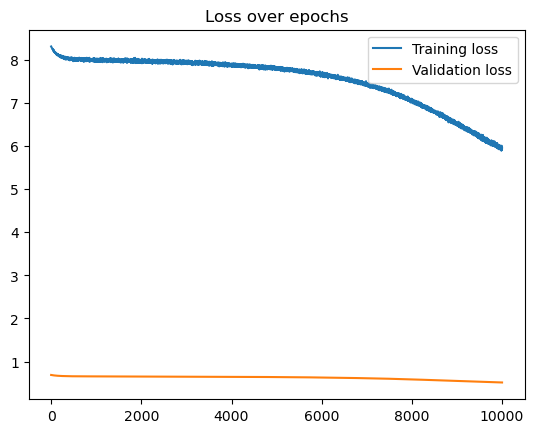

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()